In [86]:
import dask.array as da
import napari
import btrack
import json 
import numpy as np
from tqdm.auto import tqdm
from skimage.io import imshow,  imsave
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (15,7)

### Load images from zarr and compress into max projections

In [87]:
gfp = da.from_zarr('/mnt/DATA/sandbox/pierre_live_cell_data/outputs/Replication_IPSDM_GFP/zarr/tzxy_stack_ch1.zarr/')
rfp = da.from_zarr('/mnt/DATA/sandbox/pierre_live_cell_data/outputs/Replication_IPSDM_GFP/zarr/tzxy_stack_ch2.zarr/')
gfp = da.sum(gfp, axis = 1, dtype='u2')
rfp = da.sum(rfp, axis = 1, dtype='u2')
masks = da.from_zarr(f'/mnt/DATA/sandbox/pierre_live_cell_data/outputs/Replication_IPSDM_GFP/zarr/tzxy_stack_ch99.zarr/',)# chunks = gfp.chunks)

In [88]:
masks

dask.array<from-zarr, shape=(75, 6048, 6048), dtype=uint16, chunksize=(1, 2160, 2160), chunktype=numpy.ndarray>

In [89]:
gfp

dask.array<sum-aggregate, shape=(75, 6048, 6048), dtype=uint16, chunksize=(1, 2160, 2160), chunktype=numpy.ndarray>

### If you have already generated tracks then load

In [9]:
tracks_path = f'/mnt/DATA/sandbox/pierre_live_cell_data/outputs/Replication_IPSDM_GFP/zarr/tracks.h5'

In [10]:
with btrack.dataio.HDF5FileHandler(tracks_path, 
                                   'r', obj_type='obj_type_1'
                                  ) as h:
    tracks = h.tracks

[INFO][2022/08/01 11:24:33 AM] Opening HDF file: /mnt/DATA/sandbox/pierre_live_cell_data/outputs/Replication_IPSDM_GFP/zarr/tracks.h5...
[INFO][2022/08/01 11:24:33 AM] Loading tracks/obj_type_1
[INFO][2022/08/01 11:24:33 AM] Loading objects/obj_type_1 (32222, 5) (32222 filtered: None)
[INFO][2022/08/01 11:24:34 AM] Closing HDF file: /mnt/DATA/sandbox/pierre_live_cell_data/outputs/Replication_IPSDM_GFP/zarr/tracks.h5


In [16]:
tracks[0]

OrderedDict([('ID', 1), ('t', [0]), ('x', [1553.05078125]), ('y', [4721.50537109375]), ('z', [0.0]), ('parent', 1), ('root', 1), ('state', [5]), ('generation', 0), ('dummy', [False]), ('area', array([37899.], dtype=float32)), ('mean_intensity', array([377.10608], dtype=float32))])

### If not, then localise objects using optional features

In [17]:
FEATURES = [
  "area",
  "major_axis_length",
  "minor_axis_length",
  "orientation",
  "solidity",
  "mean_intensity",
]

In [18]:
%%time

objects = btrack.utils.segmentation_to_objects(
    masks, 
    gfp,
    properties = tuple(FEATURES), 
)

[INFO][2022/08/01 11:27:39 AM] Localizing objects from segmentation...
[INFO][2022/08/01 11:27:39 AM] Found intensity_image data
[INFO][2022/08/01 11:27:39 AM] Calculating weighted centroids using intensity_image
[INFO][2022/08/01 11:34:18 AM] Objects are of type: <class 'dict'>
[INFO][2022/08/01 11:34:18 AM] ...Found 34804 objects in 75 frames.


CPU times: user 19min 29s, sys: 38.6 s, total: 20min 8s
Wall time: 6min 39s


Checking for no objects larger than the size exclusion criteria

In [19]:
len([o for o in objects if 2000>o.properties['area']<10.]), len([o for o in objects if 2000>o.properties['area']])

(2479, 2592)

For some unknown reason there are a lot of objects that are very very small that were not removed by the remove_small_objects function, can just remove from the objects

In [20]:
objects = [o for o in objects if o.properties['area']>100.]

# Run btrack

trying different sets of visual-features to use

In [22]:
objects[0]

{'ID': 0, 'x': 228.89509612655968, 'y': 52.45460626056397, 'z': 0.0, 't': 0, 'dummy': False, 'states': 7, 'label': 5, 'area': 8280, 'major_axis_length': 142.1681837092044, 'minor_axis_length': 74.98138905075203, 'orientation': 0.7685315327700352, 'solidity': 0.9757247230732972, 'mean_intensity': 1223.1384057971015}

In [23]:
FEATURES = [
  "area",
  "major_axis_length",
  "minor_axis_length",
  "orientation",
  "solidity",
  "mean_intensity",
]

In [24]:
# initialise a tracker session using a context manager
with btrack.BayesianTracker() as tracker:

    # configure the tracker using a config file
    tracker.configure_from_file(
        '/home/dayn/analysis/BayesianTracker/models/cell_config.json'
    )
    tracker.verbose = True

    tracker.max_search_radius = 100
    
    # use visual features to track
    tracker.features = FEATURES
    
    # append the objects to be tracked
    tracker.append(objects)

    # set the volume
    tracker.volume=((0, 6048), (0, 6048), (-1e5, 1e5))

    # track them (in interactive mode)
    tracker.track_interactive(step_size=25)

    # generate hypotheses and run the global optimizer
    tracker.optimize()

    tracker.export(f'/mnt/DATA/sandbox/pierre_live_cell_data/outputs/Replication_IPSDM_GFP/zarr/tracks.h5', obj_type='obj_type_1')

    # get the tracks in a format for napari visualization (optional)
    visaulise_tracks, properties, graph = tracker.to_napari(ndim=2)
    
    tracks = tracker.tracks

[INFO][2022/08/01 11:34:31 AM] Loaded btrack: /home/dayn/analysis/BayesianTracker/btrack/libs/libtracker.so
[INFO][2022/08/01 11:34:31 AM] btrack (v0.5.0) library imported
[INFO][2022/08/01 11:34:31 AM] Starting BayesianTracker session
[INFO][2022/08/01 11:34:31 AM] Loading configuration file: /home/dayn/analysis/BayesianTracker/models/cell_config.json
[INFO][2022/08/01 11:34:31 AM] Setting max_search_radius -> 100
[INFO][2022/08/01 11:34:31 AM] Setting features -> ['area', 'major_axis_length', 'minor_axis_length', 'orientation', 'solidity', 'mean_intensity']
[INFO][2022/08/01 11:34:31 AM] Objects are of type: <class 'list'>
[INFO][2022/08/01 11:34:32 AM] Setting volume -> ((0, 6048), (0, 6048), (-100000.0, 100000.0))
[WARNING][2022/08/01 11:34:32 AM] `track_interactive` will be deprecated. Use `track` instead.
[INFO][2022/08/01 11:34:32 AM] Starting tracking... 
[INFO][2022/08/01 11:34:32 AM] Update using: ['MOTION']
[INFO][2022/08/01 11:34:32 AM] Tracking objects in frames 0 to 24 (o

GLPK Integer Optimizer 5.0
28264 rows, 22313 columns, 30515 non-zeros
22313 integer variables, all of which are binary
Preprocessing...
14132 rows, 22313 columns, 30515 non-zeros
22313 integer variables, all of which are binary
Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00
Problem data seem to be well scaled
Constructing initial basis...
Size of triangular part is 14132
Solving LP relaxation...
GLPK Simplex Optimizer 5.0
14132 rows, 22313 columns, 30515 non-zeros
*     0: obj =   8.330705112e+04 inf =   0.000e+00 (4694)
Perturbing LP to avoid stalling [2103]...
Removing LP perturbation [4714]...
*  4714: obj =   5.227436230e+04 inf =   0.000e+00 (0)
OPTIMAL LP SOLUTION FOUND
Integer optimization begins...
Long-step dual simplex will be used
+  4714: mip =     not found yet >=              -inf        (1; 0)
+  4715: >>>>>   5.227450850e+04 >=   5.227450850e+04   0.0% (2; 0)
+  4715: mip =   5.227450850e+04 >=     tree is empty   0.0% (0; 3)
INTEGER OPT

[INFO][2022/08/01 11:35:00 AM] Writing tracks/obj_type_1
[WARNING][2022/08/01 11:35:00 AM] Removing tracks/obj_type_1.
[INFO][2022/08/01 11:35:00 AM] Writing dummies/obj_type_1
[INFO][2022/08/01 11:35:00 AM] Writing LBEP/obj_type_1
[INFO][2022/08/01 11:35:00 AM] Writing fates/obj_type_1
[INFO][2022/08/01 11:35:00 AM] Closing HDF file: /mnt/DATA/sandbox/pierre_live_cell_data/outputs/Replication_IPSDM_GFP/zarr/tracks.h5
[INFO][2022/08/01 11:35:02 AM] Ending BayesianTracker session


# Check out the tracks

In [25]:
print('average track length:', np.mean([len(track) for track in tracks]))

average track length: 7.084549975934542


#### Save out average track length with config dict for quick record of tracker performance

In [58]:
config_dict[np.mean([len(track) for track in tracks])] = list(tracker.configuration)

In [59]:
np.save(f'/mnt/DATA/sandbox/pierre_live_cell_data/outputs/Replication_IPSDM_GFP/zarr/track_tests_info.npy', config_dict)

In [60]:
config_dict = np.load(f'/mnt/DATA/sandbox/pierre_live_cell_data/outputs/Replication_IPSDM_GFP/zarr/track_tests_info.pkl', allow_pickle = True)

(array([4.438e+03, 1.141e+03, 4.060e+02, 1.280e+02, 7.300e+01, 2.500e+01,
        1.000e+01, 7.000e+00, 4.000e+00, 1.000e+00]),
 array([ 1. ,  8.4, 15.8, 23.2, 30.6, 38. , 45.4, 52.8, 60.2, 67.6, 75. ]),
 <BarContainer object of 10 artists>)

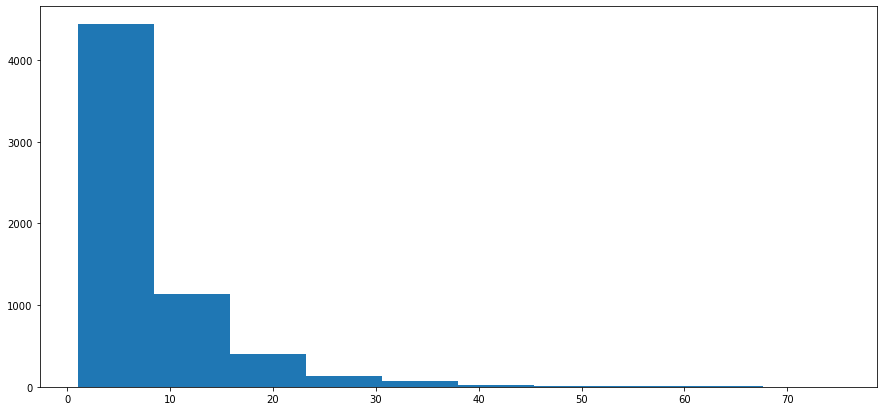

In [61]:
plt.hist([len(track) for track in tracks])

In [62]:
tracks_filt = [track for track in tracks if len(track) > 15]

In [ ]:
visaulise_tracks, properties, graph = btrack.utils.tracks_to_napari(tracks_filt, ndim = 2)

In [90]:
viewer = napari.Viewer()
viewer.add_image(gfp, name="gfp", 
                 #contrast_limits=[0,255],
                 blending = 'additive', colormap = 'green')
viewer.add_image(rfp, name="rfp", 
                # contrast_limits=[0,55], 
                 blending = 'additive', colormap = 'magenta')
viewer.add_labels(masks, name = 'masks', visible=False)
viewer.add_tracks(visaulise_tracks, name = 'tracks IDE')

/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari_tools_menu/__init__.py:179: FutureWarning: Public access to Window.qt_viewer is deprecated and will be removed in
v0.5.0. It is considered an "implementation detail" of the napari
application, not part of the napari viewer model. If your use case
requires access to qt_viewer, please open an issue to discuss.
  self.tools_menu = ToolsMenu(self, self.qt_viewer.viewer)


<Tracks layer 'tracks IDE' at 0x7f15af01c910>

2022-08-04 17:11:20.953915: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


# Conclusion from first round

These tracks perform very poorly... what if the image features are used to improve the performance?

# Trying vis feat ITERATIVELY 

In [64]:
FEATURES = [
  "area",
  "major_axis_length",
  "minor_axis_length",
  "orientation",
  "solidity",
]

In [65]:
from itertools import combinations

In [68]:
combinations(FEATURES, 2)

In [70]:
list_combinations = []
for n in range(len(FEATURES) + 1):
    list_combinations += list(combinations(FEATURES, n))
print(list_combinations)

[(), ('area',), ('major_axis_length',), ('minor_axis_length',), ('orientation',), ('solidity',), ('area', 'major_axis_length'), ('area', 'minor_axis_length'), ('area', 'orientation'), ('area', 'solidity'), ('major_axis_length', 'minor_axis_length'), ('major_axis_length', 'orientation'), ('major_axis_length', 'solidity'), ('minor_axis_length', 'orientation'), ('minor_axis_length', 'solidity'), ('orientation', 'solidity'), ('area', 'major_axis_length', 'minor_axis_length'), ('area', 'major_axis_length', 'orientation'), ('area', 'major_axis_length', 'solidity'), ('area', 'minor_axis_length', 'orientation'), ('area', 'minor_axis_length', 'solidity'), ('area', 'orientation', 'solidity'), ('major_axis_length', 'minor_axis_length', 'orientation'), ('major_axis_length', 'minor_axis_length', 'solidity'), ('major_axis_length', 'orientation', 'solidity'), ('minor_axis_length', 'orientation', 'solidity'), ('area', 'major_axis_length', 'minor_axis_length', 'orientation'), ('area', 'major_axis_lengt

In [72]:
del list_combinations[0]

In [73]:
for i in list_combinations:
    print(i)

('area',)
('major_axis_length',)
('minor_axis_length',)
('orientation',)
('solidity',)
('area', 'major_axis_length')
('area', 'minor_axis_length')
('area', 'orientation')
('area', 'solidity')
('major_axis_length', 'minor_axis_length')
('major_axis_length', 'orientation')
('major_axis_length', 'solidity')
('minor_axis_length', 'orientation')
('minor_axis_length', 'solidity')
('orientation', 'solidity')
('area', 'major_axis_length', 'minor_axis_length')
('area', 'major_axis_length', 'orientation')
('area', 'major_axis_length', 'solidity')
('area', 'minor_axis_length', 'orientation')
('area', 'minor_axis_length', 'solidity')
('area', 'orientation', 'solidity')
('major_axis_length', 'minor_axis_length', 'orientation')
('major_axis_length', 'minor_axis_length', 'solidity')
('major_axis_length', 'orientation', 'solidity')
('minor_axis_length', 'orientation', 'solidity')
('area', 'major_axis_length', 'minor_axis_length', 'orientation')
('area', 'major_axis_length', 'minor_axis_length', 'solid

In [74]:
for features in tqdm(list_combinations):
    # initialise a tracker session using a context manager
    with btrack.BayesianTracker() as tracker:

        # configure the tracker using a config file
        tracker.configure_from_file(
            '/home/dayn/analysis/BayesianTracker/models/cell_config.json'
        )
        tracker.verbose = True

        tracker.max_search_radius = 100

        # use visual features to track
        tracker.features = features

        # append the objects to be tracked
        tracker.append(objects)

        # set the volume
        tracker.volume=((0, 6048), (0, 6048), (-1e5, 1e5))

        # track them (in interactive mode)
        tracker.track_interactive(step_size=25)

        # generate hypotheses and run the global optimizer
        tracker.optimize()

        #tracker.export(f'/mnt/DATA/sandbox/pierre_live_cell_data/outputs/Replication_IPSDM_GFP/zarr/tracks.h5', obj_type='obj_type_1')

        # get the tracks in a format for napari visualization (optional)
        visaulise_tracks, properties, graph = tracker.to_napari(ndim=2)

        tracks = tracker.tracks

        ### quick assessment of tracking performance
        config_dict[np.mean([len(track) for track in tracks])] = list(tracker.configuration)
        
        ### update saved record of average track length with config
        np.save(f'/mnt/DATA/sandbox/pierre_live_cell_data/outputs/Replication_IPSDM_GFP/zarr/track_tests_info.npy', config_dict)

  0%|          | 0/31 [00:00<?, ?it/s]

[INFO][2022/08/01 12:00:43 pm] Loaded btrack: /home/dayn/analysis/BayesianTracker/btrack/libs/libtracker.so
[INFO][2022/08/01 12:00:43 pm] btrack (v0.5.0) library imported
[INFO][2022/08/01 12:00:43 pm] Starting BayesianTracker session
[INFO][2022/08/01 12:00:43 pm] Loading configuration file: /home/dayn/analysis/BayesianTracker/models/cell_config.json
[INFO][2022/08/01 12:00:43 pm] Setting max_search_radius -> 100
[INFO][2022/08/01 12:00:43 pm] Setting features -> ('area',)
[INFO][2022/08/01 12:00:43 pm] Objects are of type: <class 'list'>
[INFO][2022/08/01 12:00:44 pm] Setting volume -> ((0, 6048), (0, 6048), (-100000.0, 100000.0))
[WARNING][2022/08/01 12:00:44 pm] `track_interactive` will be deprecated. Use `track` instead.
[INFO][2022/08/01 12:00:44 pm] Starting tracking... 
[INFO][2022/08/01 12:00:44 pm] Update using: ['MOTION']
[INFO][2022/08/01 12:00:44 pm] Tracking objects in frames 0 to 24 (of 75)...
[INFO][2022/08/01 12:01:17 pm]  - Timing (Bayesian updates: 462.20ms, Linking

GLPK Integer Optimizer 5.0
128592 rows, 139161 columns, 225158 non-zeros
139161 integer variables, all of which are binary
Preprocessing...
64296 rows, 139161 columns, 225158 non-zeros
139161 integer variables, all of which are binary
Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00
Problem data seem to be well scaled
Constructing initial basis...
Size of triangular part is 64296
Solving LP relaxation...
GLPK Simplex Optimizer 5.0
64296 rows, 139161 columns, 225158 non-zeros
*     0: obj =   4.098820834e+05 inf =   0.000e+00 (74865)
Perturbing LP to avoid stalling [659]...
*  1949: obj =   3.856029334e+05 inf =   0.000e+00 (70719)
*  3754: obj =   3.645955834e+05 inf =   0.000e+00 (66658)
*  5620: obj =   3.418326334e+05 inf =   0.000e+00 (62616)
*  7466: obj =   3.186706834e+05 inf =   0.000e+00 (58714)
*  9192: obj =   2.989002334e+05 inf =   0.000e+00 (54783)
* 10831: obj =   2.836796948e+05 inf =   0.000e+00 (51239)
* 12075: obj =   2.805577812e+05 in

[INFO][2022/08/01 12:02:55 pm] Ending BayesianTracker session
[INFO][2022/08/01 12:02:55 pm] Loaded btrack: /home/dayn/analysis/BayesianTracker/btrack/libs/libtracker.so
[INFO][2022/08/01 12:02:55 pm] btrack (v0.5.0) library imported
[INFO][2022/08/01 12:02:55 pm] Starting BayesianTracker session
[INFO][2022/08/01 12:02:55 pm] Loading configuration file: /home/dayn/analysis/BayesianTracker/models/cell_config.json
[INFO][2022/08/01 12:02:55 pm] Setting max_search_radius -> 100
[INFO][2022/08/01 12:02:55 pm] Setting features -> ('major_axis_length',)
[INFO][2022/08/01 12:02:55 pm] Objects are of type: <class 'list'>
[INFO][2022/08/01 12:02:55 pm] Setting volume -> ((0, 6048), (0, 6048), (-100000.0, 100000.0))
[WARNING][2022/08/01 12:02:55 pm] `track_interactive` will be deprecated. Use `track` instead.
[INFO][2022/08/01 12:02:55 pm] Starting tracking... 
[INFO][2022/08/01 12:02:55 pm] Update using: ['MOTION']
[INFO][2022/08/01 12:02:56 pm] Tracking objects in frames 0 to 24 (of 75)...
[I

GLPK Integer Optimizer 5.0
128592 rows, 139161 columns, 225158 non-zeros
139161 integer variables, all of which are binary
Preprocessing...
64296 rows, 139161 columns, 225158 non-zeros
139161 integer variables, all of which are binary
Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00
Problem data seem to be well scaled
Constructing initial basis...
Size of triangular part is 64296
Solving LP relaxation...
GLPK Simplex Optimizer 5.0
64296 rows, 139161 columns, 225158 non-zeros
*     0: obj =   4.098820834e+05 inf =   0.000e+00 (74865)
Perturbing LP to avoid stalling [659]...
*  1937: obj =   3.857425834e+05 inf =   0.000e+00 (70746)
*  3722: obj =   3.648748834e+05 inf =   0.000e+00 (66744)
*  5561: obj =   3.425308834e+05 inf =   0.000e+00 (62747)
*  7411: obj =   3.192891334e+05 inf =   0.000e+00 (58836)
*  9088: obj =   2.998777834e+05 inf =   0.000e+00 (55049)
* 10732: obj =   2.839838858e+05 inf =   0.000e+00 (51305)
* 11977: obj =   2.808043004e+05 in

[INFO][2022/08/01 12:05:10 pm] Ending BayesianTracker session
[INFO][2022/08/01 12:05:10 pm] Loaded btrack: /home/dayn/analysis/BayesianTracker/btrack/libs/libtracker.so
[INFO][2022/08/01 12:05:10 pm] btrack (v0.5.0) library imported
[INFO][2022/08/01 12:05:10 pm] Starting BayesianTracker session
[INFO][2022/08/01 12:05:10 pm] Loading configuration file: /home/dayn/analysis/BayesianTracker/models/cell_config.json
[INFO][2022/08/01 12:05:10 pm] Setting max_search_radius -> 100
[INFO][2022/08/01 12:05:10 pm] Setting features -> ('minor_axis_length',)
[INFO][2022/08/01 12:05:10 pm] Objects are of type: <class 'list'>
[INFO][2022/08/01 12:05:11 pm] Setting volume -> ((0, 6048), (0, 6048), (-100000.0, 100000.0))
[WARNING][2022/08/01 12:05:11 pm] `track_interactive` will be deprecated. Use `track` instead.
[INFO][2022/08/01 12:05:11 pm] Starting tracking... 
[INFO][2022/08/01 12:05:11 pm] Update using: ['MOTION']
[INFO][2022/08/01 12:05:11 pm] Tracking objects in frames 0 to 24 (of 75)...
[I

GLPK Integer Optimizer 5.0
128592 rows, 139161 columns, 225158 non-zeros
139161 integer variables, all of which are binary
Preprocessing...
64296 rows, 139161 columns, 225158 non-zeros
139161 integer variables, all of which are binary
Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00
Problem data seem to be well scaled
Constructing initial basis...
Size of triangular part is 64296
Solving LP relaxation...
GLPK Simplex Optimizer 5.0
64296 rows, 139161 columns, 225158 non-zeros
*     0: obj =   4.098820834e+05 inf =   0.000e+00 (74865)
Perturbing LP to avoid stalling [659]...
*  1980: obj =   3.852039334e+05 inf =   0.000e+00 (70655)
*  3828: obj =   3.638574334e+05 inf =   0.000e+00 (66473)
*  5697: obj =   3.408351334e+05 inf =   0.000e+00 (62458)
*  7547: obj =   3.178527334e+05 inf =   0.000e+00 (58512)
*  9309: obj =   2.974239334e+05 inf =   0.000e+00 (54540)
* 10929: obj =   2.834159877e+05 inf =   0.000e+00 (51171)
* 12185: obj =   2.801822608e+05 in

[INFO][2022/08/01 12:07:22 pm] Ending BayesianTracker session
[INFO][2022/08/01 12:07:22 pm] Loaded btrack: /home/dayn/analysis/BayesianTracker/btrack/libs/libtracker.so
[INFO][2022/08/01 12:07:22 pm] btrack (v0.5.0) library imported
[INFO][2022/08/01 12:07:22 pm] Starting BayesianTracker session
[INFO][2022/08/01 12:07:22 pm] Loading configuration file: /home/dayn/analysis/BayesianTracker/models/cell_config.json
[INFO][2022/08/01 12:07:22 pm] Setting max_search_radius -> 100
[INFO][2022/08/01 12:07:22 pm] Setting features -> ('orientation',)
[INFO][2022/08/01 12:07:22 pm] Objects are of type: <class 'list'>
[INFO][2022/08/01 12:07:22 pm] Setting volume -> ((0, 6048), (0, 6048), (-100000.0, 100000.0))
[WARNING][2022/08/01 12:07:22 pm] `track_interactive` will be deprecated. Use `track` instead.
[INFO][2022/08/01 12:07:22 pm] Starting tracking... 
[INFO][2022/08/01 12:07:22 pm] Update using: ['MOTION']
[INFO][2022/08/01 12:07:23 pm] Tracking objects in frames 0 to 24 (of 75)...
[INFO][2

GLPK Integer Optimizer 5.0
128592 rows, 139161 columns, 225158 non-zeros
139161 integer variables, all of which are binary
Preprocessing...
64296 rows, 139161 columns, 225158 non-zeros
139161 integer variables, all of which are binary
Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00
Problem data seem to be well scaled
Constructing initial basis...
Size of triangular part is 64296
Solving LP relaxation...
GLPK Simplex Optimizer 5.0
64296 rows, 139161 columns, 225158 non-zeros
*     0: obj =   4.098820834e+05 inf =   0.000e+00 (74865)
Perturbing LP to avoid stalling [659]...
*  1966: obj =   3.853635334e+05 inf =   0.000e+00 (70687)
*  3779: obj =   3.643362334e+05 inf =   0.000e+00 (66597)
*  5617: obj =   3.418924834e+05 inf =   0.000e+00 (62619)
*  7443: obj =   3.189499834e+05 inf =   0.000e+00 (58759)
*  9182: obj =   2.989600834e+05 inf =   0.000e+00 (54814)
* 10810: obj =   2.837853768e+05 inf =   0.000e+00 (51260)
* 12074: obj =   2.805577812e+05 in

[INFO][2022/08/01 12:09:32 pm] Ending BayesianTracker session
[INFO][2022/08/01 12:09:32 pm] Loaded btrack: /home/dayn/analysis/BayesianTracker/btrack/libs/libtracker.so
[INFO][2022/08/01 12:09:32 pm] btrack (v0.5.0) library imported
[INFO][2022/08/01 12:09:32 pm] Starting BayesianTracker session
[INFO][2022/08/01 12:09:32 pm] Loading configuration file: /home/dayn/analysis/BayesianTracker/models/cell_config.json
[INFO][2022/08/01 12:09:32 pm] Setting max_search_radius -> 100
[INFO][2022/08/01 12:09:32 pm] Setting features -> ('solidity',)
[INFO][2022/08/01 12:09:32 pm] Objects are of type: <class 'list'>
[INFO][2022/08/01 12:09:33 pm] Setting volume -> ((0, 6048), (0, 6048), (-100000.0, 100000.0))
[WARNING][2022/08/01 12:09:33 pm] `track_interactive` will be deprecated. Use `track` instead.
[INFO][2022/08/01 12:09:33 pm] Starting tracking... 
[INFO][2022/08/01 12:09:33 pm] Update using: ['MOTION']
[INFO][2022/08/01 12:09:33 pm] Tracking objects in frames 0 to 24 (of 75)...
[INFO][2022

GLPK Integer Optimizer 5.0
128592 rows, 139161 columns, 225158 non-zeros
139161 integer variables, all of which are binary
Preprocessing...
64296 rows, 139161 columns, 225158 non-zeros
139161 integer variables, all of which are binary
Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00
Problem data seem to be well scaled
Constructing initial basis...
Size of triangular part is 64296
Solving LP relaxation...
GLPK Simplex Optimizer 5.0
64296 rows, 139161 columns, 225158 non-zeros
*     0: obj =   4.098820834e+05 inf =   0.000e+00 (74865)
Perturbing LP to avoid stalling [659]...
*  1995: obj =   3.850642834e+05 inf =   0.000e+00 (70616)
*  3845: obj =   3.636579334e+05 inf =   0.000e+00 (66435)
*  5736: obj =   3.403363834e+05 inf =   0.000e+00 (62377)
*  7602: obj =   3.170547334e+05 inf =   0.000e+00 (58409)
*  9373: obj =   2.968054834e+05 inf =   0.000e+00 (54377)
* 10995: obj =   2.832319078e+05 inf =   0.000e+00 (51136)
* 12270: obj =   2.799107043e+05 in

[INFO][2022/08/01 12:11:45 pm] Ending BayesianTracker session
[INFO][2022/08/01 12:11:45 pm] Loaded btrack: /home/dayn/analysis/BayesianTracker/btrack/libs/libtracker.so
[INFO][2022/08/01 12:11:45 pm] btrack (v0.5.0) library imported
[INFO][2022/08/01 12:11:45 pm] Starting BayesianTracker session
[INFO][2022/08/01 12:11:45 pm] Loading configuration file: /home/dayn/analysis/BayesianTracker/models/cell_config.json
[INFO][2022/08/01 12:11:45 pm] Setting max_search_radius -> 100
[INFO][2022/08/01 12:11:45 pm] Setting features -> ('area', 'major_axis_length')
[INFO][2022/08/01 12:11:45 pm] Objects are of type: <class 'list'>
[INFO][2022/08/01 12:11:46 pm] Setting volume -> ((0, 6048), (0, 6048), (-100000.0, 100000.0))
[WARNING][2022/08/01 12:11:46 pm] `track_interactive` will be deprecated. Use `track` instead.
[INFO][2022/08/01 12:11:46 pm] Starting tracking... 
[INFO][2022/08/01 12:11:46 pm] Update using: ['MOTION']
[INFO][2022/08/01 12:11:46 pm] Tracking objects in frames 0 to 24 (of 75

ERROR: Exhausted potential linkages.
ERROR: Exhausted potential linkages.
ERROR: Exhausted potential linkages.
ERROR: Exhausted potential linkages.


[INFO][2022/08/01 12:11:59 pm]  - Timing (Bayesian updates: 163.88ms, Linking: 5.94ms)
[INFO][2022/08/01 12:11:59 pm]  - Probabilities (Link: 0.99997, Lost: 1.00000)
[INFO][2022/08/01 12:11:59 pm]  - Stats (Active: 1325, Lost: 11421, Conflicts resolved: 6664)
[INFO][2022/08/01 12:11:59 pm] Tracking objects in frames 25 to 49 (of 75)...


ERROR: Exhausted potential linkages.
ERROR: Exhausted potential linkages.


[INFO][2022/08/01 12:12:08 pm]  - Timing (Bayesian updates: 51.27ms, Linking: 2.81ms)
[INFO][2022/08/01 12:12:08 pm]  - Probabilities (Link: 1.00000, Lost: 1.00000)
[INFO][2022/08/01 12:12:08 pm]  - Stats (Active: 848, Lost: 20933, Conflicts resolved: 12367)
[INFO][2022/08/01 12:12:08 pm] Tracking objects in frames 50 to 74 (of 75)...
[INFO][2022/08/01 12:12:09 pm]  - Timing (Bayesian updates: 2.57ms, Linking: 0.69ms)
[INFO][2022/08/01 12:12:09 pm]  - Probabilities (Link: 1.00000, Lost: 1.00000)
[INFO][2022/08/01 12:12:09 pm] SUCCESS.
[INFO][2022/08/01 12:12:09 pm]  - Found 6805 tracks in 75 frames (in 0.0s)
[INFO][2022/08/01 12:12:09 pm]  - Inserted 17741 dummy objects to fill tracking gaps
[INFO][2022/08/01 12:12:09 pm] Loading hypothesis model: cell_hypothesis
[INFO][2022/08/01 12:12:09 pm] Calculating hypotheses (relax: True)...
[INFO][2022/08/01 12:12:09 pm] Setting up constraints matrix for global optimisation...
[INFO][2022/08/01 12:12:09 pm] Using GLPK options: {'tm_lim': 60000

GLPK Integer Optimizer 5.0
27220 rows, 21449 columns, 29302 non-zeros
21449 integer variables, all of which are binary
Preprocessing...
13610 rows, 21449 columns, 29302 non-zeros
21449 integer variables, all of which are binary
Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00
Problem data seem to be well scaled
Constructing initial basis...
Size of triangular part is 13610
Solving LP relaxation...
GLPK Simplex Optimizer 5.0
13610 rows, 21449 columns, 29302 non-zeros
*     0: obj =   8.017309914e+04 inf =   0.000e+00 (4482)
Perturbing LP to avoid stalling [2006]...
Removing LP perturbation [4509]...
*  4509: obj =   5.097386486e+04 inf =   0.000e+00 (0)
OPTIMAL LP SOLUTION FOUND
Integer optimization begins...
Long-step dual simplex will be used
+  4509: mip =     not found yet >=              -inf        (1; 0)
+  4509: >>>>>   5.097386486e+04 >=   5.097386486e+04   0.0% (1; 0)
+  4509: mip =   5.097386486e+04 >=     tree is empty   0.0% (0; 1)
INTEGER OPT

[INFO][2022/08/01 12:12:13 pm] Ending BayesianTracker session
[INFO][2022/08/01 12:12:13 pm] Loaded btrack: /home/dayn/analysis/BayesianTracker/btrack/libs/libtracker.so
[INFO][2022/08/01 12:12:13 pm] btrack (v0.5.0) library imported
[INFO][2022/08/01 12:12:13 pm] Starting BayesianTracker session
[INFO][2022/08/01 12:12:13 pm] Loading configuration file: /home/dayn/analysis/BayesianTracker/models/cell_config.json
[INFO][2022/08/01 12:12:13 pm] Setting max_search_radius -> 100
[INFO][2022/08/01 12:12:13 pm] Setting features -> ('area', 'minor_axis_length')
[INFO][2022/08/01 12:12:13 pm] Objects are of type: <class 'list'>
[INFO][2022/08/01 12:12:14 pm] Setting volume -> ((0, 6048), (0, 6048), (-100000.0, 100000.0))
[WARNING][2022/08/01 12:12:14 pm] `track_interactive` will be deprecated. Use `track` instead.
[INFO][2022/08/01 12:12:14 pm] Starting tracking... 
[INFO][2022/08/01 12:12:14 pm] Update using: ['MOTION']
[INFO][2022/08/01 12:12:14 pm] Tracking objects in frames 0 to 24 (of 75

ERROR: Exhausted potential linkages.
ERROR: Exhausted potential linkages.
ERROR: Exhausted potential linkages.
ERROR: Exhausted potential linkages.


[INFO][2022/08/01 12:12:27 pm]  - Timing (Bayesian updates: 160.09ms, Linking: 6.09ms)
[INFO][2022/08/01 12:12:27 pm]  - Probabilities (Link: 0.99999, Lost: 1.00000)
[INFO][2022/08/01 12:12:27 pm]  - Stats (Active: 1321, Lost: 11214, Conflicts resolved: 6731)
[INFO][2022/08/01 12:12:27 pm] Tracking objects in frames 25 to 49 (of 75)...
[INFO][2022/08/01 12:12:37 pm]  - Timing (Bayesian updates: 51.97ms, Linking: 2.83ms)
[INFO][2022/08/01 12:12:37 pm]  - Probabilities (Link: 1.00000, Lost: 1.00000)
[INFO][2022/08/01 12:12:37 pm]  - Stats (Active: 848, Lost: 20377, Conflicts resolved: 12446)
[INFO][2022/08/01 12:12:37 pm] Tracking objects in frames 50 to 74 (of 75)...
[INFO][2022/08/01 12:12:38 pm]  - Timing (Bayesian updates: 3.52ms, Linking: 0.98ms)
[INFO][2022/08/01 12:12:38 pm]  - Probabilities (Link: 1.00000, Lost: 1.00000)
[INFO][2022/08/01 12:12:38 pm] SUCCESS.
[INFO][2022/08/01 12:12:38 pm]  - Found 6775 tracks in 75 frames (in 0.0s)
[INFO][2022/08/01 12:12:38 pm]  - Inserted 172

GLPK Integer Optimizer 5.0
27100 rows, 21336 columns, 29139 non-zeros
21336 integer variables, all of which are binary
Preprocessing...
13550 rows, 21336 columns, 29139 non-zeros
21336 integer variables, all of which are binary
Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00
Problem data seem to be well scaled
Constructing initial basis...
Size of triangular part is 13550
Solving LP relaxation...
GLPK Simplex Optimizer 5.0
13550 rows, 21336 columns, 29139 non-zeros
*     0: obj =   7.978357379e+04 inf =   0.000e+00 (4552)
Perturbing LP to avoid stalling [1968]...
Removing LP perturbation [4584]...
*  4584: obj =   5.018025856e+04 inf =   0.000e+00 (0)
OPTIMAL LP SOLUTION FOUND
Integer optimization begins...
Long-step dual simplex will be used
+  4584: mip =     not found yet >=              -inf        (1; 0)
+  4584: >>>>>   5.018025856e+04 >=   5.018025856e+04   0.0% (1; 0)
+  4584: mip =   5.018025856e+04 >=     tree is empty   0.0% (0; 1)
INTEGER OPT

[INFO][2022/08/01 12:12:43 pm] Ending BayesianTracker session
[INFO][2022/08/01 12:12:43 pm] Loaded btrack: /home/dayn/analysis/BayesianTracker/btrack/libs/libtracker.so
[INFO][2022/08/01 12:12:43 pm] btrack (v0.5.0) library imported
[INFO][2022/08/01 12:12:43 pm] Starting BayesianTracker session
[INFO][2022/08/01 12:12:43 pm] Loading configuration file: /home/dayn/analysis/BayesianTracker/models/cell_config.json
[INFO][2022/08/01 12:12:43 pm] Setting max_search_radius -> 100
[INFO][2022/08/01 12:12:43 pm] Setting features -> ('area', 'orientation')
[INFO][2022/08/01 12:12:43 pm] Objects are of type: <class 'list'>
[INFO][2022/08/01 12:12:44 pm] Setting volume -> ((0, 6048), (0, 6048), (-100000.0, 100000.0))
[WARNING][2022/08/01 12:12:44 pm] `track_interactive` will be deprecated. Use `track` instead.
[INFO][2022/08/01 12:12:44 pm] Starting tracking... 
[INFO][2022/08/01 12:12:44 pm] Update using: ['MOTION']
[INFO][2022/08/01 12:12:44 pm] Tracking objects in frames 0 to 24 (of 75)...


ERROR: Exhausted potential linkages.
ERROR: Exhausted potential linkages.
ERROR: Exhausted potential linkages.


[INFO][2022/08/01 12:12:58 pm]  - Timing (Bayesian updates: 166.57ms, Linking: 5.53ms)
[INFO][2022/08/01 12:12:58 pm]  - Probabilities (Link: 0.98974, Lost: 1.00000)
[INFO][2022/08/01 12:12:58 pm]  - Stats (Active: 1338, Lost: 9047, Conflicts resolved: 6434)
[INFO][2022/08/01 12:12:58 pm] Tracking objects in frames 25 to 49 (of 75)...


ERROR: Exhausted potential linkages.
ERROR: Exhausted potential linkages.
ERROR: Exhausted potential linkages.


[INFO][2022/08/01 12:13:08 pm]  - Timing (Bayesian updates: 54.75ms, Linking: 2.92ms)
[INFO][2022/08/01 12:13:08 pm]  - Probabilities (Link: 1.00000, Lost: 1.00000)
[INFO][2022/08/01 12:13:08 pm]  - Stats (Active: 851, Lost: 16825, Conflicts resolved: 12077)
[INFO][2022/08/01 12:13:08 pm] Tracking objects in frames 50 to 74 (of 75)...


ERROR: Exhausted potential linkages.
ERROR: Exhausted potential linkages.


[INFO][2022/08/01 12:13:09 pm]  - Timing (Bayesian updates: 3.00ms, Linking: 0.80ms)
[INFO][2022/08/01 12:13:09 pm]  - Probabilities (Link: 1.00000, Lost: 1.00000)
[INFO][2022/08/01 12:13:09 pm] SUCCESS.
[INFO][2022/08/01 12:13:09 pm]  - Found 7033 tracks in 75 frames (in 0.0s)
[INFO][2022/08/01 12:13:09 pm]  - Inserted 17460 dummy objects to fill tracking gaps
[INFO][2022/08/01 12:13:09 pm] Loading hypothesis model: cell_hypothesis
[INFO][2022/08/01 12:13:09 pm] Calculating hypotheses (relax: True)...
[INFO][2022/08/01 12:13:09 pm] Setting up constraints matrix for global optimisation...
[INFO][2022/08/01 12:13:09 pm] Using GLPK options: {'tm_lim': 60000}...


ERROR: Exhausted potential linkages.
ERROR: Exhausted potential linkages.


[INFO][2022/08/01 12:13:09 pm] Optimizing...
[INFO][2022/08/01 12:13:11 pm] Optimization complete. (Solution: optimal)
[INFO][2022/08/01 12:13:11 pm]  - Fates.FALSE_POSITIVE: 3156 (of 7033)
[INFO][2022/08/01 12:13:11 pm]  - Fates.LINK: 851 (of 1095)
[INFO][2022/08/01 12:13:11 pm]  - Fates.DIVIDE: 9 (of 21)
[INFO][2022/08/01 12:13:11 pm]  - Fates.INITIALIZE_BORDER: 10 (of 33)
[INFO][2022/08/01 12:13:11 pm]  - Fates.INITIALIZE_FRONT: 977 (of 1467)
[INFO][2022/08/01 12:13:11 pm]  - Fates.INITIALIZE_LAZY: 2021 (of 5533)
[INFO][2022/08/01 12:13:11 pm]  - Fates.TERMINATE_BORDER: 14 (of 38)
[INFO][2022/08/01 12:13:11 pm]  - Fates.TERMINATE_BACK: 185 (of 260)
[INFO][2022/08/01 12:13:11 pm]  - Fates.TERMINATE_LAZY: 2818 (of 6735)
[INFO][2022/08/01 12:13:11 pm]  - TOTAL: 22215 hypotheses
[INFO][2022/08/01 12:13:11 pm] Completed optimization with 6182 tracks


GLPK Integer Optimizer 5.0
28132 rows, 22215 columns, 30385 non-zeros
22215 integer variables, all of which are binary
Preprocessing...
14066 rows, 22215 columns, 30385 non-zeros
22215 integer variables, all of which are binary
Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00
Problem data seem to be well scaled
Constructing initial basis...
Size of triangular part is 14066
Solving LP relaxation...
GLPK Simplex Optimizer 5.0
14066 rows, 22215 columns, 30385 non-zeros
*     0: obj =   8.304559729e+04 inf =   0.000e+00 (4807)
Perturbing LP to avoid stalling [2052]...
Removing LP perturbation [4850]...
*  4850: obj =   5.141117631e+04 inf =   0.000e+00 (0)
OPTIMAL LP SOLUTION FOUND
Integer optimization begins...
Long-step dual simplex will be used
+  4850: mip =     not found yet >=              -inf        (1; 0)
+  4850: >>>>>   5.141117631e+04 >=   5.141117631e+04   0.0% (1; 0)
+  4850: mip =   5.141117631e+04 >=     tree is empty   0.0% (0; 1)
INTEGER OPT

[INFO][2022/08/01 12:13:12 pm] Ending BayesianTracker session
[INFO][2022/08/01 12:13:12 pm] Loaded btrack: /home/dayn/analysis/BayesianTracker/btrack/libs/libtracker.so
[INFO][2022/08/01 12:13:12 pm] btrack (v0.5.0) library imported
[INFO][2022/08/01 12:13:12 pm] Starting BayesianTracker session
[INFO][2022/08/01 12:13:12 pm] Loading configuration file: /home/dayn/analysis/BayesianTracker/models/cell_config.json
[INFO][2022/08/01 12:13:12 pm] Setting max_search_radius -> 100
[INFO][2022/08/01 12:13:12 pm] Setting features -> ('area', 'solidity')
[INFO][2022/08/01 12:13:12 pm] Objects are of type: <class 'list'>
[INFO][2022/08/01 12:13:13 pm] Setting volume -> ((0, 6048), (0, 6048), (-100000.0, 100000.0))
[WARNING][2022/08/01 12:13:13 pm] `track_interactive` will be deprecated. Use `track` instead.
[INFO][2022/08/01 12:13:13 pm] Starting tracking... 
[INFO][2022/08/01 12:13:13 pm] Update using: ['MOTION']
[INFO][2022/08/01 12:13:13 pm] Tracking objects in frames 0 to 24 (of 75)...


ERROR: Exhausted potential linkages.
ERROR: Exhausted potential linkages.
ERROR: Exhausted potential linkages.


[INFO][2022/08/01 12:13:27 pm]  - Timing (Bayesian updates: 169.92ms, Linking: 5.87ms)
[INFO][2022/08/01 12:13:27 pm]  - Probabilities (Link: 1.00000, Lost: 1.00000)
[INFO][2022/08/01 12:13:27 pm]  - Stats (Active: 1380, Lost: 8054, Conflicts resolved: 6185)
[INFO][2022/08/01 12:13:27 pm] Tracking objects in frames 25 to 49 (of 75)...


ERROR: Exhausted potential linkages.
ERROR: Exhausted potential linkages.
ERROR: Exhausted potential linkages.


[INFO][2022/08/01 12:13:36 pm]  - Timing (Bayesian updates: 53.40ms, Linking: 3.80ms)
[INFO][2022/08/01 12:13:36 pm]  - Probabilities (Link: 1.00000, Lost: 1.00000)
[INFO][2022/08/01 12:13:36 pm]  - Stats (Active: 862, Lost: 15339, Conflicts resolved: 11681)
[INFO][2022/08/01 12:13:36 pm] Tracking objects in frames 50 to 74 (of 75)...


ERROR: Exhausted potential linkages.
ERROR: Exhausted potential linkages.
ERROR: Exhausted potential linkages.


[INFO][2022/08/01 12:13:37 pm]  - Timing (Bayesian updates: 2.86ms, Linking: 0.76ms)
[INFO][2022/08/01 12:13:37 pm]  - Probabilities (Link: 1.00000, Lost: 1.00000)
[INFO][2022/08/01 12:13:37 pm] SUCCESS.
[INFO][2022/08/01 12:13:37 pm]  - Found 7486 tracks in 75 frames (in 0.0s)
[INFO][2022/08/01 12:13:37 pm]  - Inserted 17585 dummy objects to fill tracking gaps
[INFO][2022/08/01 12:13:37 pm] Loading hypothesis model: cell_hypothesis
[INFO][2022/08/01 12:13:37 pm] Calculating hypotheses (relax: True)...
[INFO][2022/08/01 12:13:38 pm] Setting up constraints matrix for global optimisation...
[INFO][2022/08/01 12:13:38 pm] Using GLPK options: {'tm_lim': 60000}...
[INFO][2022/08/01 12:13:38 pm] Optimizing...
[INFO][2022/08/01 12:13:42 pm] Optimization complete. (Solution: optimal)
[INFO][2022/08/01 12:13:42 pm]  - Fates.FALSE_POSITIVE: 3469 (of 7486)
[INFO][2022/08/01 12:13:42 pm]  - Fates.LINK: 1036 (of 1388)
[INFO][2022/08/01 12:13:42 pm]  - Fates.DIVIDE: 18 (of 35)
[INFO][2022/08/01 12:1

GLPK Integer Optimizer 5.0
29944 rows, 23881 columns, 32825 non-zeros
23881 integer variables, all of which are binary
Preprocessing...
14972 rows, 23881 columns, 32825 non-zeros
23881 integer variables, all of which are binary
Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00
Problem data seem to be well scaled
Constructing initial basis...
Size of triangular part is 14972
Solving LP relaxation...
GLPK Simplex Optimizer 5.0
14972 rows, 23881 columns, 32825 non-zeros
*     0: obj =   8.859374039e+04 inf =   0.000e+00 (5582)
Perturbing LP to avoid stalling [2139]...
Removing LP perturbation [5642]...
*  5642: obj =   5.212095725e+04 inf =   0.000e+00 (0)
OPTIMAL LP SOLUTION FOUND
Integer optimization begins...
Long-step dual simplex will be used
+  5642: mip =     not found yet >=              -inf        (1; 0)
+  5646: >>>>>   5.212686248e+04 >=   5.212666917e+04 < 0.1% (5; 0)
+  5648: mip =   5.212686248e+04 >=     tree is empty   0.0% (0; 9)
INTEGER OPT

[INFO][2022/08/01 12:13:43 pm] Ending BayesianTracker session
[INFO][2022/08/01 12:13:43 pm] Loaded btrack: /home/dayn/analysis/BayesianTracker/btrack/libs/libtracker.so
[INFO][2022/08/01 12:13:43 pm] btrack (v0.5.0) library imported
[INFO][2022/08/01 12:13:43 pm] Starting BayesianTracker session
[INFO][2022/08/01 12:13:43 pm] Loading configuration file: /home/dayn/analysis/BayesianTracker/models/cell_config.json
[INFO][2022/08/01 12:13:43 pm] Setting max_search_radius -> 100
[INFO][2022/08/01 12:13:43 pm] Setting features -> ('major_axis_length', 'minor_axis_length')
[INFO][2022/08/01 12:13:43 pm] Objects are of type: <class 'list'>
[INFO][2022/08/01 12:13:44 pm] Setting volume -> ((0, 6048), (0, 6048), (-100000.0, 100000.0))
[WARNING][2022/08/01 12:13:44 pm] `track_interactive` will be deprecated. Use `track` instead.
[INFO][2022/08/01 12:13:44 pm] Starting tracking... 
[INFO][2022/08/01 12:13:44 pm] Update using: ['MOTION']
[INFO][2022/08/01 12:13:44 pm] Tracking objects in frames 0

GLPK Integer Optimizer 5.0
28164 rows, 22275 columns, 30486 non-zeros
22275 integer variables, all of which are binary
Preprocessing...
14082 rows, 22275 columns, 30486 non-zeros
22275 integer variables, all of which are binary
Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00
Problem data seem to be well scaled
Constructing initial basis...
Size of triangular part is 14082
Solving LP relaxation...
GLPK Simplex Optimizer 5.0
14082 rows, 22275 columns, 30486 non-zeros
*     0: obj =   8.275165587e+04 inf =   0.000e+00 (4695)
Perturbing LP to avoid stalling [2081]...
Removing LP perturbation [4715]...
*  4715: obj =   5.211184845e+04 inf =   0.000e+00 (0)
OPTIMAL LP SOLUTION FOUND
Integer optimization begins...
Long-step dual simplex will be used
+  4715: mip =     not found yet >=              -inf        (1; 0)
+  4715: >>>>>   5.211184845e+04 >=   5.211184845e+04   0.0% (1; 0)
+  4715: mip =   5.211184845e+04 >=     tree is empty   0.0% (0; 1)
INTEGER OPT

[INFO][2022/08/01 12:14:11 pm] Ending BayesianTracker session
[INFO][2022/08/01 12:14:12 pm] Loaded btrack: /home/dayn/analysis/BayesianTracker/btrack/libs/libtracker.so
[INFO][2022/08/01 12:14:12 pm] btrack (v0.5.0) library imported
[INFO][2022/08/01 12:14:12 pm] Starting BayesianTracker session
[INFO][2022/08/01 12:14:12 pm] Loading configuration file: /home/dayn/analysis/BayesianTracker/models/cell_config.json
[INFO][2022/08/01 12:14:12 pm] Setting max_search_radius -> 100
[INFO][2022/08/01 12:14:12 pm] Setting features -> ('major_axis_length', 'orientation')
[INFO][2022/08/01 12:14:12 pm] Objects are of type: <class 'list'>
[INFO][2022/08/01 12:14:12 pm] Setting volume -> ((0, 6048), (0, 6048), (-100000.0, 100000.0))
[WARNING][2022/08/01 12:14:12 pm] `track_interactive` will be deprecated. Use `track` instead.
[INFO][2022/08/01 12:14:12 pm] Starting tracking... 
[INFO][2022/08/01 12:14:12 pm] Update using: ['MOTION']
[INFO][2022/08/01 12:14:12 pm] Tracking objects in frames 0 to 24

ERROR: Exhausted potential linkages.
ERROR: Exhausted potential linkages.


[INFO][2022/08/01 12:14:26 pm]  - Timing (Bayesian updates: 159.57ms, Linking: 5.26ms)
[INFO][2022/08/01 12:14:26 pm]  - Probabilities (Link: 0.99999, Lost: 1.00000)
[INFO][2022/08/01 12:14:26 pm]  - Stats (Active: 1314, Lost: 11471, Conflicts resolved: 6651)
[INFO][2022/08/01 12:14:26 pm] Tracking objects in frames 25 to 49 (of 75)...


ERROR: Exhausted potential linkages.


[INFO][2022/08/01 12:14:34 pm]  - Timing (Bayesian updates: 53.25ms, Linking: 2.90ms)
[INFO][2022/08/01 12:14:34 pm]  - Probabilities (Link: 1.00000, Lost: 1.00000)
[INFO][2022/08/01 12:14:34 pm]  - Stats (Active: 843, Lost: 20877, Conflicts resolved: 12339)
[INFO][2022/08/01 12:14:34 pm] Tracking objects in frames 50 to 74 (of 75)...
[INFO][2022/08/01 12:14:35 pm]  - Timing (Bayesian updates: 2.63ms, Linking: 0.71ms)
[INFO][2022/08/01 12:14:35 pm]  - Probabilities (Link: 1.00000, Lost: 1.00000)
[INFO][2022/08/01 12:14:35 pm] SUCCESS.
[INFO][2022/08/01 12:14:35 pm]  - Found 6798 tracks in 75 frames (in 0.0s)
[INFO][2022/08/01 12:14:36 pm]  - Inserted 17421 dummy objects to fill tracking gaps
[INFO][2022/08/01 12:14:36 pm] Loading hypothesis model: cell_hypothesis
[INFO][2022/08/01 12:14:36 pm] Calculating hypotheses (relax: True)...
[INFO][2022/08/01 12:14:36 pm] Setting up constraints matrix for global optimisation...
[INFO][2022/08/01 12:14:36 pm] Using GLPK options: {'tm_lim': 60000

GLPK Integer Optimizer 5.0
27192 rows, 21427 columns, 29271 non-zeros
21427 integer variables, all of which are binary
Preprocessing...
13596 rows, 21427 columns, 29271 non-zeros
21427 integer variables, all of which are binary
Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00
Problem data seem to be well scaled
Constructing initial basis...
Size of triangular part is 13596
Solving LP relaxation...
GLPK Simplex Optimizer 5.0
13596 rows, 21427 columns, 29271 non-zeros
*     0: obj =   7.998456444e+04 inf =   0.000e+00 (4565)
Perturbing LP to avoid stalling [1967]...
Removing LP perturbation [4603]...
*  4603: obj =   5.026934164e+04 inf =   0.000e+00 (0)
OPTIMAL LP SOLUTION FOUND
Integer optimization begins...
Long-step dual simplex will be used
+  4603: mip =     not found yet >=              -inf        (1; 0)
+  4603: >>>>>   5.026934164e+04 >=   5.026934164e+04   0.0% (1; 0)
+  4603: mip =   5.026934164e+04 >=     tree is empty   0.0% (0; 1)
INTEGER OPT

[INFO][2022/08/01 12:14:39 pm] Ending BayesianTracker session
[INFO][2022/08/01 12:14:39 pm] Loaded btrack: /home/dayn/analysis/BayesianTracker/btrack/libs/libtracker.so
[INFO][2022/08/01 12:14:39 pm] btrack (v0.5.0) library imported
[INFO][2022/08/01 12:14:39 pm] Starting BayesianTracker session
[INFO][2022/08/01 12:14:39 pm] Loading configuration file: /home/dayn/analysis/BayesianTracker/models/cell_config.json
[INFO][2022/08/01 12:14:39 pm] Setting max_search_radius -> 100
[INFO][2022/08/01 12:14:39 pm] Setting features -> ('major_axis_length', 'solidity')
[INFO][2022/08/01 12:14:39 pm] Objects are of type: <class 'list'>
[INFO][2022/08/01 12:14:40 pm] Setting volume -> ((0, 6048), (0, 6048), (-100000.0, 100000.0))
[WARNING][2022/08/01 12:14:40 pm] `track_interactive` will be deprecated. Use `track` instead.
[INFO][2022/08/01 12:14:40 pm] Starting tracking... 
[INFO][2022/08/01 12:14:40 pm] Update using: ['MOTION']
[INFO][2022/08/01 12:14:40 pm] Tracking objects in frames 0 to 24 (o

ERROR: Exhausted potential linkages.
ERROR: Exhausted potential linkages.
ERROR: Exhausted potential linkages.
ERROR: Exhausted potential linkages.


[INFO][2022/08/01 12:14:53 pm]  - Timing (Bayesian updates: 160.53ms, Linking: 5.24ms)
[INFO][2022/08/01 12:14:53 pm]  - Probabilities (Link: 0.97995, Lost: 1.00000)
[INFO][2022/08/01 12:14:53 pm]  - Stats (Active: 1316, Lost: 11129, Conflicts resolved: 6699)
[INFO][2022/08/01 12:14:53 pm] Tracking objects in frames 25 to 49 (of 75)...
[INFO][2022/08/01 12:15:02 pm]  - Timing (Bayesian updates: 52.46ms, Linking: 2.67ms)
[INFO][2022/08/01 12:15:02 pm]  - Probabilities (Link: 1.00000, Lost: 1.00000)
[INFO][2022/08/01 12:15:02 pm]  - Stats (Active: 828, Lost: 20266, Conflicts resolved: 12432)
[INFO][2022/08/01 12:15:02 pm] Tracking objects in frames 50 to 74 (of 75)...


ERROR: Exhausted potential linkages.


[INFO][2022/08/01 12:15:03 pm]  - Timing (Bayesian updates: 2.95ms, Linking: 0.79ms)
[INFO][2022/08/01 12:15:03 pm]  - Probabilities (Link: 1.00000, Lost: 1.00000)
[INFO][2022/08/01 12:15:03 pm] SUCCESS.
[INFO][2022/08/01 12:15:03 pm]  - Found 6740 tracks in 75 frames (in 0.0s)
[INFO][2022/08/01 12:15:03 pm]  - Inserted 17389 dummy objects to fill tracking gaps
[INFO][2022/08/01 12:15:03 pm] Loading hypothesis model: cell_hypothesis
[INFO][2022/08/01 12:15:03 pm] Calculating hypotheses (relax: True)...
[INFO][2022/08/01 12:15:03 pm] Setting up constraints matrix for global optimisation...
[INFO][2022/08/01 12:15:03 pm] Using GLPK options: {'tm_lim': 60000}...
[INFO][2022/08/01 12:15:03 pm] Optimizing...
[INFO][2022/08/01 12:15:05 pm] Optimization complete. (Solution: optimal)
[INFO][2022/08/01 12:15:05 pm]  - Fates.FALSE_POSITIVE: 2932 (of 6740)
[INFO][2022/08/01 12:15:05 pm]  - Fates.LINK: 793 (of 991)
[INFO][2022/08/01 12:15:05 pm]  - Fates.DIVIDE: 6 (of 16)
[INFO][2022/08/01 12:15:0

GLPK Integer Optimizer 5.0
26960 rows, 21227 columns, 28990 non-zeros
21227 integer variables, all of which are binary
Preprocessing...
13480 rows, 21227 columns, 28990 non-zeros
21227 integer variables, all of which are binary
Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00
Problem data seem to be well scaled
Constructing initial basis...
Size of triangular part is 13480
Solving LP relaxation...
GLPK Simplex Optimizer 5.0
13480 rows, 21227 columns, 28990 non-zeros
*     0: obj =   7.922947519e+04 inf =   0.000e+00 (4441)
Perturbing LP to avoid stalling [2014]...
Removing LP perturbation [4462]...
*  4462: obj =   4.999566316e+04 inf =   0.000e+00 (0)
OPTIMAL LP SOLUTION FOUND
Integer optimization begins...
Long-step dual simplex will be used
+  4462: mip =     not found yet >=              -inf        (1; 0)
+  4462: >>>>>   4.999566316e+04 >=   4.999566316e+04   0.0% (1; 0)
+  4462: mip =   4.999566316e+04 >=     tree is empty   0.0% (0; 1)
INTEGER OPT

[INFO][2022/08/01 12:15:06 pm] Ending BayesianTracker session
[INFO][2022/08/01 12:15:06 pm] Loaded btrack: /home/dayn/analysis/BayesianTracker/btrack/libs/libtracker.so
[INFO][2022/08/01 12:15:06 pm] btrack (v0.5.0) library imported
[INFO][2022/08/01 12:15:06 pm] Starting BayesianTracker session
[INFO][2022/08/01 12:15:06 pm] Loading configuration file: /home/dayn/analysis/BayesianTracker/models/cell_config.json
[INFO][2022/08/01 12:15:06 pm] Setting max_search_radius -> 100
[INFO][2022/08/01 12:15:06 pm] Setting features -> ('minor_axis_length', 'orientation')
[INFO][2022/08/01 12:15:06 pm] Objects are of type: <class 'list'>
[INFO][2022/08/01 12:15:07 pm] Setting volume -> ((0, 6048), (0, 6048), (-100000.0, 100000.0))
[WARNING][2022/08/01 12:15:07 pm] `track_interactive` will be deprecated. Use `track` instead.
[INFO][2022/08/01 12:15:07 pm] Starting tracking... 
[INFO][2022/08/01 12:15:07 pm] Update using: ['MOTION']
[INFO][2022/08/01 12:15:07 pm] Tracking objects in frames 0 to 24

ERROR: Exhausted potential linkages.


[INFO][2022/08/01 12:15:21 pm]  - Timing (Bayesian updates: 172.51ms, Linking: 5.90ms)
[INFO][2022/08/01 12:15:21 pm]  - Probabilities (Link: 0.99997, Lost: 1.00000)
[INFO][2022/08/01 12:15:21 pm]  - Stats (Active: 1339, Lost: 11652, Conflicts resolved: 6678)
[INFO][2022/08/01 12:15:21 pm] Tracking objects in frames 25 to 49 (of 75)...
[INFO][2022/08/01 12:15:29 pm]  - Timing (Bayesian updates: 52.43ms, Linking: 2.65ms)
[INFO][2022/08/01 12:15:29 pm]  - Probabilities (Link: 1.00000, Lost: 1.00000)
[INFO][2022/08/01 12:15:29 pm]  - Stats (Active: 840, Lost: 21335, Conflicts resolved: 12384)
[INFO][2022/08/01 12:15:29 pm] Tracking objects in frames 50 to 74 (of 75)...
[INFO][2022/08/01 12:15:31 pm]  - Timing (Bayesian updates: 3.65ms, Linking: 0.98ms)
[INFO][2022/08/01 12:15:31 pm]  - Probabilities (Link: 1.00000, Lost: 1.00000)
[INFO][2022/08/01 12:15:31 pm] SUCCESS.
[INFO][2022/08/01 12:15:31 pm]  - Found 6858 tracks in 75 frames (in 0.0s)
[INFO][2022/08/01 12:15:31 pm]  - Inserted 179

GLPK Integer Optimizer 5.0
27432 rows, 21660 columns, 29623 non-zeros
21660 integer variables, all of which are binary
Preprocessing...
13716 rows, 21660 columns, 29623 non-zeros
21660 integer variables, all of which are binary
Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00
Problem data seem to be well scaled
Constructing initial basis...
Size of triangular part is 13716
Solving LP relaxation...
GLPK Simplex Optimizer 5.0
13716 rows, 21660 columns, 29623 non-zeros
*     0: obj =   8.074461718e+04 inf =   0.000e+00 (4587)
Perturbing LP to avoid stalling [1978]...
Removing LP perturbation [4605]...
*  4605: obj =   5.074011625e+04 inf =   0.000e+00 (0)
OPTIMAL LP SOLUTION FOUND
Integer optimization begins...
Long-step dual simplex will be used
+  4605: mip =     not found yet >=              -inf        (1; 0)
+  4605: >>>>>   5.074011625e+04 >=   5.074011625e+04   0.0% (1; 0)
+  4605: mip =   5.074011625e+04 >=     tree is empty   0.0% (0; 1)
INTEGER OPT

[INFO][2022/08/01 12:15:35 pm] Ending BayesianTracker session
[INFO][2022/08/01 12:15:35 pm] Loaded btrack: /home/dayn/analysis/BayesianTracker/btrack/libs/libtracker.so
[INFO][2022/08/01 12:15:35 pm] btrack (v0.5.0) library imported
[INFO][2022/08/01 12:15:35 pm] Starting BayesianTracker session
[INFO][2022/08/01 12:15:35 pm] Loading configuration file: /home/dayn/analysis/BayesianTracker/models/cell_config.json
[INFO][2022/08/01 12:15:35 pm] Setting max_search_radius -> 100
[INFO][2022/08/01 12:15:35 pm] Setting features -> ('minor_axis_length', 'solidity')
[INFO][2022/08/01 12:15:35 pm] Objects are of type: <class 'list'>
[INFO][2022/08/01 12:15:36 pm] Setting volume -> ((0, 6048), (0, 6048), (-100000.0, 100000.0))
[WARNING][2022/08/01 12:15:36 pm] `track_interactive` will be deprecated. Use `track` instead.
[INFO][2022/08/01 12:15:36 pm] Starting tracking... 
[INFO][2022/08/01 12:15:36 pm] Update using: ['MOTION']
[INFO][2022/08/01 12:15:36 pm] Tracking objects in frames 0 to 24 (o

ERROR: Exhausted potential linkages.
ERROR: Exhausted potential linkages.


[INFO][2022/08/01 12:15:50 pm]  - Timing (Bayesian updates: 168.43ms, Linking: 5.61ms)
[INFO][2022/08/01 12:15:50 pm]  - Probabilities (Link: 0.99997, Lost: 1.00000)
[INFO][2022/08/01 12:15:50 pm]  - Stats (Active: 1337, Lost: 11247, Conflicts resolved: 6678)
[INFO][2022/08/01 12:15:50 pm] Tracking objects in frames 25 to 49 (of 75)...


ERROR: Exhausted potential linkages.


[INFO][2022/08/01 12:15:59 pm]  - Timing (Bayesian updates: 52.06ms, Linking: 2.71ms)
[INFO][2022/08/01 12:15:59 pm]  - Probabilities (Link: 1.00000, Lost: 1.00000)
[INFO][2022/08/01 12:15:59 pm]  - Stats (Active: 838, Lost: 20520, Conflicts resolved: 12421)
[INFO][2022/08/01 12:15:59 pm] Tracking objects in frames 50 to 74 (of 75)...
[INFO][2022/08/01 12:16:00 pm]  - Timing (Bayesian updates: 3.03ms, Linking: 0.83ms)
[INFO][2022/08/01 12:16:00 pm]  - Probabilities (Link: 1.00000, Lost: 1.00000)
[INFO][2022/08/01 12:16:00 pm] SUCCESS.
[INFO][2022/08/01 12:16:00 pm]  - Found 6739 tracks in 75 frames (in 0.0s)
[INFO][2022/08/01 12:16:00 pm]  - Inserted 17667 dummy objects to fill tracking gaps
[INFO][2022/08/01 12:16:00 pm] Loading hypothesis model: cell_hypothesis
[INFO][2022/08/01 12:16:00 pm] Calculating hypotheses (relax: True)...
[INFO][2022/08/01 12:16:00 pm] Setting up constraints matrix for global optimisation...
[INFO][2022/08/01 12:16:00 pm] Using GLPK options: {'tm_lim': 60000

GLPK Integer Optimizer 5.0
26956 rows, 21263 columns, 29064 non-zeros
21263 integer variables, all of which are binary
Preprocessing...
13478 rows, 21263 columns, 29064 non-zeros
21263 integer variables, all of which are binary
Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00
Problem data seem to be well scaled
Constructing initial basis...
Size of triangular part is 13478
Solving LP relaxation...
GLPK Simplex Optimizer 5.0
13478 rows, 21263 columns, 29064 non-zeros
*     0: obj =   7.921524883e+04 inf =   0.000e+00 (4484)
Perturbing LP to avoid stalling [1945]...
Removing LP perturbation [4509]...
*  4509: obj =   5.007974769e+04 inf =   0.000e+00 (0)
OPTIMAL LP SOLUTION FOUND
Integer optimization begins...
Long-step dual simplex will be used
+  4509: mip =     not found yet >=              -inf        (1; 0)
+  4509: >>>>>   5.007974769e+04 >=   5.007974769e+04   0.0% (1; 0)
+  4509: mip =   5.007974769e+04 >=     tree is empty   0.0% (0; 1)
INTEGER OPT

[INFO][2022/08/01 12:16:04 pm] Ending BayesianTracker session
[INFO][2022/08/01 12:16:04 pm] Loaded btrack: /home/dayn/analysis/BayesianTracker/btrack/libs/libtracker.so
[INFO][2022/08/01 12:16:04 pm] btrack (v0.5.0) library imported
[INFO][2022/08/01 12:16:04 pm] Starting BayesianTracker session
[INFO][2022/08/01 12:16:04 pm] Loading configuration file: /home/dayn/analysis/BayesianTracker/models/cell_config.json
[INFO][2022/08/01 12:16:04 pm] Setting max_search_radius -> 100
[INFO][2022/08/01 12:16:04 pm] Setting features -> ('orientation', 'solidity')
[INFO][2022/08/01 12:16:04 pm] Objects are of type: <class 'list'>
[INFO][2022/08/01 12:16:04 pm] Setting volume -> ((0, 6048), (0, 6048), (-100000.0, 100000.0))
[WARNING][2022/08/01 12:16:04 pm] `track_interactive` will be deprecated. Use `track` instead.
[INFO][2022/08/01 12:16:04 pm] Starting tracking... 
[INFO][2022/08/01 12:16:04 pm] Update using: ['MOTION']
[INFO][2022/08/01 12:16:05 pm] Tracking objects in frames 0 to 24 (of 75).

GLPK Integer Optimizer 5.0
29076 rows, 23027 columns, 31545 non-zeros
23027 integer variables, all of which are binary
Preprocessing...
14538 rows, 23027 columns, 31545 non-zeros
23027 integer variables, all of which are binary
Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00
Problem data seem to be well scaled
Constructing initial basis...
Size of triangular part is 14538
Solving LP relaxation...
GLPK Simplex Optimizer 5.0
14538 rows, 23027 columns, 31545 non-zeros
*     0: obj =   8.546811210e+04 inf =   0.000e+00 (4986)
Perturbing LP to avoid stalling [2115]...
Removing LP perturbation [4998]...
*  4998: obj =   5.288267501e+04 inf =   0.000e+00 (0)
OPTIMAL LP SOLUTION FOUND
Integer optimization begins...
Long-step dual simplex will be used
+  4998: mip =     not found yet >=              -inf        (1; 0)
+  4999: >>>>>   5.288329868e+04 >=   5.288329868e+04   0.0% (2; 0)
+  4999: mip =   5.288329868e+04 >=     tree is empty   0.0% (0; 3)
INTEGER OPT

[INFO][2022/08/01 12:16:33 pm] Ending BayesianTracker session
[INFO][2022/08/01 12:16:33 pm] Loaded btrack: /home/dayn/analysis/BayesianTracker/btrack/libs/libtracker.so
[INFO][2022/08/01 12:16:33 pm] btrack (v0.5.0) library imported
[INFO][2022/08/01 12:16:33 pm] Starting BayesianTracker session
[INFO][2022/08/01 12:16:33 pm] Loading configuration file: /home/dayn/analysis/BayesianTracker/models/cell_config.json
[INFO][2022/08/01 12:16:33 pm] Setting max_search_radius -> 100
[INFO][2022/08/01 12:16:33 pm] Setting features -> ('area', 'major_axis_length', 'minor_axis_length')
[INFO][2022/08/01 12:16:33 pm] Objects are of type: <class 'list'>
[INFO][2022/08/01 12:16:34 pm] Setting volume -> ((0, 6048), (0, 6048), (-100000.0, 100000.0))
[WARNING][2022/08/01 12:16:34 pm] `track_interactive` will be deprecated. Use `track` instead.
[INFO][2022/08/01 12:16:34 pm] Starting tracking... 
[INFO][2022/08/01 12:16:34 pm] Update using: ['MOTION']
[INFO][2022/08/01 12:16:34 pm] Tracking objects in 

GLPK Integer Optimizer 5.0
27328 rows, 21569 columns, 29497 non-zeros
21569 integer variables, all of which are binary
Preprocessing...
13664 rows, 21569 columns, 29497 non-zeros
21569 integer variables, all of which are binary
Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00
Problem data seem to be well scaled
Constructing initial basis...
Size of triangular part is 13664
Solving LP relaxation...
GLPK Simplex Optimizer 5.0
13664 rows, 21569 columns, 29497 non-zeros
*     0: obj =   8.039814805e+04 inf =   0.000e+00 (4440)
Perturbing LP to avoid stalling [2025]...
Removing LP perturbation [4443]...
*  4443: obj =   5.123013044e+04 inf =   0.000e+00 (0)
OPTIMAL LP SOLUTION FOUND
Integer optimization begins...
Long-step dual simplex will be used
+  4443: mip =     not found yet >=              -inf        (1; 0)
+  4443: >>>>>   5.123013044e+04 >=   5.123013044e+04   0.0% (1; 0)
+  4443: mip =   5.123013044e+04 >=     tree is empty   0.0% (0; 1)
INTEGER OPT

[INFO][2022/08/01 12:17:02 pm] Ending BayesianTracker session
[INFO][2022/08/01 12:17:02 pm] Loaded btrack: /home/dayn/analysis/BayesianTracker/btrack/libs/libtracker.so
[INFO][2022/08/01 12:17:02 pm] btrack (v0.5.0) library imported
[INFO][2022/08/01 12:17:02 pm] Starting BayesianTracker session
[INFO][2022/08/01 12:17:02 pm] Loading configuration file: /home/dayn/analysis/BayesianTracker/models/cell_config.json
[INFO][2022/08/01 12:17:02 pm] Setting max_search_radius -> 100
[INFO][2022/08/01 12:17:02 pm] Setting features -> ('area', 'major_axis_length', 'orientation')
[INFO][2022/08/01 12:17:02 pm] Objects are of type: <class 'list'>
[INFO][2022/08/01 12:17:02 pm] Setting volume -> ((0, 6048), (0, 6048), (-100000.0, 100000.0))
[WARNING][2022/08/01 12:17:02 pm] `track_interactive` will be deprecated. Use `track` instead.
[INFO][2022/08/01 12:17:02 pm] Starting tracking... 
[INFO][2022/08/01 12:17:02 pm] Update using: ['MOTION']
[INFO][2022/08/01 12:17:03 pm] Tracking objects in frames

GLPK Integer Optimizer 5.0
27168 rows, 21399 columns, 29228 non-zeros
21399 integer variables, all of which are binary
Preprocessing...
13584 rows, 21399 columns, 29228 non-zeros
21399 integer variables, all of which are binary
Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00
Problem data seem to be well scaled
Constructing initial basis...
Size of triangular part is 13584
Solving LP relaxation...
GLPK Simplex Optimizer 5.0
13584 rows, 21399 columns, 29228 non-zeros
*     0: obj =   7.992742278e+04 inf =   0.000e+00 (4434)
Perturbing LP to avoid stalling [2030]...
Removing LP perturbation [4444]...
*  4444: obj =   5.086465278e+04 inf =   0.000e+00 (0)
OPTIMAL LP SOLUTION FOUND
Integer optimization begins...
Long-step dual simplex will be used
+  4444: mip =     not found yet >=              -inf        (1; 0)
+  4444: >>>>>   5.086465278e+04 >=   5.086465278e+04   0.0% (1; 0)
+  4444: mip =   5.086465278e+04 >=     tree is empty   0.0% (0; 1)
INTEGER OPT

[INFO][2022/08/01 12:17:30 pm] Ending BayesianTracker session
[INFO][2022/08/01 12:17:31 pm] Loaded btrack: /home/dayn/analysis/BayesianTracker/btrack/libs/libtracker.so
[INFO][2022/08/01 12:17:31 pm] btrack (v0.5.0) library imported
[INFO][2022/08/01 12:17:31 pm] Starting BayesianTracker session
[INFO][2022/08/01 12:17:31 pm] Loading configuration file: /home/dayn/analysis/BayesianTracker/models/cell_config.json
[INFO][2022/08/01 12:17:31 pm] Setting max_search_radius -> 100
[INFO][2022/08/01 12:17:31 pm] Setting features -> ('area', 'major_axis_length', 'solidity')
[INFO][2022/08/01 12:17:31 pm] Objects are of type: <class 'list'>
[INFO][2022/08/01 12:17:31 pm] Setting volume -> ((0, 6048), (0, 6048), (-100000.0, 100000.0))
[WARNING][2022/08/01 12:17:31 pm] `track_interactive` will be deprecated. Use `track` instead.
[INFO][2022/08/01 12:17:31 pm] Starting tracking... 
[INFO][2022/08/01 12:17:31 pm] Update using: ['MOTION']
[INFO][2022/08/01 12:17:31 pm] Tracking objects in frames 0 

GLPK Integer Optimizer 5.0
27264 rows, 21515 columns, 29415 non-zeros
21515 integer variables, all of which are binary
Preprocessing...
13632 rows, 21515 columns, 29415 non-zeros
21515 integer variables, all of which are binary
Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00
Problem data seem to be well scaled
Constructing initial basis...
Size of triangular part is 13632
Solving LP relaxation...
GLPK Simplex Optimizer 5.0
13632 rows, 21515 columns, 29415 non-zeros
*     0: obj =   8.023863765e+04 inf =   0.000e+00 (4514)
Perturbing LP to avoid stalling [1968]...
Removing LP perturbation [4542]...
*  4542: obj =   5.089323887e+04 inf =   0.000e+00 (0)
OPTIMAL LP SOLUTION FOUND
Integer optimization begins...
Long-step dual simplex will be used
+  4542: mip =     not found yet >=              -inf        (1; 0)
+  4542: >>>>>   5.089323887e+04 >=   5.089323887e+04   0.0% (1; 0)
+  4542: mip =   5.089323887e+04 >=     tree is empty   0.0% (0; 1)
INTEGER OPT

[INFO][2022/08/01 12:17:59 pm] Ending BayesianTracker session
[INFO][2022/08/01 12:17:59 pm] Loaded btrack: /home/dayn/analysis/BayesianTracker/btrack/libs/libtracker.so
[INFO][2022/08/01 12:17:59 pm] btrack (v0.5.0) library imported
[INFO][2022/08/01 12:17:59 pm] Starting BayesianTracker session
[INFO][2022/08/01 12:17:59 pm] Loading configuration file: /home/dayn/analysis/BayesianTracker/models/cell_config.json
[INFO][2022/08/01 12:17:59 pm] Setting max_search_radius -> 100
[INFO][2022/08/01 12:17:59 pm] Setting features -> ('area', 'minor_axis_length', 'orientation')
[INFO][2022/08/01 12:17:59 pm] Objects are of type: <class 'list'>
[INFO][2022/08/01 12:17:59 pm] Setting volume -> ((0, 6048), (0, 6048), (-100000.0, 100000.0))
[WARNING][2022/08/01 12:17:59 pm] `track_interactive` will be deprecated. Use `track` instead.
[INFO][2022/08/01 12:17:59 pm] Starting tracking... 
[INFO][2022/08/01 12:17:59 pm] Update using: ['MOTION']
[INFO][2022/08/01 12:18:00 pm] Tracking objects in frames

GLPK Integer Optimizer 5.0
27040 rows, 21295 columns, 29082 non-zeros
21295 integer variables, all of which are binary
Preprocessing...
13520 rows, 21295 columns, 29082 non-zeros
21295 integer variables, all of which are binary
Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00
Problem data seem to be well scaled
Constructing initial basis...
Size of triangular part is 13520
Solving LP relaxation...
GLPK Simplex Optimizer 5.0
13520 rows, 21295 columns, 29082 non-zeros
*     0: obj =   7.955958272e+04 inf =   0.000e+00 (4501)
Perturbing LP to avoid stalling [2044]...
Removing LP perturbation [4524]...
*  4524: obj =   5.000682198e+04 inf =   0.000e+00 (0)
OPTIMAL LP SOLUTION FOUND
Integer optimization begins...
Long-step dual simplex will be used
+  4524: mip =     not found yet >=              -inf        (1; 0)
+  4524: >>>>>   5.000682198e+04 >=   5.000682198e+04   0.0% (1; 0)
+  4524: mip =   5.000682198e+04 >=     tree is empty   0.0% (0; 1)
INTEGER OPT

[INFO][2022/08/01 12:18:27 pm] Ending BayesianTracker session
[INFO][2022/08/01 12:18:27 pm] Loaded btrack: /home/dayn/analysis/BayesianTracker/btrack/libs/libtracker.so
[INFO][2022/08/01 12:18:27 pm] btrack (v0.5.0) library imported
[INFO][2022/08/01 12:18:27 pm] Starting BayesianTracker session
[INFO][2022/08/01 12:18:27 pm] Loading configuration file: /home/dayn/analysis/BayesianTracker/models/cell_config.json
[INFO][2022/08/01 12:18:27 pm] Setting max_search_radius -> 100
[INFO][2022/08/01 12:18:27 pm] Setting features -> ('area', 'minor_axis_length', 'solidity')
[INFO][2022/08/01 12:18:27 pm] Objects are of type: <class 'list'>
[INFO][2022/08/01 12:18:28 pm] Setting volume -> ((0, 6048), (0, 6048), (-100000.0, 100000.0))
[WARNING][2022/08/01 12:18:28 pm] `track_interactive` will be deprecated. Use `track` instead.
[INFO][2022/08/01 12:18:28 pm] Starting tracking... 
[INFO][2022/08/01 12:18:28 pm] Update using: ['MOTION']
[INFO][2022/08/01 12:18:28 pm] Tracking objects in frames 0 

GLPK Integer Optimizer 5.0
26948 rows, 21237 columns, 29013 non-zeros
21237 integer variables, all of which are binary
Preprocessing...
13474 rows, 21237 columns, 29013 non-zeros
21237 integer variables, all of which are binary
Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00
Problem data seem to be well scaled
Constructing initial basis...
Size of triangular part is 13474
Solving LP relaxation...
GLPK Simplex Optimizer 5.0
13474 rows, 21237 columns, 29013 non-zeros
*     0: obj =   7.923611939e+04 inf =   0.000e+00 (4486)
Perturbing LP to avoid stalling [2020]...
Removing LP perturbation [4516]...
*  4516: obj =   4.989099322e+04 inf =   0.000e+00 (0)
OPTIMAL LP SOLUTION FOUND
Integer optimization begins...
Long-step dual simplex will be used
+  4516: mip =     not found yet >=              -inf        (1; 0)
+  4516: >>>>>   4.989099322e+04 >=   4.989099322e+04   0.0% (1; 0)
+  4516: mip =   4.989099322e+04 >=     tree is empty   0.0% (0; 1)
INTEGER OPT

[INFO][2022/08/01 12:18:54 pm] Ending BayesianTracker session
[INFO][2022/08/01 12:18:54 pm] Loaded btrack: /home/dayn/analysis/BayesianTracker/btrack/libs/libtracker.so
[INFO][2022/08/01 12:18:54 pm] btrack (v0.5.0) library imported
[INFO][2022/08/01 12:18:54 pm] Starting BayesianTracker session
[INFO][2022/08/01 12:18:54 pm] Loading configuration file: /home/dayn/analysis/BayesianTracker/models/cell_config.json
[INFO][2022/08/01 12:18:54 pm] Setting max_search_radius -> 100
[INFO][2022/08/01 12:18:54 pm] Setting features -> ('area', 'orientation', 'solidity')
[INFO][2022/08/01 12:18:54 pm] Objects are of type: <class 'list'>
[INFO][2022/08/01 12:18:54 pm] Setting volume -> ((0, 6048), (0, 6048), (-100000.0, 100000.0))
[WARNING][2022/08/01 12:18:54 pm] `track_interactive` will be deprecated. Use `track` instead.
[INFO][2022/08/01 12:18:54 pm] Starting tracking... 
[INFO][2022/08/01 12:18:54 pm] Update using: ['MOTION']
[INFO][2022/08/01 12:18:55 pm] Tracking objects in frames 0 to 24 

GLPK Integer Optimizer 5.0
26468 rows, 20870 columns, 28517 non-zeros
20870 integer variables, all of which are binary
Preprocessing...
13234 rows, 20870 columns, 28517 non-zeros
20870 integer variables, all of which are binary
Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00
Problem data seem to be well scaled
Constructing initial basis...
Size of triangular part is 13234
Solving LP relaxation...
GLPK Simplex Optimizer 5.0
13234 rows, 20870 columns, 28517 non-zeros
*     0: obj =   7.793342395e+04 inf =   0.000e+00 (4362)
Perturbing LP to avoid stalling [2030]...
Removing LP perturbation [4377]...
*  4377: obj =   4.910348527e+04 inf =   0.000e+00 (0)
OPTIMAL LP SOLUTION FOUND
Integer optimization begins...
Long-step dual simplex will be used
+  4377: mip =     not found yet >=              -inf        (1; 0)
+  4377: >>>>>   4.910348527e+04 >=   4.910348527e+04   0.0% (1; 0)
+  4377: mip =   4.910348527e+04 >=     tree is empty   0.0% (0; 1)
INTEGER OPT

[INFO][2022/08/01 12:19:21 pm] Ending BayesianTracker session
[INFO][2022/08/01 12:19:21 pm] Loaded btrack: /home/dayn/analysis/BayesianTracker/btrack/libs/libtracker.so
[INFO][2022/08/01 12:19:21 pm] btrack (v0.5.0) library imported
[INFO][2022/08/01 12:19:21 pm] Starting BayesianTracker session
[INFO][2022/08/01 12:19:21 pm] Loading configuration file: /home/dayn/analysis/BayesianTracker/models/cell_config.json
[INFO][2022/08/01 12:19:21 pm] Setting max_search_radius -> 100
[INFO][2022/08/01 12:19:21 pm] Setting features -> ('major_axis_length', 'minor_axis_length', 'orientation')
[INFO][2022/08/01 12:19:21 pm] Objects are of type: <class 'list'>
[INFO][2022/08/01 12:19:22 pm] Setting volume -> ((0, 6048), (0, 6048), (-100000.0, 100000.0))
[WARNING][2022/08/01 12:19:22 pm] `track_interactive` will be deprecated. Use `track` instead.
[INFO][2022/08/01 12:19:22 pm] Starting tracking... 
[INFO][2022/08/01 12:19:22 pm] Update using: ['MOTION']
[INFO][2022/08/01 12:19:22 pm] Tracking obje

GLPK Integer Optimizer 5.0
28132 rows, 22243 columns, 30435 non-zeros
22243 integer variables, all of which are binary
Preprocessing...
14066 rows, 22243 columns, 30435 non-zeros
22243 integer variables, all of which are binary
Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00
Problem data seem to be well scaled
Constructing initial basis...
Size of triangular part is 14066
Solving LP relaxation...
GLPK Simplex Optimizer 5.0
14066 rows, 22243 columns, 30435 non-zeros
*     0: obj =   8.268181403e+04 inf =   0.000e+00 (4673)
Perturbing LP to avoid stalling [2053]...
Removing LP perturbation [4691]...
*  4691: obj =   5.230816861e+04 inf =   0.000e+00 (0)
OPTIMAL LP SOLUTION FOUND
Integer optimization begins...
Long-step dual simplex will be used
+  4691: mip =     not found yet >=              -inf        (1; 0)
+  4691: >>>>>   5.230816861e+04 >=   5.230816861e+04   0.0% (1; 0)
+  4691: mip =   5.230816861e+04 >=     tree is empty   0.0% (0; 1)
INTEGER OPT

[INFO][2022/08/01 12:19:50 pm] Ending BayesianTracker session
[INFO][2022/08/01 12:19:50 pm] Loaded btrack: /home/dayn/analysis/BayesianTracker/btrack/libs/libtracker.so
[INFO][2022/08/01 12:19:50 pm] btrack (v0.5.0) library imported
[INFO][2022/08/01 12:19:50 pm] Starting BayesianTracker session
[INFO][2022/08/01 12:19:50 pm] Loading configuration file: /home/dayn/analysis/BayesianTracker/models/cell_config.json
[INFO][2022/08/01 12:19:50 pm] Setting max_search_radius -> 100
[INFO][2022/08/01 12:19:50 pm] Setting features -> ('major_axis_length', 'minor_axis_length', 'solidity')
[INFO][2022/08/01 12:19:50 pm] Objects are of type: <class 'list'>
[INFO][2022/08/01 12:19:51 pm] Setting volume -> ((0, 6048), (0, 6048), (-100000.0, 100000.0))
[WARNING][2022/08/01 12:19:51 pm] `track_interactive` will be deprecated. Use `track` instead.
[INFO][2022/08/01 12:19:51 pm] Starting tracking... 
[INFO][2022/08/01 12:19:51 pm] Update using: ['MOTION']
[INFO][2022/08/01 12:19:51 pm] Tracking objects

GLPK Integer Optimizer 5.0
28184 rows, 22315 columns, 30560 non-zeros
22315 integer variables, all of which are binary
Preprocessing...
14092 rows, 22315 columns, 30560 non-zeros
22315 integer variables, all of which are binary
Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00
Problem data seem to be well scaled
Constructing initial basis...
Size of triangular part is 14092
Solving LP relaxation...
GLPK Simplex Optimizer 5.0
14092 rows, 22315 columns, 30560 non-zeros
*     0: obj =   8.284504845e+04 inf =   0.000e+00 (4719)
Perturbing LP to avoid stalling [2079]...
Removing LP perturbation [4733]...
*  4733: obj =   5.197334976e+04 inf =   0.000e+00 (0)
OPTIMAL LP SOLUTION FOUND
Integer optimization begins...
Long-step dual simplex will be used
+  4733: mip =     not found yet >=              -inf        (1; 0)
+  4733: >>>>>   5.197334976e+04 >=   5.197334976e+04   0.0% (1; 0)
+  4733: mip =   5.197334976e+04 >=     tree is empty   0.0% (0; 1)
INTEGER OPT

[INFO][2022/08/01 12:20:21 pm] Ending BayesianTracker session
[INFO][2022/08/01 12:20:21 pm] Loaded btrack: /home/dayn/analysis/BayesianTracker/btrack/libs/libtracker.so
[INFO][2022/08/01 12:20:21 pm] btrack (v0.5.0) library imported
[INFO][2022/08/01 12:20:21 pm] Starting BayesianTracker session
[INFO][2022/08/01 12:20:21 pm] Loading configuration file: /home/dayn/analysis/BayesianTracker/models/cell_config.json
[INFO][2022/08/01 12:20:21 pm] Setting max_search_radius -> 100
[INFO][2022/08/01 12:20:21 pm] Setting features -> ('major_axis_length', 'orientation', 'solidity')
[INFO][2022/08/01 12:20:21 pm] Objects are of type: <class 'list'>
[INFO][2022/08/01 12:20:21 pm] Setting volume -> ((0, 6048), (0, 6048), (-100000.0, 100000.0))
[WARNING][2022/08/01 12:20:21 pm] `track_interactive` will be deprecated. Use `track` instead.
[INFO][2022/08/01 12:20:21 pm] Starting tracking... 
[INFO][2022/08/01 12:20:21 pm] Update using: ['MOTION']
[INFO][2022/08/01 12:20:22 pm] Tracking objects in fr

GLPK Integer Optimizer 5.0
27104 rows, 21345 columns, 29153 non-zeros
21345 integer variables, all of which are binary
Preprocessing...
13552 rows, 21345 columns, 29153 non-zeros
21345 integer variables, all of which are binary
Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00
Problem data seem to be well scaled
Constructing initial basis...
Size of triangular part is 13552
Solving LP relaxation...
GLPK Simplex Optimizer 5.0
13552 rows, 21345 columns, 29153 non-zeros
*     0: obj =   7.965502433e+04 inf =   0.000e+00 (4357)
Perturbing LP to avoid stalling [1991]...
Removing LP perturbation [4380]...
*  4380: obj =   5.089635302e+04 inf =   0.000e+00 (0)
OPTIMAL LP SOLUTION FOUND
Integer optimization begins...
Long-step dual simplex will be used
+  4380: mip =     not found yet >=              -inf        (1; 0)
+  4380: >>>>>   5.089635302e+04 >=   5.089635302e+04   0.0% (1; 0)
+  4380: mip =   5.089635302e+04 >=     tree is empty   0.0% (0; 1)
INTEGER OPT

[INFO][2022/08/01 12:20:51 pm] Ending BayesianTracker session
[INFO][2022/08/01 12:20:51 pm] Loaded btrack: /home/dayn/analysis/BayesianTracker/btrack/libs/libtracker.so
[INFO][2022/08/01 12:20:51 pm] btrack (v0.5.0) library imported
[INFO][2022/08/01 12:20:51 pm] Starting BayesianTracker session
[INFO][2022/08/01 12:20:51 pm] Loading configuration file: /home/dayn/analysis/BayesianTracker/models/cell_config.json
[INFO][2022/08/01 12:20:51 pm] Setting max_search_radius -> 100
[INFO][2022/08/01 12:20:51 pm] Setting features -> ('minor_axis_length', 'orientation', 'solidity')
[INFO][2022/08/01 12:20:51 pm] Objects are of type: <class 'list'>
[INFO][2022/08/01 12:20:51 pm] Setting volume -> ((0, 6048), (0, 6048), (-100000.0, 100000.0))
[WARNING][2022/08/01 12:20:51 pm] `track_interactive` will be deprecated. Use `track` instead.
[INFO][2022/08/01 12:20:51 pm] Starting tracking... 
[INFO][2022/08/01 12:20:51 pm] Update using: ['MOTION']
[INFO][2022/08/01 12:20:52 pm] Tracking objects in fr

GLPK Integer Optimizer 5.0
27368 rows, 21590 columns, 29508 non-zeros
21590 integer variables, all of which are binary
Preprocessing...
13684 rows, 21590 columns, 29508 non-zeros
21590 integer variables, all of which are binary
Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00
Problem data seem to be well scaled
Constructing initial basis...
Size of triangular part is 13684
Solving LP relaxation...
GLPK Simplex Optimizer 5.0
13684 rows, 21590 columns, 29508 non-zeros
*     0: obj =   8.047312274e+04 inf =   0.000e+00 (4468)
Perturbing LP to avoid stalling [2064]...
Removing LP perturbation [4492]...
*  4492: obj =   5.080112234e+04 inf =   0.000e+00 (0)
OPTIMAL LP SOLUTION FOUND
Integer optimization begins...
Long-step dual simplex will be used
+  4492: mip =     not found yet >=              -inf        (1; 0)
+  4492: >>>>>   5.080112234e+04 >=   5.080112234e+04   0.0% (1; 0)
+  4492: mip =   5.080112234e+04 >=     tree is empty   0.0% (0; 1)
INTEGER OPT

[INFO][2022/08/01 12:21:20 pm] Ending BayesianTracker session
[INFO][2022/08/01 12:21:20 pm] Loaded btrack: /home/dayn/analysis/BayesianTracker/btrack/libs/libtracker.so
[INFO][2022/08/01 12:21:20 pm] btrack (v0.5.0) library imported
[INFO][2022/08/01 12:21:20 pm] Starting BayesianTracker session
[INFO][2022/08/01 12:21:20 pm] Loading configuration file: /home/dayn/analysis/BayesianTracker/models/cell_config.json
[INFO][2022/08/01 12:21:20 pm] Setting max_search_radius -> 100
[INFO][2022/08/01 12:21:20 pm] Setting features -> ('area', 'major_axis_length', 'minor_axis_length', 'orientation')
[INFO][2022/08/01 12:21:20 pm] Objects are of type: <class 'list'>
[INFO][2022/08/01 12:21:21 pm] Setting volume -> ((0, 6048), (0, 6048), (-100000.0, 100000.0))
[WARNING][2022/08/01 12:21:21 pm] `track_interactive` will be deprecated. Use `track` instead.
[INFO][2022/08/01 12:21:21 pm] Starting tracking... 
[INFO][2022/08/01 12:21:21 pm] Update using: ['MOTION']
[INFO][2022/08/01 12:21:21 pm] Track

GLPK Integer Optimizer 5.0
27332 rows, 21564 columns, 29484 non-zeros
21564 integer variables, all of which are binary
Preprocessing...
13666 rows, 21564 columns, 29484 non-zeros
21564 integer variables, all of which are binary
Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00
Problem data seem to be well scaled
Constructing initial basis...
Size of triangular part is 13666
Solving LP relaxation...
GLPK Simplex Optimizer 5.0
13666 rows, 21564 columns, 29484 non-zeros
*     0: obj =   8.039329986e+04 inf =   0.000e+00 (4433)
Perturbing LP to avoid stalling [2016]...
Removing LP perturbation [4436]...
*  4436: obj =   5.128449308e+04 inf =   0.000e+00 (0)
OPTIMAL LP SOLUTION FOUND
Integer optimization begins...
Long-step dual simplex will be used
+  4436: mip =     not found yet >=              -inf        (1; 0)
+  4436: >>>>>   5.128449308e+04 >=   5.128449308e+04   0.0% (1; 0)
+  4436: mip =   5.128449308e+04 >=     tree is empty   0.0% (0; 1)
INTEGER OPT

[INFO][2022/08/01 12:21:49 pm] Ending BayesianTracker session
[INFO][2022/08/01 12:21:49 pm] Loaded btrack: /home/dayn/analysis/BayesianTracker/btrack/libs/libtracker.so
[INFO][2022/08/01 12:21:49 pm] btrack (v0.5.0) library imported
[INFO][2022/08/01 12:21:49 pm] Starting BayesianTracker session
[INFO][2022/08/01 12:21:49 pm] Loading configuration file: /home/dayn/analysis/BayesianTracker/models/cell_config.json
[INFO][2022/08/01 12:21:49 pm] Setting max_search_radius -> 100
[INFO][2022/08/01 12:21:49 pm] Setting features -> ('area', 'major_axis_length', 'minor_axis_length', 'solidity')
[INFO][2022/08/01 12:21:49 pm] Objects are of type: <class 'list'>
[INFO][2022/08/01 12:21:49 pm] Setting volume -> ((0, 6048), (0, 6048), (-100000.0, 100000.0))
[WARNING][2022/08/01 12:21:49 pm] `track_interactive` will be deprecated. Use `track` instead.
[INFO][2022/08/01 12:21:49 pm] Starting tracking... 
[INFO][2022/08/01 12:21:49 pm] Update using: ['MOTION']
[INFO][2022/08/01 12:21:50 pm] Tracking

GLPK Integer Optimizer 5.0
27328 rows, 21569 columns, 29497 non-zeros
21569 integer variables, all of which are binary
Preprocessing...
13664 rows, 21569 columns, 29497 non-zeros
21569 integer variables, all of which are binary
Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00
Problem data seem to be well scaled
Constructing initial basis...
Size of triangular part is 13664
Solving LP relaxation...
GLPK Simplex Optimizer 5.0
13664 rows, 21569 columns, 29497 non-zeros
*     0: obj =   8.039814805e+04 inf =   0.000e+00 (4440)
Perturbing LP to avoid stalling [2025]...
Removing LP perturbation [4443]...
*  4443: obj =   5.123013044e+04 inf =   0.000e+00 (0)
OPTIMAL LP SOLUTION FOUND
Integer optimization begins...
Long-step dual simplex will be used
+  4443: mip =     not found yet >=              -inf        (1; 0)
+  4443: >>>>>   5.123013044e+04 >=   5.123013044e+04   0.0% (1; 0)
+  4443: mip =   5.123013044e+04 >=     tree is empty   0.0% (0; 1)
INTEGER OPT

[INFO][2022/08/01 12:22:18 pm] Ending BayesianTracker session
[INFO][2022/08/01 12:22:18 pm] Loaded btrack: /home/dayn/analysis/BayesianTracker/btrack/libs/libtracker.so
[INFO][2022/08/01 12:22:18 pm] btrack (v0.5.0) library imported
[INFO][2022/08/01 12:22:18 pm] Starting BayesianTracker session
[INFO][2022/08/01 12:22:18 pm] Loading configuration file: /home/dayn/analysis/BayesianTracker/models/cell_config.json
[INFO][2022/08/01 12:22:18 pm] Setting max_search_radius -> 100
[INFO][2022/08/01 12:22:18 pm] Setting features -> ('area', 'major_axis_length', 'orientation', 'solidity')
[INFO][2022/08/01 12:22:18 pm] Objects are of type: <class 'list'>
[INFO][2022/08/01 12:22:18 pm] Setting volume -> ((0, 6048), (0, 6048), (-100000.0, 100000.0))
[WARNING][2022/08/01 12:22:18 pm] `track_interactive` will be deprecated. Use `track` instead.
[INFO][2022/08/01 12:22:18 pm] Starting tracking... 
[INFO][2022/08/01 12:22:18 pm] Update using: ['MOTION']
[INFO][2022/08/01 12:22:19 pm] Tracking objec

GLPK Integer Optimizer 5.0
27152 rows, 21378 columns, 29192 non-zeros
21378 integer variables, all of which are binary
Preprocessing...
13576 rows, 21378 columns, 29192 non-zeros
21378 integer variables, all of which are binary
Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00
Problem data seem to be well scaled
Constructing initial basis...
Size of triangular part is 13576
Solving LP relaxation...
GLPK Simplex Optimizer 5.0
13576 rows, 21378 columns, 29192 non-zeros
*     0: obj =   7.986039919e+04 inf =   0.000e+00 (4425)
Perturbing LP to avoid stalling [2002]...
Removing LP perturbation [4442]...
*  4442: obj =   5.081796554e+04 inf =   0.000e+00 (0)
OPTIMAL LP SOLUTION FOUND
Integer optimization begins...
Long-step dual simplex will be used
+  4442: mip =     not found yet >=              -inf        (1; 0)
+  4442: >>>>>   5.081796554e+04 >=   5.081796554e+04   0.0% (1; 0)
+  4442: mip =   5.081796554e+04 >=     tree is empty   0.0% (0; 1)
INTEGER OPT

[INFO][2022/08/01 12:22:45 pm] Ending BayesianTracker session
[INFO][2022/08/01 12:22:45 pm] Loaded btrack: /home/dayn/analysis/BayesianTracker/btrack/libs/libtracker.so
[INFO][2022/08/01 12:22:45 pm] btrack (v0.5.0) library imported
[INFO][2022/08/01 12:22:45 pm] Starting BayesianTracker session
[INFO][2022/08/01 12:22:45 pm] Loading configuration file: /home/dayn/analysis/BayesianTracker/models/cell_config.json
[INFO][2022/08/01 12:22:45 pm] Setting max_search_radius -> 100
[INFO][2022/08/01 12:22:45 pm] Setting features -> ('area', 'minor_axis_length', 'orientation', 'solidity')
[INFO][2022/08/01 12:22:45 pm] Objects are of type: <class 'list'>
[INFO][2022/08/01 12:22:45 pm] Setting volume -> ((0, 6048), (0, 6048), (-100000.0, 100000.0))
[WARNING][2022/08/01 12:22:45 pm] `track_interactive` will be deprecated. Use `track` instead.
[INFO][2022/08/01 12:22:45 pm] Starting tracking... 
[INFO][2022/08/01 12:22:45 pm] Update using: ['MOTION']
[INFO][2022/08/01 12:22:46 pm] Tracking objec

GLPK Integer Optimizer 5.0
27000 rows, 21256 columns, 29023 non-zeros
21256 integer variables, all of which are binary
Preprocessing...
13500 rows, 21256 columns, 29023 non-zeros
21256 integer variables, all of which are binary
Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00
Problem data seem to be well scaled
Constructing initial basis...
Size of triangular part is 13500
Solving LP relaxation...
GLPK Simplex Optimizer 5.0
13500 rows, 21256 columns, 29023 non-zeros
*     0: obj =   7.947432420e+04 inf =   0.000e+00 (4477)
Perturbing LP to avoid stalling [2030]...
Removing LP perturbation [4498]...
*  4498: obj =   5.004777798e+04 inf =   0.000e+00 (0)
OPTIMAL LP SOLUTION FOUND
Integer optimization begins...
Long-step dual simplex will be used
+  4498: mip =     not found yet >=              -inf        (1; 0)
+  4498: >>>>>   5.004777798e+04 >=   5.004777798e+04   0.0% (1; 0)
+  4498: mip =   5.004777798e+04 >=     tree is empty   0.0% (0; 1)
INTEGER OPT

[INFO][2022/08/01 12:23:13 pm] Ending BayesianTracker session
[INFO][2022/08/01 12:23:13 pm] Loaded btrack: /home/dayn/analysis/BayesianTracker/btrack/libs/libtracker.so
[INFO][2022/08/01 12:23:13 pm] btrack (v0.5.0) library imported
[INFO][2022/08/01 12:23:13 pm] Starting BayesianTracker session
[INFO][2022/08/01 12:23:13 pm] Loading configuration file: /home/dayn/analysis/BayesianTracker/models/cell_config.json
[INFO][2022/08/01 12:23:13 pm] Setting max_search_radius -> 100
[INFO][2022/08/01 12:23:13 pm] Setting features -> ('major_axis_length', 'minor_axis_length', 'orientation', 'solidity')
[INFO][2022/08/01 12:23:13 pm] Objects are of type: <class 'list'>
[INFO][2022/08/01 12:23:13 pm] Setting volume -> ((0, 6048), (0, 6048), (-100000.0, 100000.0))
[WARNING][2022/08/01 12:23:13 pm] `track_interactive` will be deprecated. Use `track` instead.
[INFO][2022/08/01 12:23:13 pm] Starting tracking... 
[INFO][2022/08/01 12:23:13 pm] Update using: ['MOTION']
[INFO][2022/08/01 12:23:14 pm] T

GLPK Integer Optimizer 5.0
28232 rows, 22330 columns, 30561 non-zeros
22330 integer variables, all of which are binary
Preprocessing...
14116 rows, 22330 columns, 30561 non-zeros
22330 integer variables, all of which are binary
Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00
Problem data seem to be well scaled
Constructing initial basis...
Size of triangular part is 14116
Solving LP relaxation...
GLPK Simplex Optimizer 5.0
14116 rows, 22330 columns, 30561 non-zeros
*     0: obj =   8.297715128e+04 inf =   0.000e+00 (4711)
Perturbing LP to avoid stalling [2074]...
Removing LP perturbation [4728]...
*  4728: obj =   5.227184062e+04 inf =   0.000e+00 (0)
OPTIMAL LP SOLUTION FOUND
Integer optimization begins...
Long-step dual simplex will be used
+  4728: mip =     not found yet >=              -inf        (1; 0)
+  4728: >>>>>   5.227184062e+04 >=   5.227184062e+04   0.0% (1; 0)
+  4728: mip =   5.227184062e+04 >=     tree is empty   0.0% (0; 1)
INTEGER OPT

[INFO][2022/08/01 12:23:42 pm] Ending BayesianTracker session
[INFO][2022/08/01 12:23:42 pm] Loaded btrack: /home/dayn/analysis/BayesianTracker/btrack/libs/libtracker.so
[INFO][2022/08/01 12:23:42 pm] btrack (v0.5.0) library imported
[INFO][2022/08/01 12:23:42 pm] Starting BayesianTracker session
[INFO][2022/08/01 12:23:42 pm] Loading configuration file: /home/dayn/analysis/BayesianTracker/models/cell_config.json
[INFO][2022/08/01 12:23:42 pm] Setting max_search_radius -> 100
[INFO][2022/08/01 12:23:42 pm] Setting features -> ('area', 'major_axis_length', 'minor_axis_length', 'orientation', 'solidity')
[INFO][2022/08/01 12:23:42 pm] Objects are of type: <class 'list'>
[INFO][2022/08/01 12:23:43 pm] Setting volume -> ((0, 6048), (0, 6048), (-100000.0, 100000.0))
[WARNING][2022/08/01 12:23:43 pm] `track_interactive` will be deprecated. Use `track` instead.
[INFO][2022/08/01 12:23:43 pm] Starting tracking... 
[INFO][2022/08/01 12:23:43 pm] Update using: ['MOTION']
[INFO][2022/08/01 12:23:

GLPK Integer Optimizer 5.0
27332 rows, 21564 columns, 29484 non-zeros
21564 integer variables, all of which are binary
Preprocessing...
13666 rows, 21564 columns, 29484 non-zeros
21564 integer variables, all of which are binary
Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00
Problem data seem to be well scaled
Constructing initial basis...
Size of triangular part is 13666
Solving LP relaxation...
GLPK Simplex Optimizer 5.0
13666 rows, 21564 columns, 29484 non-zeros
*     0: obj =   8.039329986e+04 inf =   0.000e+00 (4433)
Perturbing LP to avoid stalling [2016]...
Removing LP perturbation [4436]...
*  4436: obj =   5.128449308e+04 inf =   0.000e+00 (0)
OPTIMAL LP SOLUTION FOUND
Integer optimization begins...
Long-step dual simplex will be used
+  4436: mip =     not found yet >=              -inf        (1; 0)
+  4436: >>>>>   5.128449308e+04 >=   5.128449308e+04   0.0% (1; 0)
+  4436: mip =   5.128449308e+04 >=     tree is empty   0.0% (0; 1)
INTEGER OPT

[INFO][2022/08/01 12:24:11 pm] Ending BayesianTracker session


In [78]:
config_dict_r100 = config_dict

In [75]:
config_dict_r50 = {}
for features in tqdm(list_combinations):
    # initialise a tracker session using a context manager
    with btrack.BayesianTracker() as tracker:

        # configure the tracker using a config file
        tracker.configure_from_file(
            '/home/dayn/analysis/BayesianTracker/models/cell_config.json'
        )
        tracker.verbose = True

        tracker.max_search_radius = 100

        # use visual features to track
        tracker.features = features

        # append the objects to be tracked
        tracker.append(objects)

        # set the volume
        tracker.volume=((0, 6048), (0, 6048), (-1e5, 1e5))

        # track them (in interactive mode)
        tracker.track_interactive(step_size=25)

        # generate hypotheses and run the global optimizer
        tracker.optimize()

        #tracker.export(f'/mnt/DATA/sandbox/pierre_live_cell_data/outputs/Replication_IPSDM_GFP/zarr/tracks.h5', obj_type='obj_type_1')

        # get the tracks in a format for napari visualization (optional)
        visaulise_tracks, properties, graph = tracker.to_napari(ndim=2)

        tracks = tracker.tracks

        ### quick assessment of tracking performance
        config_dict_r50[np.mean([len(track) for track in tracks])] = list(tracker.configuration)
        
        ### update saved record of average track length with config
        np.save(f'/mnt/DATA/sandbox/pierre_live_cell_data/outputs/Replication_IPSDM_GFP/zarr/track_tests_info_r50.npy', config_dict)

  0%|          | 0/31 [00:00<?, ?it/s]

[INFO][2022/08/01 12:24:11 pm] Loaded btrack: /home/dayn/analysis/BayesianTracker/btrack/libs/libtracker.so
[INFO][2022/08/01 12:24:11 pm] btrack (v0.5.0) library imported
[INFO][2022/08/01 12:24:11 pm] Starting BayesianTracker session
[INFO][2022/08/01 12:24:11 pm] Loading configuration file: /home/dayn/analysis/BayesianTracker/models/cell_config.json
[INFO][2022/08/01 12:24:11 pm] Setting max_search_radius -> 100
[INFO][2022/08/01 12:24:11 pm] Setting features -> ('area',)
[INFO][2022/08/01 12:24:11 pm] Objects are of type: <class 'list'>
[INFO][2022/08/01 12:24:12 pm] Setting volume -> ((0, 6048), (0, 6048), (-100000.0, 100000.0))
[WARNING][2022/08/01 12:24:12 pm] `track_interactive` will be deprecated. Use `track` instead.
[INFO][2022/08/01 12:24:12 pm] Starting tracking... 
[INFO][2022/08/01 12:24:12 pm] Update using: ['MOTION']
[INFO][2022/08/01 12:24:12 pm] Tracking objects in frames 0 to 24 (of 75)...
[INFO][2022/08/01 12:24:43 pm]  - Timing (Bayesian updates: 453.23ms, Linking

GLPK Integer Optimizer 5.0
128592 rows, 139161 columns, 225158 non-zeros
139161 integer variables, all of which are binary
Preprocessing...
64296 rows, 139161 columns, 225158 non-zeros
139161 integer variables, all of which are binary
Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00
Problem data seem to be well scaled
Constructing initial basis...
Size of triangular part is 64296
Solving LP relaxation...
GLPK Simplex Optimizer 5.0
64296 rows, 139161 columns, 225158 non-zeros
*     0: obj =   4.098820834e+05 inf =   0.000e+00 (74865)
Perturbing LP to avoid stalling [659]...
*  1848: obj =   3.865605334e+05 inf =   0.000e+00 (70979)
*  3701: obj =   3.651342334e+05 inf =   0.000e+00 (66789)
*  5565: obj =   3.425109334e+05 inf =   0.000e+00 (62734)
*  7435: obj =   3.190696834e+05 inf =   0.000e+00 (58773)
*  9199: obj =   2.988004834e+05 inf =   0.000e+00 (54770)
* 10856: obj =   2.836005107e+05 inf =   0.000e+00 (51227)
* 12125: obj =   2.804152415e+05 in

[INFO][2022/08/01 12:26:22 pm] Ending BayesianTracker session
[INFO][2022/08/01 12:26:22 pm] Loaded btrack: /home/dayn/analysis/BayesianTracker/btrack/libs/libtracker.so
[INFO][2022/08/01 12:26:22 pm] btrack (v0.5.0) library imported
[INFO][2022/08/01 12:26:22 pm] Starting BayesianTracker session
[INFO][2022/08/01 12:26:22 pm] Loading configuration file: /home/dayn/analysis/BayesianTracker/models/cell_config.json
[INFO][2022/08/01 12:26:22 pm] Setting max_search_radius -> 100
[INFO][2022/08/01 12:26:22 pm] Setting features -> ('major_axis_length',)
[INFO][2022/08/01 12:26:22 pm] Objects are of type: <class 'list'>
[INFO][2022/08/01 12:26:22 pm] Setting volume -> ((0, 6048), (0, 6048), (-100000.0, 100000.0))
[WARNING][2022/08/01 12:26:22 pm] `track_interactive` will be deprecated. Use `track` instead.
[INFO][2022/08/01 12:26:22 pm] Starting tracking... 
[INFO][2022/08/01 12:26:22 pm] Update using: ['MOTION']
[INFO][2022/08/01 12:26:23 pm] Tracking objects in frames 0 to 24 (of 75)...
[I

GLPK Integer Optimizer 5.0
128592 rows, 139161 columns, 225158 non-zeros
139161 integer variables, all of which are binary
Preprocessing...
64296 rows, 139161 columns, 225158 non-zeros
139161 integer variables, all of which are binary
Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00
Problem data seem to be well scaled
Constructing initial basis...
Size of triangular part is 64296
Solving LP relaxation...
GLPK Simplex Optimizer 5.0
64296 rows, 139161 columns, 225158 non-zeros
*     0: obj =   4.098820834e+05 inf =   0.000e+00 (74865)
Perturbing LP to avoid stalling [659]...
*  1977: obj =   3.852438334e+05 inf =   0.000e+00 (70661)
*  3824: obj =   3.639172834e+05 inf =   0.000e+00 (66480)
*  5698: obj =   3.408151834e+05 inf =   0.000e+00 (62457)
*  7544: obj =   3.178926334e+05 inf =   0.000e+00 (58518)
*  9295: obj =   2.975635834e+05 inf =   0.000e+00 (54575)
* 10924: obj =   2.834159877e+05 inf =   0.000e+00 (51173)
* 12192: obj =   2.801693229e+05 in

[INFO][2022/08/01 12:28:34 pm] Ending BayesianTracker session
[INFO][2022/08/01 12:28:34 pm] Loaded btrack: /home/dayn/analysis/BayesianTracker/btrack/libs/libtracker.so
[INFO][2022/08/01 12:28:34 pm] btrack (v0.5.0) library imported
[INFO][2022/08/01 12:28:34 pm] Starting BayesianTracker session
[INFO][2022/08/01 12:28:34 pm] Loading configuration file: /home/dayn/analysis/BayesianTracker/models/cell_config.json
[INFO][2022/08/01 12:28:34 pm] Setting max_search_radius -> 100
[INFO][2022/08/01 12:28:34 pm] Setting features -> ('minor_axis_length',)
[INFO][2022/08/01 12:28:34 pm] Objects are of type: <class 'list'>
[INFO][2022/08/01 12:28:34 pm] Setting volume -> ((0, 6048), (0, 6048), (-100000.0, 100000.0))
[WARNING][2022/08/01 12:28:34 pm] `track_interactive` will be deprecated. Use `track` instead.
[INFO][2022/08/01 12:28:34 pm] Starting tracking... 
[INFO][2022/08/01 12:28:34 pm] Update using: ['MOTION']
[INFO][2022/08/01 12:28:35 pm] Tracking objects in frames 0 to 24 (of 75)...
[I

GLPK Integer Optimizer 5.0
128592 rows, 139161 columns, 225158 non-zeros
139161 integer variables, all of which are binary
Preprocessing...
64296 rows, 139161 columns, 225158 non-zeros
139161 integer variables, all of which are binary
Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00
Problem data seem to be well scaled
Constructing initial basis...
Size of triangular part is 64296
Solving LP relaxation...
GLPK Simplex Optimizer 5.0
64296 rows, 139161 columns, 225158 non-zeros
*     0: obj =   4.098820834e+05 inf =   0.000e+00 (74865)
Perturbing LP to avoid stalling [659]...
*  1434: obj =   3.916477834e+05 inf =   0.000e+00 (71870)
*  3303: obj =   3.698224834e+05 inf =   0.000e+00 (67676)
*  5156: obj =   3.477577834e+05 inf =   0.000e+00 (63582)
*  7036: obj =   3.237978334e+05 inf =   0.000e+00 (59663)
*  8810: obj =   3.030298834e+05 inf =   0.000e+00 (55689)
* 10498: obj =   2.856249920e+05 inf =   0.000e+00 (51775)
* 11838: obj =   2.810390766e+05 in

[INFO][2022/08/01 12:30:45 pm] Ending BayesianTracker session
[INFO][2022/08/01 12:30:45 pm] Loaded btrack: /home/dayn/analysis/BayesianTracker/btrack/libs/libtracker.so
[INFO][2022/08/01 12:30:45 pm] btrack (v0.5.0) library imported
[INFO][2022/08/01 12:30:45 pm] Starting BayesianTracker session
[INFO][2022/08/01 12:30:45 pm] Loading configuration file: /home/dayn/analysis/BayesianTracker/models/cell_config.json
[INFO][2022/08/01 12:30:45 pm] Setting max_search_radius -> 100
[INFO][2022/08/01 12:30:45 pm] Setting features -> ('orientation',)
[INFO][2022/08/01 12:30:45 pm] Objects are of type: <class 'list'>
[INFO][2022/08/01 12:30:46 pm] Setting volume -> ((0, 6048), (0, 6048), (-100000.0, 100000.0))
[WARNING][2022/08/01 12:30:46 pm] `track_interactive` will be deprecated. Use `track` instead.
[INFO][2022/08/01 12:30:46 pm] Starting tracking... 
[INFO][2022/08/01 12:30:46 pm] Update using: ['MOTION']
[INFO][2022/08/01 12:30:46 pm] Tracking objects in frames 0 to 24 (of 75)...
[INFO][2

GLPK Integer Optimizer 5.0
128592 rows, 139161 columns, 225158 non-zeros
139161 integer variables, all of which are binary
Preprocessing...
64296 rows, 139161 columns, 225158 non-zeros
139161 integer variables, all of which are binary
Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00
Problem data seem to be well scaled
Constructing initial basis...
Size of triangular part is 64296
Solving LP relaxation...
GLPK Simplex Optimizer 5.0
64296 rows, 139161 columns, 225158 non-zeros
*     0: obj =   4.098820834e+05 inf =   0.000e+00 (74865)
Perturbing LP to avoid stalling [659]...
*  1976: obj =   3.852438334e+05 inf =   0.000e+00 (70665)
*  3818: obj =   3.639771334e+05 inf =   0.000e+00 (66495)
*  5689: obj =   3.409348834e+05 inf =   0.000e+00 (62475)
*  7539: obj =   3.179524834e+05 inf =   0.000e+00 (58530)
*  9302: obj =   2.975236834e+05 inf =   0.000e+00 (54553)
* 10925: obj =   2.834159877e+05 inf =   0.000e+00 (51171)
* 12184: obj =   2.801951994e+05 in

[INFO][2022/08/01 12:32:56 pm] Ending BayesianTracker session
[INFO][2022/08/01 12:32:56 pm] Loaded btrack: /home/dayn/analysis/BayesianTracker/btrack/libs/libtracker.so
[INFO][2022/08/01 12:32:56 pm] btrack (v0.5.0) library imported
[INFO][2022/08/01 12:32:56 pm] Starting BayesianTracker session
[INFO][2022/08/01 12:32:56 pm] Loading configuration file: /home/dayn/analysis/BayesianTracker/models/cell_config.json
[INFO][2022/08/01 12:32:56 pm] Setting max_search_radius -> 100
[INFO][2022/08/01 12:32:56 pm] Setting features -> ('solidity',)
[INFO][2022/08/01 12:32:56 pm] Objects are of type: <class 'list'>
[INFO][2022/08/01 12:32:57 pm] Setting volume -> ((0, 6048), (0, 6048), (-100000.0, 100000.0))
[WARNING][2022/08/01 12:32:57 pm] `track_interactive` will be deprecated. Use `track` instead.
[INFO][2022/08/01 12:32:57 pm] Starting tracking... 
[INFO][2022/08/01 12:32:57 pm] Update using: ['MOTION']
[INFO][2022/08/01 12:32:57 pm] Tracking objects in frames 0 to 24 (of 75)...
[INFO][2022

GLPK Integer Optimizer 5.0
128592 rows, 139161 columns, 225158 non-zeros
139161 integer variables, all of which are binary
Preprocessing...
64296 rows, 139161 columns, 225158 non-zeros
139161 integer variables, all of which are binary
Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00
Problem data seem to be well scaled
Constructing initial basis...
Size of triangular part is 64296
Solving LP relaxation...
GLPK Simplex Optimizer 5.0
64296 rows, 139161 columns, 225158 non-zeros
*     0: obj =   4.098820834e+05 inf =   0.000e+00 (74865)
Perturbing LP to avoid stalling [659]...
*  1966: obj =   3.853635334e+05 inf =   0.000e+00 (70687)
*  3790: obj =   3.642364834e+05 inf =   0.000e+00 (66568)
*  5637: obj =   3.415932334e+05 inf =   0.000e+00 (62584)
*  7485: obj =   3.184512334e+05 inf =   0.000e+00 (58671)
*  9245: obj =   2.982219334e+05 inf =   0.000e+00 (54677)
* 10887: obj =   2.835082062e+05 inf =   0.000e+00 (51198)
* 12155: obj =   2.803375601e+05 in

[INFO][2022/08/01 12:35:08 pm] Ending BayesianTracker session
[INFO][2022/08/01 12:35:08 pm] Loaded btrack: /home/dayn/analysis/BayesianTracker/btrack/libs/libtracker.so
[INFO][2022/08/01 12:35:08 pm] btrack (v0.5.0) library imported
[INFO][2022/08/01 12:35:08 pm] Starting BayesianTracker session
[INFO][2022/08/01 12:35:08 pm] Loading configuration file: /home/dayn/analysis/BayesianTracker/models/cell_config.json
[INFO][2022/08/01 12:35:08 pm] Setting max_search_radius -> 100
[INFO][2022/08/01 12:35:08 pm] Setting features -> ('area', 'major_axis_length')
[INFO][2022/08/01 12:35:08 pm] Objects are of type: <class 'list'>
[INFO][2022/08/01 12:35:09 pm] Setting volume -> ((0, 6048), (0, 6048), (-100000.0, 100000.0))
[WARNING][2022/08/01 12:35:09 pm] `track_interactive` will be deprecated. Use `track` instead.
[INFO][2022/08/01 12:35:09 pm] Starting tracking... 
[INFO][2022/08/01 12:35:09 pm] Update using: ['MOTION']
[INFO][2022/08/01 12:35:09 pm] Tracking objects in frames 0 to 24 (of 75

ERROR: Exhausted potential linkages.
ERROR: Exhausted potential linkages.
ERROR: Exhausted potential linkages.
ERROR: Exhausted potential linkages.


[INFO][2022/08/01 12:35:23 pm]  - Timing (Bayesian updates: 167.75ms, Linking: 5.82ms)
[INFO][2022/08/01 12:35:23 pm]  - Probabilities (Link: 0.99997, Lost: 1.00000)
[INFO][2022/08/01 12:35:23 pm]  - Stats (Active: 1325, Lost: 11421, Conflicts resolved: 6664)
[INFO][2022/08/01 12:35:23 pm] Tracking objects in frames 25 to 49 (of 75)...


ERROR: Exhausted potential linkages.
ERROR: Exhausted potential linkages.


[INFO][2022/08/01 12:35:31 pm]  - Timing (Bayesian updates: 53.85ms, Linking: 2.78ms)
[INFO][2022/08/01 12:35:31 pm]  - Probabilities (Link: 1.00000, Lost: 1.00000)
[INFO][2022/08/01 12:35:31 pm]  - Stats (Active: 848, Lost: 20933, Conflicts resolved: 12367)
[INFO][2022/08/01 12:35:31 pm] Tracking objects in frames 50 to 74 (of 75)...
[INFO][2022/08/01 12:35:32 pm]  - Timing (Bayesian updates: 2.87ms, Linking: 0.73ms)
[INFO][2022/08/01 12:35:32 pm]  - Probabilities (Link: 1.00000, Lost: 1.00000)
[INFO][2022/08/01 12:35:32 pm] SUCCESS.
[INFO][2022/08/01 12:35:32 pm]  - Found 6805 tracks in 75 frames (in 0.0s)
[INFO][2022/08/01 12:35:32 pm]  - Inserted 17741 dummy objects to fill tracking gaps
[INFO][2022/08/01 12:35:32 pm] Loading hypothesis model: cell_hypothesis
[INFO][2022/08/01 12:35:32 pm] Calculating hypotheses (relax: True)...
[INFO][2022/08/01 12:35:32 pm] Setting up constraints matrix for global optimisation...
[INFO][2022/08/01 12:35:32 pm] Using GLPK options: {'tm_lim': 60000

GLPK Integer Optimizer 5.0
27220 rows, 21449 columns, 29302 non-zeros
21449 integer variables, all of which are binary
Preprocessing...
13610 rows, 21449 columns, 29302 non-zeros
21449 integer variables, all of which are binary
Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00
Problem data seem to be well scaled
Constructing initial basis...
Size of triangular part is 13610
Solving LP relaxation...
GLPK Simplex Optimizer 5.0
13610 rows, 21449 columns, 29302 non-zeros
*     0: obj =   8.017309914e+04 inf =   0.000e+00 (4482)
Perturbing LP to avoid stalling [2006]...
Removing LP perturbation [4509]...
*  4509: obj =   5.097386486e+04 inf =   0.000e+00 (0)
OPTIMAL LP SOLUTION FOUND
Integer optimization begins...
Long-step dual simplex will be used
+  4509: mip =     not found yet >=              -inf        (1; 0)
+  4509: >>>>>   5.097386486e+04 >=   5.097386486e+04   0.0% (1; 0)
+  4509: mip =   5.097386486e+04 >=     tree is empty   0.0% (0; 1)
INTEGER OPT

[INFO][2022/08/01 12:35:36 pm] Ending BayesianTracker session
[INFO][2022/08/01 12:35:36 pm] Loaded btrack: /home/dayn/analysis/BayesianTracker/btrack/libs/libtracker.so
[INFO][2022/08/01 12:35:36 pm] btrack (v0.5.0) library imported
[INFO][2022/08/01 12:35:36 pm] Starting BayesianTracker session
[INFO][2022/08/01 12:35:36 pm] Loading configuration file: /home/dayn/analysis/BayesianTracker/models/cell_config.json
[INFO][2022/08/01 12:35:36 pm] Setting max_search_radius -> 100
[INFO][2022/08/01 12:35:36 pm] Setting features -> ('area', 'minor_axis_length')
[INFO][2022/08/01 12:35:36 pm] Objects are of type: <class 'list'>
[INFO][2022/08/01 12:35:37 pm] Setting volume -> ((0, 6048), (0, 6048), (-100000.0, 100000.0))
[WARNING][2022/08/01 12:35:37 pm] `track_interactive` will be deprecated. Use `track` instead.
[INFO][2022/08/01 12:35:37 pm] Starting tracking... 
[INFO][2022/08/01 12:35:37 pm] Update using: ['MOTION']
[INFO][2022/08/01 12:35:37 pm] Tracking objects in frames 0 to 24 (of 75

ERROR: Exhausted potential linkages.
ERROR: Exhausted potential linkages.
ERROR: Exhausted potential linkages.
ERROR: Exhausted potential linkages.


[INFO][2022/08/01 12:35:51 pm]  - Timing (Bayesian updates: 162.09ms, Linking: 5.60ms)
[INFO][2022/08/01 12:35:51 pm]  - Probabilities (Link: 0.99999, Lost: 1.00000)
[INFO][2022/08/01 12:35:51 pm]  - Stats (Active: 1321, Lost: 11214, Conflicts resolved: 6731)
[INFO][2022/08/01 12:35:51 pm] Tracking objects in frames 25 to 49 (of 75)...
[INFO][2022/08/01 12:35:59 pm]  - Timing (Bayesian updates: 54.27ms, Linking: 2.90ms)
[INFO][2022/08/01 12:35:59 pm]  - Probabilities (Link: 1.00000, Lost: 1.00000)
[INFO][2022/08/01 12:35:59 pm]  - Stats (Active: 848, Lost: 20377, Conflicts resolved: 12446)
[INFO][2022/08/01 12:35:59 pm] Tracking objects in frames 50 to 74 (of 75)...
[INFO][2022/08/01 12:36:00 pm]  - Timing (Bayesian updates: 3.00ms, Linking: 0.81ms)
[INFO][2022/08/01 12:36:00 pm]  - Probabilities (Link: 1.00000, Lost: 1.00000)
[INFO][2022/08/01 12:36:00 pm] SUCCESS.
[INFO][2022/08/01 12:36:00 pm]  - Found 6775 tracks in 75 frames (in 0.0s)
[INFO][2022/08/01 12:36:00 pm]  - Inserted 172

GLPK Integer Optimizer 5.0
27100 rows, 21336 columns, 29139 non-zeros
21336 integer variables, all of which are binary
Preprocessing...
13550 rows, 21336 columns, 29139 non-zeros
21336 integer variables, all of which are binary
Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00
Problem data seem to be well scaled
Constructing initial basis...
Size of triangular part is 13550
Solving LP relaxation...
GLPK Simplex Optimizer 5.0
13550 rows, 21336 columns, 29139 non-zeros
*     0: obj =   7.978357379e+04 inf =   0.000e+00 (4552)
Perturbing LP to avoid stalling [1968]...
Removing LP perturbation [4584]...
*  4584: obj =   5.018025856e+04 inf =   0.000e+00 (0)
OPTIMAL LP SOLUTION FOUND
Integer optimization begins...
Long-step dual simplex will be used
+  4584: mip =     not found yet >=              -inf        (1; 0)
+  4584: >>>>>   5.018025856e+04 >=   5.018025856e+04   0.0% (1; 0)
+  4584: mip =   5.018025856e+04 >=     tree is empty   0.0% (0; 1)
INTEGER OPT

[INFO][2022/08/01 12:36:03 pm] Ending BayesianTracker session
[INFO][2022/08/01 12:36:03 pm] Loaded btrack: /home/dayn/analysis/BayesianTracker/btrack/libs/libtracker.so
[INFO][2022/08/01 12:36:03 pm] btrack (v0.5.0) library imported
[INFO][2022/08/01 12:36:03 pm] Starting BayesianTracker session
[INFO][2022/08/01 12:36:03 pm] Loading configuration file: /home/dayn/analysis/BayesianTracker/models/cell_config.json
[INFO][2022/08/01 12:36:03 pm] Setting max_search_radius -> 100
[INFO][2022/08/01 12:36:03 pm] Setting features -> ('area', 'orientation')
[INFO][2022/08/01 12:36:03 pm] Objects are of type: <class 'list'>
[INFO][2022/08/01 12:36:04 pm] Setting volume -> ((0, 6048), (0, 6048), (-100000.0, 100000.0))
[WARNING][2022/08/01 12:36:04 pm] `track_interactive` will be deprecated. Use `track` instead.
[INFO][2022/08/01 12:36:04 pm] Starting tracking... 
[INFO][2022/08/01 12:36:04 pm] Update using: ['MOTION']
[INFO][2022/08/01 12:36:04 pm] Tracking objects in frames 0 to 24 (of 75)...


ERROR: Exhausted potential linkages.
ERROR: Exhausted potential linkages.
ERROR: Exhausted potential linkages.


[INFO][2022/08/01 12:36:17 pm]  - Timing (Bayesian updates: 168.41ms, Linking: 5.98ms)
[INFO][2022/08/01 12:36:17 pm]  - Probabilities (Link: 0.98974, Lost: 1.00000)
[INFO][2022/08/01 12:36:17 pm]  - Stats (Active: 1338, Lost: 9047, Conflicts resolved: 6434)
[INFO][2022/08/01 12:36:17 pm] Tracking objects in frames 25 to 49 (of 75)...


ERROR: Exhausted potential linkages.
ERROR: Exhausted potential linkages.
ERROR: Exhausted potential linkages.


[INFO][2022/08/01 12:36:26 pm]  - Timing (Bayesian updates: 53.01ms, Linking: 2.85ms)
[INFO][2022/08/01 12:36:26 pm]  - Probabilities (Link: 1.00000, Lost: 1.00000)
[INFO][2022/08/01 12:36:26 pm]  - Stats (Active: 851, Lost: 16825, Conflicts resolved: 12077)
[INFO][2022/08/01 12:36:26 pm] Tracking objects in frames 50 to 74 (of 75)...


ERROR: Exhausted potential linkages.
ERROR: Exhausted potential linkages.


[INFO][2022/08/01 12:36:27 pm]  - Timing (Bayesian updates: 2.86ms, Linking: 0.80ms)
[INFO][2022/08/01 12:36:27 pm]  - Probabilities (Link: 1.00000, Lost: 1.00000)
[INFO][2022/08/01 12:36:27 pm] SUCCESS.
[INFO][2022/08/01 12:36:27 pm]  - Found 7033 tracks in 75 frames (in 0.0s)


ERROR: Exhausted potential linkages.
ERROR: Exhausted potential linkages.


[INFO][2022/08/01 12:36:27 pm]  - Inserted 17460 dummy objects to fill tracking gaps
[INFO][2022/08/01 12:36:27 pm] Loading hypothesis model: cell_hypothesis
[INFO][2022/08/01 12:36:27 pm] Calculating hypotheses (relax: True)...
[INFO][2022/08/01 12:36:27 pm] Setting up constraints matrix for global optimisation...
[INFO][2022/08/01 12:36:27 pm] Using GLPK options: {'tm_lim': 60000}...
[INFO][2022/08/01 12:36:28 pm] Optimizing...
[INFO][2022/08/01 12:36:30 pm] Optimization complete. (Solution: optimal)
[INFO][2022/08/01 12:36:30 pm]  - Fates.FALSE_POSITIVE: 3156 (of 7033)
[INFO][2022/08/01 12:36:30 pm]  - Fates.LINK: 851 (of 1095)
[INFO][2022/08/01 12:36:30 pm]  - Fates.DIVIDE: 9 (of 21)
[INFO][2022/08/01 12:36:30 pm]  - Fates.INITIALIZE_BORDER: 10 (of 33)
[INFO][2022/08/01 12:36:30 pm]  - Fates.INITIALIZE_FRONT: 977 (of 1467)
[INFO][2022/08/01 12:36:30 pm]  - Fates.INITIALIZE_LAZY: 2021 (of 5533)
[INFO][2022/08/01 12:36:30 pm]  - Fates.TERMINATE_BORDER: 14 (of 38)
[INFO][2022/08/01 12

GLPK Integer Optimizer 5.0
28132 rows, 22215 columns, 30385 non-zeros
22215 integer variables, all of which are binary
Preprocessing...
14066 rows, 22215 columns, 30385 non-zeros
22215 integer variables, all of which are binary
Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00
Problem data seem to be well scaled
Constructing initial basis...
Size of triangular part is 14066
Solving LP relaxation...
GLPK Simplex Optimizer 5.0
14066 rows, 22215 columns, 30385 non-zeros
*     0: obj =   8.304559729e+04 inf =   0.000e+00 (4807)
Perturbing LP to avoid stalling [2052]...
Removing LP perturbation [4850]...
*  4850: obj =   5.141117631e+04 inf =   0.000e+00 (0)
OPTIMAL LP SOLUTION FOUND
Integer optimization begins...
Long-step dual simplex will be used
+  4850: mip =     not found yet >=              -inf        (1; 0)
+  4850: >>>>>   5.141117631e+04 >=   5.141117631e+04   0.0% (1; 0)
+  4850: mip =   5.141117631e+04 >=     tree is empty   0.0% (0; 1)
INTEGER OPT

[INFO][2022/08/01 12:36:31 pm] Ending BayesianTracker session
[INFO][2022/08/01 12:36:31 pm] Loaded btrack: /home/dayn/analysis/BayesianTracker/btrack/libs/libtracker.so
[INFO][2022/08/01 12:36:31 pm] btrack (v0.5.0) library imported
[INFO][2022/08/01 12:36:31 pm] Starting BayesianTracker session
[INFO][2022/08/01 12:36:31 pm] Loading configuration file: /home/dayn/analysis/BayesianTracker/models/cell_config.json
[INFO][2022/08/01 12:36:31 pm] Setting max_search_radius -> 100
[INFO][2022/08/01 12:36:31 pm] Setting features -> ('area', 'solidity')
[INFO][2022/08/01 12:36:31 pm] Objects are of type: <class 'list'>
[INFO][2022/08/01 12:36:32 pm] Setting volume -> ((0, 6048), (0, 6048), (-100000.0, 100000.0))
[WARNING][2022/08/01 12:36:32 pm] `track_interactive` will be deprecated. Use `track` instead.
[INFO][2022/08/01 12:36:32 pm] Starting tracking... 
[INFO][2022/08/01 12:36:32 pm] Update using: ['MOTION']
[INFO][2022/08/01 12:36:32 pm] Tracking objects in frames 0 to 24 (of 75)...


ERROR: Exhausted potential linkages.
ERROR: Exhausted potential linkages.
ERROR: Exhausted potential linkages.


[INFO][2022/08/01 12:36:47 pm]  - Timing (Bayesian updates: 170.62ms, Linking: 6.21ms)
[INFO][2022/08/01 12:36:47 pm]  - Probabilities (Link: 1.00000, Lost: 1.00000)
[INFO][2022/08/01 12:36:47 pm]  - Stats (Active: 1380, Lost: 8054, Conflicts resolved: 6185)
[INFO][2022/08/01 12:36:47 pm] Tracking objects in frames 25 to 49 (of 75)...


ERROR: Exhausted potential linkages.
ERROR: Exhausted potential linkages.
ERROR: Exhausted potential linkages.


[INFO][2022/08/01 12:36:56 pm]  - Timing (Bayesian updates: 54.64ms, Linking: 3.83ms)
[INFO][2022/08/01 12:36:56 pm]  - Probabilities (Link: 1.00000, Lost: 1.00000)
[INFO][2022/08/01 12:36:56 pm]  - Stats (Active: 862, Lost: 15339, Conflicts resolved: 11681)
[INFO][2022/08/01 12:36:56 pm] Tracking objects in frames 50 to 74 (of 75)...


ERROR: Exhausted potential linkages.
ERROR: Exhausted potential linkages.
ERROR: Exhausted potential linkages.


[INFO][2022/08/01 12:36:57 pm]  - Timing (Bayesian updates: 2.75ms, Linking: 0.73ms)
[INFO][2022/08/01 12:36:57 pm]  - Probabilities (Link: 1.00000, Lost: 1.00000)
[INFO][2022/08/01 12:36:57 pm] SUCCESS.
[INFO][2022/08/01 12:36:57 pm]  - Found 7486 tracks in 75 frames (in 0.0s)
[INFO][2022/08/01 12:36:57 pm]  - Inserted 17585 dummy objects to fill tracking gaps
[INFO][2022/08/01 12:36:57 pm] Loading hypothesis model: cell_hypothesis
[INFO][2022/08/01 12:36:57 pm] Calculating hypotheses (relax: True)...
[INFO][2022/08/01 12:36:57 pm] Setting up constraints matrix for global optimisation...
[INFO][2022/08/01 12:36:57 pm] Using GLPK options: {'tm_lim': 60000}...
[INFO][2022/08/01 12:36:57 pm] Optimizing...
[INFO][2022/08/01 12:37:00 pm] Optimization complete. (Solution: optimal)
[INFO][2022/08/01 12:37:00 pm]  - Fates.FALSE_POSITIVE: 3469 (of 7486)
[INFO][2022/08/01 12:37:00 pm]  - Fates.LINK: 1036 (of 1388)
[INFO][2022/08/01 12:37:00 pm]  - Fates.DIVIDE: 18 (of 35)
[INFO][2022/08/01 12:3

GLPK Integer Optimizer 5.0
29944 rows, 23881 columns, 32825 non-zeros
23881 integer variables, all of which are binary
Preprocessing...
14972 rows, 23881 columns, 32825 non-zeros
23881 integer variables, all of which are binary
Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00
Problem data seem to be well scaled
Constructing initial basis...
Size of triangular part is 14972
Solving LP relaxation...
GLPK Simplex Optimizer 5.0
14972 rows, 23881 columns, 32825 non-zeros
*     0: obj =   8.859374039e+04 inf =   0.000e+00 (5582)
Perturbing LP to avoid stalling [2139]...
Removing LP perturbation [5642]...
*  5642: obj =   5.212095725e+04 inf =   0.000e+00 (0)
OPTIMAL LP SOLUTION FOUND
Integer optimization begins...
Long-step dual simplex will be used
+  5642: mip =     not found yet >=              -inf        (1; 0)
+  5646: >>>>>   5.212686248e+04 >=   5.212666917e+04 < 0.1% (5; 0)
+  5648: mip =   5.212686248e+04 >=     tree is empty   0.0% (0; 9)
INTEGER OPT

[INFO][2022/08/01 12:37:01 pm] Ending BayesianTracker session
[INFO][2022/08/01 12:37:01 pm] Loaded btrack: /home/dayn/analysis/BayesianTracker/btrack/libs/libtracker.so
[INFO][2022/08/01 12:37:01 pm] btrack (v0.5.0) library imported
[INFO][2022/08/01 12:37:01 pm] Starting BayesianTracker session
[INFO][2022/08/01 12:37:01 pm] Loading configuration file: /home/dayn/analysis/BayesianTracker/models/cell_config.json
[INFO][2022/08/01 12:37:01 pm] Setting max_search_radius -> 100
[INFO][2022/08/01 12:37:01 pm] Setting features -> ('major_axis_length', 'minor_axis_length')
[INFO][2022/08/01 12:37:01 pm] Objects are of type: <class 'list'>
[INFO][2022/08/01 12:37:02 pm] Setting volume -> ((0, 6048), (0, 6048), (-100000.0, 100000.0))
[WARNING][2022/08/01 12:37:02 pm] `track_interactive` will be deprecated. Use `track` instead.
[INFO][2022/08/01 12:37:02 pm] Starting tracking... 
[INFO][2022/08/01 12:37:02 pm] Update using: ['MOTION']
[INFO][2022/08/01 12:37:02 pm] Tracking objects in frames 0

GLPK Integer Optimizer 5.0
28164 rows, 22275 columns, 30486 non-zeros
22275 integer variables, all of which are binary
Preprocessing...
14082 rows, 22275 columns, 30486 non-zeros
22275 integer variables, all of which are binary
Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00
Problem data seem to be well scaled
Constructing initial basis...
Size of triangular part is 14082
Solving LP relaxation...
GLPK Simplex Optimizer 5.0
14082 rows, 22275 columns, 30486 non-zeros
*     0: obj =   8.275165587e+04 inf =   0.000e+00 (4695)
Perturbing LP to avoid stalling [2081]...
Removing LP perturbation [4715]...
*  4715: obj =   5.211184845e+04 inf =   0.000e+00 (0)
OPTIMAL LP SOLUTION FOUND
Integer optimization begins...
Long-step dual simplex will be used
+  4715: mip =     not found yet >=              -inf        (1; 0)
+  4715: >>>>>   5.211184845e+04 >=   5.211184845e+04   0.0% (1; 0)
+  4715: mip =   5.211184845e+04 >=     tree is empty   0.0% (0; 1)
INTEGER OPT

[INFO][2022/08/01 12:37:30 pm] Ending BayesianTracker session
[INFO][2022/08/01 12:37:30 pm] Loaded btrack: /home/dayn/analysis/BayesianTracker/btrack/libs/libtracker.so
[INFO][2022/08/01 12:37:30 pm] btrack (v0.5.0) library imported
[INFO][2022/08/01 12:37:30 pm] Starting BayesianTracker session
[INFO][2022/08/01 12:37:30 pm] Loading configuration file: /home/dayn/analysis/BayesianTracker/models/cell_config.json
[INFO][2022/08/01 12:37:30 pm] Setting max_search_radius -> 100
[INFO][2022/08/01 12:37:30 pm] Setting features -> ('major_axis_length', 'orientation')
[INFO][2022/08/01 12:37:30 pm] Objects are of type: <class 'list'>
[INFO][2022/08/01 12:37:30 pm] Setting volume -> ((0, 6048), (0, 6048), (-100000.0, 100000.0))
[WARNING][2022/08/01 12:37:30 pm] `track_interactive` will be deprecated. Use `track` instead.
[INFO][2022/08/01 12:37:30 pm] Starting tracking... 
[INFO][2022/08/01 12:37:30 pm] Update using: ['MOTION']
[INFO][2022/08/01 12:37:30 pm] Tracking objects in frames 0 to 24

ERROR: Exhausted potential linkages.
ERROR: Exhausted potential linkages.


[INFO][2022/08/01 12:37:43 pm]  - Timing (Bayesian updates: 153.97ms, Linking: 5.44ms)
[INFO][2022/08/01 12:37:43 pm]  - Probabilities (Link: 0.99999, Lost: 1.00000)
[INFO][2022/08/01 12:37:43 pm]  - Stats (Active: 1314, Lost: 11471, Conflicts resolved: 6651)
[INFO][2022/08/01 12:37:43 pm] Tracking objects in frames 25 to 49 (of 75)...


ERROR: Exhausted potential linkages.


[INFO][2022/08/01 12:37:52 pm]  - Timing (Bayesian updates: 54.18ms, Linking: 2.86ms)
[INFO][2022/08/01 12:37:52 pm]  - Probabilities (Link: 1.00000, Lost: 1.00000)
[INFO][2022/08/01 12:37:52 pm]  - Stats (Active: 843, Lost: 20877, Conflicts resolved: 12339)
[INFO][2022/08/01 12:37:52 pm] Tracking objects in frames 50 to 74 (of 75)...
[INFO][2022/08/01 12:37:53 pm]  - Timing (Bayesian updates: 2.96ms, Linking: 0.73ms)
[INFO][2022/08/01 12:37:53 pm]  - Probabilities (Link: 1.00000, Lost: 1.00000)
[INFO][2022/08/01 12:37:53 pm] SUCCESS.
[INFO][2022/08/01 12:37:53 pm]  - Found 6798 tracks in 75 frames (in 0.0s)
[INFO][2022/08/01 12:37:53 pm]  - Inserted 17421 dummy objects to fill tracking gaps
[INFO][2022/08/01 12:37:53 pm] Loading hypothesis model: cell_hypothesis
[INFO][2022/08/01 12:37:53 pm] Calculating hypotheses (relax: True)...
[INFO][2022/08/01 12:37:53 pm] Setting up constraints matrix for global optimisation...
[INFO][2022/08/01 12:37:53 pm] Using GLPK options: {'tm_lim': 60000

GLPK Integer Optimizer 5.0
27192 rows, 21427 columns, 29271 non-zeros
21427 integer variables, all of which are binary
Preprocessing...
13596 rows, 21427 columns, 29271 non-zeros
21427 integer variables, all of which are binary
Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00
Problem data seem to be well scaled
Constructing initial basis...
Size of triangular part is 13596
Solving LP relaxation...
GLPK Simplex Optimizer 5.0
13596 rows, 21427 columns, 29271 non-zeros
*     0: obj =   7.998456444e+04 inf =   0.000e+00 (4565)
Perturbing LP to avoid stalling [1967]...
Removing LP perturbation [4603]...
*  4603: obj =   5.026934164e+04 inf =   0.000e+00 (0)
OPTIMAL LP SOLUTION FOUND
Integer optimization begins...
Long-step dual simplex will be used
+  4603: mip =     not found yet >=              -inf        (1; 0)
+  4603: >>>>>   5.026934164e+04 >=   5.026934164e+04   0.0% (1; 0)
+  4603: mip =   5.026934164e+04 >=     tree is empty   0.0% (0; 1)
INTEGER OPT

[INFO][2022/08/01 12:37:57 pm] Ending BayesianTracker session
[INFO][2022/08/01 12:37:57 pm] Loaded btrack: /home/dayn/analysis/BayesianTracker/btrack/libs/libtracker.so
[INFO][2022/08/01 12:37:57 pm] btrack (v0.5.0) library imported
[INFO][2022/08/01 12:37:57 pm] Starting BayesianTracker session
[INFO][2022/08/01 12:37:57 pm] Loading configuration file: /home/dayn/analysis/BayesianTracker/models/cell_config.json
[INFO][2022/08/01 12:37:57 pm] Setting max_search_radius -> 100
[INFO][2022/08/01 12:37:57 pm] Setting features -> ('major_axis_length', 'solidity')
[INFO][2022/08/01 12:37:57 pm] Objects are of type: <class 'list'>
[INFO][2022/08/01 12:37:58 pm] Setting volume -> ((0, 6048), (0, 6048), (-100000.0, 100000.0))
[WARNING][2022/08/01 12:37:58 pm] `track_interactive` will be deprecated. Use `track` instead.
[INFO][2022/08/01 12:37:58 pm] Starting tracking... 
[INFO][2022/08/01 12:37:58 pm] Update using: ['MOTION']
[INFO][2022/08/01 12:37:58 pm] Tracking objects in frames 0 to 24 (o

ERROR: Exhausted potential linkages.
ERROR: Exhausted potential linkages.
ERROR: Exhausted potential linkages.
ERROR: Exhausted potential linkages.


[INFO][2022/08/01 12:38:11 pm]  - Timing (Bayesian updates: 155.15ms, Linking: 5.44ms)
[INFO][2022/08/01 12:38:11 pm]  - Probabilities (Link: 0.97995, Lost: 1.00000)
[INFO][2022/08/01 12:38:11 pm]  - Stats (Active: 1316, Lost: 11129, Conflicts resolved: 6699)
[INFO][2022/08/01 12:38:11 pm] Tracking objects in frames 25 to 49 (of 75)...
[INFO][2022/08/01 12:38:20 pm]  - Timing (Bayesian updates: 54.18ms, Linking: 2.87ms)
[INFO][2022/08/01 12:38:20 pm]  - Probabilities (Link: 1.00000, Lost: 1.00000)
[INFO][2022/08/01 12:38:20 pm]  - Stats (Active: 828, Lost: 20266, Conflicts resolved: 12432)
[INFO][2022/08/01 12:38:20 pm] Tracking objects in frames 50 to 74 (of 75)...


ERROR: Exhausted potential linkages.


[INFO][2022/08/01 12:38:21 pm]  - Timing (Bayesian updates: 3.02ms, Linking: 0.81ms)
[INFO][2022/08/01 12:38:21 pm]  - Probabilities (Link: 1.00000, Lost: 1.00000)
[INFO][2022/08/01 12:38:21 pm] SUCCESS.
[INFO][2022/08/01 12:38:21 pm]  - Found 6740 tracks in 75 frames (in 0.0s)
[INFO][2022/08/01 12:38:21 pm]  - Inserted 17389 dummy objects to fill tracking gaps
[INFO][2022/08/01 12:38:21 pm] Loading hypothesis model: cell_hypothesis
[INFO][2022/08/01 12:38:21 pm] Calculating hypotheses (relax: True)...
[INFO][2022/08/01 12:38:21 pm] Setting up constraints matrix for global optimisation...
[INFO][2022/08/01 12:38:21 pm] Using GLPK options: {'tm_lim': 60000}...
[INFO][2022/08/01 12:38:22 pm] Optimizing...
[INFO][2022/08/01 12:38:24 pm] Optimization complete. (Solution: optimal)
[INFO][2022/08/01 12:38:24 pm]  - Fates.FALSE_POSITIVE: 2932 (of 6740)
[INFO][2022/08/01 12:38:24 pm]  - Fates.LINK: 793 (of 991)
[INFO][2022/08/01 12:38:24 pm]  - Fates.DIVIDE: 6 (of 16)
[INFO][2022/08/01 12:38:2

GLPK Integer Optimizer 5.0
26960 rows, 21227 columns, 28990 non-zeros
21227 integer variables, all of which are binary
Preprocessing...
13480 rows, 21227 columns, 28990 non-zeros
21227 integer variables, all of which are binary
Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00
Problem data seem to be well scaled
Constructing initial basis...
Size of triangular part is 13480
Solving LP relaxation...
GLPK Simplex Optimizer 5.0
13480 rows, 21227 columns, 28990 non-zeros
*     0: obj =   7.922947519e+04 inf =   0.000e+00 (4441)
Perturbing LP to avoid stalling [2014]...
Removing LP perturbation [4462]...
*  4462: obj =   4.999566316e+04 inf =   0.000e+00 (0)
OPTIMAL LP SOLUTION FOUND
Integer optimization begins...
Long-step dual simplex will be used
+  4462: mip =     not found yet >=              -inf        (1; 0)
+  4462: >>>>>   4.999566316e+04 >=   4.999566316e+04   0.0% (1; 0)
+  4462: mip =   4.999566316e+04 >=     tree is empty   0.0% (0; 1)
INTEGER OPT

[INFO][2022/08/01 12:38:25 pm] Ending BayesianTracker session
[INFO][2022/08/01 12:38:26 pm] Loaded btrack: /home/dayn/analysis/BayesianTracker/btrack/libs/libtracker.so
[INFO][2022/08/01 12:38:26 pm] btrack (v0.5.0) library imported
[INFO][2022/08/01 12:38:26 pm] Starting BayesianTracker session
[INFO][2022/08/01 12:38:26 pm] Loading configuration file: /home/dayn/analysis/BayesianTracker/models/cell_config.json
[INFO][2022/08/01 12:38:26 pm] Setting max_search_radius -> 100
[INFO][2022/08/01 12:38:26 pm] Setting features -> ('minor_axis_length', 'orientation')
[INFO][2022/08/01 12:38:26 pm] Objects are of type: <class 'list'>
[INFO][2022/08/01 12:38:26 pm] Setting volume -> ((0, 6048), (0, 6048), (-100000.0, 100000.0))
[WARNING][2022/08/01 12:38:26 pm] `track_interactive` will be deprecated. Use `track` instead.
[INFO][2022/08/01 12:38:26 pm] Starting tracking... 
[INFO][2022/08/01 12:38:26 pm] Update using: ['MOTION']
[INFO][2022/08/01 12:38:27 pm] Tracking objects in frames 0 to 24

ERROR: Exhausted potential linkages.


[INFO][2022/08/01 12:38:40 pm]  - Timing (Bayesian updates: 158.63ms, Linking: 6.16ms)
[INFO][2022/08/01 12:38:40 pm]  - Probabilities (Link: 0.99997, Lost: 1.00000)
[INFO][2022/08/01 12:38:40 pm]  - Stats (Active: 1339, Lost: 11652, Conflicts resolved: 6678)
[INFO][2022/08/01 12:38:40 pm] Tracking objects in frames 25 to 49 (of 75)...
[INFO][2022/08/01 12:38:49 pm]  - Timing (Bayesian updates: 53.27ms, Linking: 2.96ms)
[INFO][2022/08/01 12:38:49 pm]  - Probabilities (Link: 1.00000, Lost: 1.00000)
[INFO][2022/08/01 12:38:49 pm]  - Stats (Active: 840, Lost: 21335, Conflicts resolved: 12384)
[INFO][2022/08/01 12:38:49 pm] Tracking objects in frames 50 to 74 (of 75)...
[INFO][2022/08/01 12:38:50 pm]  - Timing (Bayesian updates: 2.75ms, Linking: 0.75ms)
[INFO][2022/08/01 12:38:50 pm]  - Probabilities (Link: 1.00000, Lost: 1.00000)
[INFO][2022/08/01 12:38:50 pm] SUCCESS.
[INFO][2022/08/01 12:38:50 pm]  - Found 6858 tracks in 75 frames (in 0.0s)
[INFO][2022/08/01 12:38:50 pm]  - Inserted 179

GLPK Integer Optimizer 5.0
27432 rows, 21660 columns, 29623 non-zeros
21660 integer variables, all of which are binary
Preprocessing...
13716 rows, 21660 columns, 29623 non-zeros
21660 integer variables, all of which are binary
Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00
Problem data seem to be well scaled
Constructing initial basis...
Size of triangular part is 13716
Solving LP relaxation...
GLPK Simplex Optimizer 5.0
13716 rows, 21660 columns, 29623 non-zeros
*     0: obj =   8.074461718e+04 inf =   0.000e+00 (4587)
Perturbing LP to avoid stalling [1978]...
Removing LP perturbation [4605]...
*  4605: obj =   5.074011625e+04 inf =   0.000e+00 (0)
OPTIMAL LP SOLUTION FOUND
Integer optimization begins...
Long-step dual simplex will be used
+  4605: mip =     not found yet >=              -inf        (1; 0)
+  4605: >>>>>   5.074011625e+04 >=   5.074011625e+04   0.0% (1; 0)
+  4605: mip =   5.074011625e+04 >=     tree is empty   0.0% (0; 1)
INTEGER OPT

[INFO][2022/08/01 12:38:53 pm] Ending BayesianTracker session
[INFO][2022/08/01 12:38:53 pm] Loaded btrack: /home/dayn/analysis/BayesianTracker/btrack/libs/libtracker.so
[INFO][2022/08/01 12:38:53 pm] btrack (v0.5.0) library imported
[INFO][2022/08/01 12:38:53 pm] Starting BayesianTracker session
[INFO][2022/08/01 12:38:53 pm] Loading configuration file: /home/dayn/analysis/BayesianTracker/models/cell_config.json
[INFO][2022/08/01 12:38:53 pm] Setting max_search_radius -> 100
[INFO][2022/08/01 12:38:53 pm] Setting features -> ('minor_axis_length', 'solidity')
[INFO][2022/08/01 12:38:53 pm] Objects are of type: <class 'list'>
[INFO][2022/08/01 12:38:54 pm] Setting volume -> ((0, 6048), (0, 6048), (-100000.0, 100000.0))
[WARNING][2022/08/01 12:38:54 pm] `track_interactive` will be deprecated. Use `track` instead.
[INFO][2022/08/01 12:38:54 pm] Starting tracking... 
[INFO][2022/08/01 12:38:54 pm] Update using: ['MOTION']
[INFO][2022/08/01 12:38:54 pm] Tracking objects in frames 0 to 24 (o

ERROR: Exhausted potential linkages.
ERROR: Exhausted potential linkages.


[INFO][2022/08/01 12:39:08 pm]  - Timing (Bayesian updates: 164.11ms, Linking: 6.11ms)
[INFO][2022/08/01 12:39:08 pm]  - Probabilities (Link: 0.99997, Lost: 1.00000)
[INFO][2022/08/01 12:39:08 pm]  - Stats (Active: 1337, Lost: 11247, Conflicts resolved: 6678)
[INFO][2022/08/01 12:39:08 pm] Tracking objects in frames 25 to 49 (of 75)...


ERROR: Exhausted potential linkages.


[INFO][2022/08/01 12:39:16 pm]  - Timing (Bayesian updates: 52.29ms, Linking: 2.85ms)
[INFO][2022/08/01 12:39:16 pm]  - Probabilities (Link: 1.00000, Lost: 1.00000)
[INFO][2022/08/01 12:39:16 pm]  - Stats (Active: 838, Lost: 20520, Conflicts resolved: 12421)
[INFO][2022/08/01 12:39:16 pm] Tracking objects in frames 50 to 74 (of 75)...
[INFO][2022/08/01 12:39:17 pm]  - Timing (Bayesian updates: 2.72ms, Linking: 0.85ms)
[INFO][2022/08/01 12:39:17 pm]  - Probabilities (Link: 1.00000, Lost: 1.00000)
[INFO][2022/08/01 12:39:17 pm] SUCCESS.
[INFO][2022/08/01 12:39:17 pm]  - Found 6739 tracks in 75 frames (in 0.0s)
[INFO][2022/08/01 12:39:18 pm]  - Inserted 17667 dummy objects to fill tracking gaps
[INFO][2022/08/01 12:39:18 pm] Loading hypothesis model: cell_hypothesis
[INFO][2022/08/01 12:39:18 pm] Calculating hypotheses (relax: True)...
[INFO][2022/08/01 12:39:18 pm] Setting up constraints matrix for global optimisation...
[INFO][2022/08/01 12:39:18 pm] Using GLPK options: {'tm_lim': 60000

GLPK Integer Optimizer 5.0
26956 rows, 21263 columns, 29064 non-zeros
21263 integer variables, all of which are binary
Preprocessing...
13478 rows, 21263 columns, 29064 non-zeros
21263 integer variables, all of which are binary
Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00
Problem data seem to be well scaled
Constructing initial basis...
Size of triangular part is 13478
Solving LP relaxation...
GLPK Simplex Optimizer 5.0
13478 rows, 21263 columns, 29064 non-zeros
*     0: obj =   7.921524883e+04 inf =   0.000e+00 (4484)
Perturbing LP to avoid stalling [1945]...
Removing LP perturbation [4509]...
*  4509: obj =   5.007974769e+04 inf =   0.000e+00 (0)
OPTIMAL LP SOLUTION FOUND
Integer optimization begins...
Long-step dual simplex will be used
+  4509: mip =     not found yet >=              -inf        (1; 0)
+  4509: >>>>>   5.007974769e+04 >=   5.007974769e+04   0.0% (1; 0)
+  4509: mip =   5.007974769e+04 >=     tree is empty   0.0% (0; 1)
INTEGER OPT

[INFO][2022/08/01 12:39:21 pm] Ending BayesianTracker session
[INFO][2022/08/01 12:39:21 pm] Loaded btrack: /home/dayn/analysis/BayesianTracker/btrack/libs/libtracker.so
[INFO][2022/08/01 12:39:21 pm] btrack (v0.5.0) library imported
[INFO][2022/08/01 12:39:21 pm] Starting BayesianTracker session
[INFO][2022/08/01 12:39:21 pm] Loading configuration file: /home/dayn/analysis/BayesianTracker/models/cell_config.json
[INFO][2022/08/01 12:39:21 pm] Setting max_search_radius -> 100
[INFO][2022/08/01 12:39:21 pm] Setting features -> ('orientation', 'solidity')
[INFO][2022/08/01 12:39:21 pm] Objects are of type: <class 'list'>
[INFO][2022/08/01 12:39:22 pm] Setting volume -> ((0, 6048), (0, 6048), (-100000.0, 100000.0))
[WARNING][2022/08/01 12:39:22 pm] `track_interactive` will be deprecated. Use `track` instead.
[INFO][2022/08/01 12:39:22 pm] Starting tracking... 
[INFO][2022/08/01 12:39:22 pm] Update using: ['MOTION']
[INFO][2022/08/01 12:39:22 pm] Tracking objects in frames 0 to 24 (of 75).

GLPK Integer Optimizer 5.0
29076 rows, 23027 columns, 31545 non-zeros
23027 integer variables, all of which are binary
Preprocessing...
14538 rows, 23027 columns, 31545 non-zeros
23027 integer variables, all of which are binary
Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00
Problem data seem to be well scaled
Constructing initial basis...
Size of triangular part is 14538
Solving LP relaxation...
GLPK Simplex Optimizer 5.0
14538 rows, 23027 columns, 31545 non-zeros
*     0: obj =   8.546811210e+04 inf =   0.000e+00 (4986)
Perturbing LP to avoid stalling [2115]...
Removing LP perturbation [4998]...
*  4998: obj =   5.288267501e+04 inf =   0.000e+00 (0)
OPTIMAL LP SOLUTION FOUND
Integer optimization begins...
Long-step dual simplex will be used
+  4998: mip =     not found yet >=              -inf        (1; 0)
+  4999: >>>>>   5.288329868e+04 >=   5.288329868e+04   0.0% (2; 0)
+  4999: mip =   5.288329868e+04 >=     tree is empty   0.0% (0; 3)
INTEGER OPT

[INFO][2022/08/01 12:39:50 pm] Ending BayesianTracker session
[INFO][2022/08/01 12:39:50 pm] Loaded btrack: /home/dayn/analysis/BayesianTracker/btrack/libs/libtracker.so
[INFO][2022/08/01 12:39:50 pm] btrack (v0.5.0) library imported
[INFO][2022/08/01 12:39:50 pm] Starting BayesianTracker session
[INFO][2022/08/01 12:39:50 pm] Loading configuration file: /home/dayn/analysis/BayesianTracker/models/cell_config.json
[INFO][2022/08/01 12:39:50 pm] Setting max_search_radius -> 100
[INFO][2022/08/01 12:39:50 pm] Setting features -> ('area', 'major_axis_length', 'minor_axis_length')
[INFO][2022/08/01 12:39:50 pm] Objects are of type: <class 'list'>
[INFO][2022/08/01 12:39:51 pm] Setting volume -> ((0, 6048), (0, 6048), (-100000.0, 100000.0))
[WARNING][2022/08/01 12:39:51 pm] `track_interactive` will be deprecated. Use `track` instead.
[INFO][2022/08/01 12:39:51 pm] Starting tracking... 
[INFO][2022/08/01 12:39:51 pm] Update using: ['MOTION']
[INFO][2022/08/01 12:39:51 pm] Tracking objects in 

GLPK Integer Optimizer 5.0
27328 rows, 21569 columns, 29497 non-zeros
21569 integer variables, all of which are binary
Preprocessing...
13664 rows, 21569 columns, 29497 non-zeros
21569 integer variables, all of which are binary
Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00
Problem data seem to be well scaled
Constructing initial basis...
Size of triangular part is 13664
Solving LP relaxation...
GLPK Simplex Optimizer 5.0
13664 rows, 21569 columns, 29497 non-zeros
*     0: obj =   8.039814805e+04 inf =   0.000e+00 (4440)
Perturbing LP to avoid stalling [2025]...
Removing LP perturbation [4443]...
*  4443: obj =   5.123013044e+04 inf =   0.000e+00 (0)
OPTIMAL LP SOLUTION FOUND
Integer optimization begins...
Long-step dual simplex will be used
+  4443: mip =     not found yet >=              -inf        (1; 0)
+  4443: >>>>>   5.123013044e+04 >=   5.123013044e+04   0.0% (1; 0)
+  4443: mip =   5.123013044e+04 >=     tree is empty   0.0% (0; 1)
INTEGER OPT

[INFO][2022/08/01 12:40:18 pm] Ending BayesianTracker session
[INFO][2022/08/01 12:40:18 pm] Loaded btrack: /home/dayn/analysis/BayesianTracker/btrack/libs/libtracker.so
[INFO][2022/08/01 12:40:18 pm] btrack (v0.5.0) library imported
[INFO][2022/08/01 12:40:18 pm] Starting BayesianTracker session
[INFO][2022/08/01 12:40:18 pm] Loading configuration file: /home/dayn/analysis/BayesianTracker/models/cell_config.json
[INFO][2022/08/01 12:40:18 pm] Setting max_search_radius -> 100
[INFO][2022/08/01 12:40:18 pm] Setting features -> ('area', 'major_axis_length', 'orientation')
[INFO][2022/08/01 12:40:18 pm] Objects are of type: <class 'list'>
[INFO][2022/08/01 12:40:19 pm] Setting volume -> ((0, 6048), (0, 6048), (-100000.0, 100000.0))
[WARNING][2022/08/01 12:40:19 pm] `track_interactive` will be deprecated. Use `track` instead.
[INFO][2022/08/01 12:40:19 pm] Starting tracking... 
[INFO][2022/08/01 12:40:19 pm] Update using: ['MOTION']
[INFO][2022/08/01 12:40:19 pm] Tracking objects in frames

GLPK Integer Optimizer 5.0
27168 rows, 21399 columns, 29228 non-zeros
21399 integer variables, all of which are binary
Preprocessing...
13584 rows, 21399 columns, 29228 non-zeros
21399 integer variables, all of which are binary
Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00
Problem data seem to be well scaled
Constructing initial basis...
Size of triangular part is 13584
Solving LP relaxation...
GLPK Simplex Optimizer 5.0
13584 rows, 21399 columns, 29228 non-zeros
*     0: obj =   7.992742278e+04 inf =   0.000e+00 (4434)
Perturbing LP to avoid stalling [2030]...
Removing LP perturbation [4444]...
*  4444: obj =   5.086465278e+04 inf =   0.000e+00 (0)
OPTIMAL LP SOLUTION FOUND
Integer optimization begins...
Long-step dual simplex will be used
+  4444: mip =     not found yet >=              -inf        (1; 0)
+  4444: >>>>>   5.086465278e+04 >=   5.086465278e+04   0.0% (1; 0)
+  4444: mip =   5.086465278e+04 >=     tree is empty   0.0% (0; 1)
INTEGER OPT

[INFO][2022/08/01 12:40:46 pm] Ending BayesianTracker session
[INFO][2022/08/01 12:40:46 pm] Loaded btrack: /home/dayn/analysis/BayesianTracker/btrack/libs/libtracker.so
[INFO][2022/08/01 12:40:46 pm] btrack (v0.5.0) library imported
[INFO][2022/08/01 12:40:46 pm] Starting BayesianTracker session
[INFO][2022/08/01 12:40:46 pm] Loading configuration file: /home/dayn/analysis/BayesianTracker/models/cell_config.json
[INFO][2022/08/01 12:40:46 pm] Setting max_search_radius -> 100
[INFO][2022/08/01 12:40:46 pm] Setting features -> ('area', 'major_axis_length', 'solidity')
[INFO][2022/08/01 12:40:46 pm] Objects are of type: <class 'list'>
[INFO][2022/08/01 12:40:47 pm] Setting volume -> ((0, 6048), (0, 6048), (-100000.0, 100000.0))
[WARNING][2022/08/01 12:40:47 pm] `track_interactive` will be deprecated. Use `track` instead.
[INFO][2022/08/01 12:40:47 pm] Starting tracking... 
[INFO][2022/08/01 12:40:47 pm] Update using: ['MOTION']
[INFO][2022/08/01 12:40:47 pm] Tracking objects in frames 0 

GLPK Integer Optimizer 5.0
27264 rows, 21515 columns, 29415 non-zeros
21515 integer variables, all of which are binary
Preprocessing...
13632 rows, 21515 columns, 29415 non-zeros
21515 integer variables, all of which are binary
Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00
Problem data seem to be well scaled
Constructing initial basis...
Size of triangular part is 13632
Solving LP relaxation...
GLPK Simplex Optimizer 5.0
13632 rows, 21515 columns, 29415 non-zeros
*     0: obj =   8.023863765e+04 inf =   0.000e+00 (4514)
Perturbing LP to avoid stalling [1968]...
Removing LP perturbation [4542]...
*  4542: obj =   5.089323887e+04 inf =   0.000e+00 (0)
OPTIMAL LP SOLUTION FOUND
Integer optimization begins...
Long-step dual simplex will be used
+  4542: mip =     not found yet >=              -inf        (1; 0)
+  4542: >>>>>   5.089323887e+04 >=   5.089323887e+04   0.0% (1; 0)
+  4542: mip =   5.089323887e+04 >=     tree is empty   0.0% (0; 1)
INTEGER OPT

[INFO][2022/08/01 12:41:14 pm] Ending BayesianTracker session
[INFO][2022/08/01 12:41:14 pm] Loaded btrack: /home/dayn/analysis/BayesianTracker/btrack/libs/libtracker.so
[INFO][2022/08/01 12:41:14 pm] btrack (v0.5.0) library imported
[INFO][2022/08/01 12:41:14 pm] Starting BayesianTracker session
[INFO][2022/08/01 12:41:14 pm] Loading configuration file: /home/dayn/analysis/BayesianTracker/models/cell_config.json
[INFO][2022/08/01 12:41:14 pm] Setting max_search_radius -> 100
[INFO][2022/08/01 12:41:14 pm] Setting features -> ('area', 'minor_axis_length', 'orientation')
[INFO][2022/08/01 12:41:14 pm] Objects are of type: <class 'list'>
[INFO][2022/08/01 12:41:15 pm] Setting volume -> ((0, 6048), (0, 6048), (-100000.0, 100000.0))
[WARNING][2022/08/01 12:41:15 pm] `track_interactive` will be deprecated. Use `track` instead.
[INFO][2022/08/01 12:41:15 pm] Starting tracking... 
[INFO][2022/08/01 12:41:15 pm] Update using: ['MOTION']
[INFO][2022/08/01 12:41:15 pm] Tracking objects in frames

GLPK Integer Optimizer 5.0
27040 rows, 21295 columns, 29082 non-zeros
21295 integer variables, all of which are binary
Preprocessing...
13520 rows, 21295 columns, 29082 non-zeros
21295 integer variables, all of which are binary
Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00
Problem data seem to be well scaled
Constructing initial basis...
Size of triangular part is 13520
Solving LP relaxation...
GLPK Simplex Optimizer 5.0
13520 rows, 21295 columns, 29082 non-zeros
*     0: obj =   7.955958272e+04 inf =   0.000e+00 (4501)
Perturbing LP to avoid stalling [2044]...
Removing LP perturbation [4524]...
*  4524: obj =   5.000682198e+04 inf =   0.000e+00 (0)
OPTIMAL LP SOLUTION FOUND
Integer optimization begins...
Long-step dual simplex will be used
+  4524: mip =     not found yet >=              -inf        (1; 0)
+  4524: >>>>>   5.000682198e+04 >=   5.000682198e+04   0.0% (1; 0)
+  4524: mip =   5.000682198e+04 >=     tree is empty   0.0% (0; 1)
INTEGER OPT

[INFO][2022/08/01 12:41:41 pm] Ending BayesianTracker session
[INFO][2022/08/01 12:41:41 pm] Loaded btrack: /home/dayn/analysis/BayesianTracker/btrack/libs/libtracker.so
[INFO][2022/08/01 12:41:41 pm] btrack (v0.5.0) library imported
[INFO][2022/08/01 12:41:41 pm] Starting BayesianTracker session
[INFO][2022/08/01 12:41:41 pm] Loading configuration file: /home/dayn/analysis/BayesianTracker/models/cell_config.json
[INFO][2022/08/01 12:41:41 pm] Setting max_search_radius -> 100
[INFO][2022/08/01 12:41:41 pm] Setting features -> ('area', 'minor_axis_length', 'solidity')
[INFO][2022/08/01 12:41:41 pm] Objects are of type: <class 'list'>
[INFO][2022/08/01 12:41:42 pm] Setting volume -> ((0, 6048), (0, 6048), (-100000.0, 100000.0))
[WARNING][2022/08/01 12:41:42 pm] `track_interactive` will be deprecated. Use `track` instead.
[INFO][2022/08/01 12:41:42 pm] Starting tracking... 
[INFO][2022/08/01 12:41:42 pm] Update using: ['MOTION']
[INFO][2022/08/01 12:41:42 pm] Tracking objects in frames 0 

GLPK Integer Optimizer 5.0
26948 rows, 21237 columns, 29013 non-zeros
21237 integer variables, all of which are binary
Preprocessing...
13474 rows, 21237 columns, 29013 non-zeros
21237 integer variables, all of which are binary
Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00
Problem data seem to be well scaled
Constructing initial basis...
Size of triangular part is 13474
Solving LP relaxation...
GLPK Simplex Optimizer 5.0
13474 rows, 21237 columns, 29013 non-zeros
*     0: obj =   7.923611939e+04 inf =   0.000e+00 (4486)
Perturbing LP to avoid stalling [2020]...
Removing LP perturbation [4516]...
*  4516: obj =   4.989099322e+04 inf =   0.000e+00 (0)
OPTIMAL LP SOLUTION FOUND
Integer optimization begins...
Long-step dual simplex will be used
+  4516: mip =     not found yet >=              -inf        (1; 0)
+  4516: >>>>>   4.989099322e+04 >=   4.989099322e+04   0.0% (1; 0)
+  4516: mip =   4.989099322e+04 >=     tree is empty   0.0% (0; 1)
INTEGER OPT

[INFO][2022/08/01 12:42:10 pm] Ending BayesianTracker session
[INFO][2022/08/01 12:42:10 pm] Loaded btrack: /home/dayn/analysis/BayesianTracker/btrack/libs/libtracker.so
[INFO][2022/08/01 12:42:10 pm] btrack (v0.5.0) library imported
[INFO][2022/08/01 12:42:10 pm] Starting BayesianTracker session
[INFO][2022/08/01 12:42:10 pm] Loading configuration file: /home/dayn/analysis/BayesianTracker/models/cell_config.json
[INFO][2022/08/01 12:42:10 pm] Setting max_search_radius -> 100
[INFO][2022/08/01 12:42:10 pm] Setting features -> ('area', 'orientation', 'solidity')
[INFO][2022/08/01 12:42:10 pm] Objects are of type: <class 'list'>
[INFO][2022/08/01 12:42:11 pm] Setting volume -> ((0, 6048), (0, 6048), (-100000.0, 100000.0))
[WARNING][2022/08/01 12:42:11 pm] `track_interactive` will be deprecated. Use `track` instead.
[INFO][2022/08/01 12:42:11 pm] Starting tracking... 
[INFO][2022/08/01 12:42:11 pm] Update using: ['MOTION']
[INFO][2022/08/01 12:42:11 pm] Tracking objects in frames 0 to 24 

GLPK Integer Optimizer 5.0
26468 rows, 20870 columns, 28517 non-zeros
20870 integer variables, all of which are binary
Preprocessing...
13234 rows, 20870 columns, 28517 non-zeros
20870 integer variables, all of which are binary
Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00
Problem data seem to be well scaled
Constructing initial basis...
Size of triangular part is 13234
Solving LP relaxation...
GLPK Simplex Optimizer 5.0
13234 rows, 20870 columns, 28517 non-zeros
*     0: obj =   7.793342395e+04 inf =   0.000e+00 (4362)
Perturbing LP to avoid stalling [2030]...
Removing LP perturbation [4377]...
*  4377: obj =   4.910348527e+04 inf =   0.000e+00 (0)
OPTIMAL LP SOLUTION FOUND
Integer optimization begins...
Long-step dual simplex will be used
+  4377: mip =     not found yet >=              -inf        (1; 0)
+  4377: >>>>>   4.910348527e+04 >=   4.910348527e+04   0.0% (1; 0)
+  4377: mip =   4.910348527e+04 >=     tree is empty   0.0% (0; 1)
INTEGER OPT

[INFO][2022/08/01 12:42:39 pm] Ending BayesianTracker session
[INFO][2022/08/01 12:42:39 pm] Loaded btrack: /home/dayn/analysis/BayesianTracker/btrack/libs/libtracker.so
[INFO][2022/08/01 12:42:39 pm] btrack (v0.5.0) library imported
[INFO][2022/08/01 12:42:39 pm] Starting BayesianTracker session
[INFO][2022/08/01 12:42:39 pm] Loading configuration file: /home/dayn/analysis/BayesianTracker/models/cell_config.json
[INFO][2022/08/01 12:42:39 pm] Setting max_search_radius -> 100
[INFO][2022/08/01 12:42:39 pm] Setting features -> ('major_axis_length', 'minor_axis_length', 'orientation')
[INFO][2022/08/01 12:42:39 pm] Objects are of type: <class 'list'>
[INFO][2022/08/01 12:42:40 pm] Setting volume -> ((0, 6048), (0, 6048), (-100000.0, 100000.0))
[WARNING][2022/08/01 12:42:40 pm] `track_interactive` will be deprecated. Use `track` instead.
[INFO][2022/08/01 12:42:40 pm] Starting tracking... 
[INFO][2022/08/01 12:42:40 pm] Update using: ['MOTION']
[INFO][2022/08/01 12:42:40 pm] Tracking obje

GLPK Integer Optimizer 5.0
28132 rows, 22243 columns, 30435 non-zeros
22243 integer variables, all of which are binary
Preprocessing...
14066 rows, 22243 columns, 30435 non-zeros
22243 integer variables, all of which are binary
Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00
Problem data seem to be well scaled
Constructing initial basis...
Size of triangular part is 14066
Solving LP relaxation...
GLPK Simplex Optimizer 5.0
14066 rows, 22243 columns, 30435 non-zeros
*     0: obj =   8.268181403e+04 inf =   0.000e+00 (4673)
Perturbing LP to avoid stalling [2053]...
Removing LP perturbation [4691]...
*  4691: obj =   5.230816861e+04 inf =   0.000e+00 (0)
OPTIMAL LP SOLUTION FOUND
Integer optimization begins...
Long-step dual simplex will be used
+  4691: mip =     not found yet >=              -inf        (1; 0)
+  4691: >>>>>   5.230816861e+04 >=   5.230816861e+04   0.0% (1; 0)
+  4691: mip =   5.230816861e+04 >=     tree is empty   0.0% (0; 1)
INTEGER OPT

[INFO][2022/08/01 12:43:09 pm] Ending BayesianTracker session
[INFO][2022/08/01 12:43:09 pm] Loaded btrack: /home/dayn/analysis/BayesianTracker/btrack/libs/libtracker.so
[INFO][2022/08/01 12:43:09 pm] btrack (v0.5.0) library imported
[INFO][2022/08/01 12:43:09 pm] Starting BayesianTracker session
[INFO][2022/08/01 12:43:09 pm] Loading configuration file: /home/dayn/analysis/BayesianTracker/models/cell_config.json
[INFO][2022/08/01 12:43:09 pm] Setting max_search_radius -> 100
[INFO][2022/08/01 12:43:09 pm] Setting features -> ('major_axis_length', 'minor_axis_length', 'solidity')
[INFO][2022/08/01 12:43:09 pm] Objects are of type: <class 'list'>
[INFO][2022/08/01 12:43:09 pm] Setting volume -> ((0, 6048), (0, 6048), (-100000.0, 100000.0))
[WARNING][2022/08/01 12:43:09 pm] `track_interactive` will be deprecated. Use `track` instead.
[INFO][2022/08/01 12:43:09 pm] Starting tracking... 
[INFO][2022/08/01 12:43:09 pm] Update using: ['MOTION']
[INFO][2022/08/01 12:43:10 pm] Tracking objects

GLPK Integer Optimizer 5.0
28184 rows, 22315 columns, 30560 non-zeros
22315 integer variables, all of which are binary
Preprocessing...
14092 rows, 22315 columns, 30560 non-zeros
22315 integer variables, all of which are binary
Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00
Problem data seem to be well scaled
Constructing initial basis...
Size of triangular part is 14092
Solving LP relaxation...
GLPK Simplex Optimizer 5.0
14092 rows, 22315 columns, 30560 non-zeros
*     0: obj =   8.284504845e+04 inf =   0.000e+00 (4719)
Perturbing LP to avoid stalling [2079]...
Removing LP perturbation [4733]...
*  4733: obj =   5.197334976e+04 inf =   0.000e+00 (0)
OPTIMAL LP SOLUTION FOUND
Integer optimization begins...
Long-step dual simplex will be used
+  4733: mip =     not found yet >=              -inf        (1; 0)
+  4733: >>>>>   5.197334976e+04 >=   5.197334976e+04   0.0% (1; 0)
+  4733: mip =   5.197334976e+04 >=     tree is empty   0.0% (0; 1)
INTEGER OPT

[INFO][2022/08/01 12:43:39 pm] Ending BayesianTracker session
[INFO][2022/08/01 12:43:39 pm] Loaded btrack: /home/dayn/analysis/BayesianTracker/btrack/libs/libtracker.so
[INFO][2022/08/01 12:43:39 pm] btrack (v0.5.0) library imported
[INFO][2022/08/01 12:43:39 pm] Starting BayesianTracker session
[INFO][2022/08/01 12:43:39 pm] Loading configuration file: /home/dayn/analysis/BayesianTracker/models/cell_config.json
[INFO][2022/08/01 12:43:39 pm] Setting max_search_radius -> 100
[INFO][2022/08/01 12:43:39 pm] Setting features -> ('major_axis_length', 'orientation', 'solidity')
[INFO][2022/08/01 12:43:39 pm] Objects are of type: <class 'list'>
[INFO][2022/08/01 12:43:40 pm] Setting volume -> ((0, 6048), (0, 6048), (-100000.0, 100000.0))
[WARNING][2022/08/01 12:43:40 pm] `track_interactive` will be deprecated. Use `track` instead.
[INFO][2022/08/01 12:43:40 pm] Starting tracking... 
[INFO][2022/08/01 12:43:40 pm] Update using: ['MOTION']
[INFO][2022/08/01 12:43:40 pm] Tracking objects in fr

GLPK Integer Optimizer 5.0
27104 rows, 21345 columns, 29153 non-zeros
21345 integer variables, all of which are binary
Preprocessing...
13552 rows, 21345 columns, 29153 non-zeros
21345 integer variables, all of which are binary
Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00
Problem data seem to be well scaled
Constructing initial basis...
Size of triangular part is 13552
Solving LP relaxation...
GLPK Simplex Optimizer 5.0
13552 rows, 21345 columns, 29153 non-zeros
*     0: obj =   7.965502433e+04 inf =   0.000e+00 (4357)
Perturbing LP to avoid stalling [1991]...
Removing LP perturbation [4380]...
*  4380: obj =   5.089635302e+04 inf =   0.000e+00 (0)
OPTIMAL LP SOLUTION FOUND
Integer optimization begins...
Long-step dual simplex will be used
+  4380: mip =     not found yet >=              -inf        (1; 0)
+  4380: >>>>>   5.089635302e+04 >=   5.089635302e+04   0.0% (1; 0)
+  4380: mip =   5.089635302e+04 >=     tree is empty   0.0% (0; 1)
INTEGER OPT

[INFO][2022/08/01 12:44:07 pm] Ending BayesianTracker session
[INFO][2022/08/01 12:44:07 pm] Loaded btrack: /home/dayn/analysis/BayesianTracker/btrack/libs/libtracker.so
[INFO][2022/08/01 12:44:07 pm] btrack (v0.5.0) library imported
[INFO][2022/08/01 12:44:07 pm] Starting BayesianTracker session
[INFO][2022/08/01 12:44:07 pm] Loading configuration file: /home/dayn/analysis/BayesianTracker/models/cell_config.json
[INFO][2022/08/01 12:44:07 pm] Setting max_search_radius -> 100
[INFO][2022/08/01 12:44:07 pm] Setting features -> ('minor_axis_length', 'orientation', 'solidity')
[INFO][2022/08/01 12:44:07 pm] Objects are of type: <class 'list'>
[INFO][2022/08/01 12:44:08 pm] Setting volume -> ((0, 6048), (0, 6048), (-100000.0, 100000.0))
[WARNING][2022/08/01 12:44:08 pm] `track_interactive` will be deprecated. Use `track` instead.
[INFO][2022/08/01 12:44:08 pm] Starting tracking... 
[INFO][2022/08/01 12:44:08 pm] Update using: ['MOTION']
[INFO][2022/08/01 12:44:08 pm] Tracking objects in fr

GLPK Integer Optimizer 5.0
27368 rows, 21590 columns, 29508 non-zeros
21590 integer variables, all of which are binary
Preprocessing...
13684 rows, 21590 columns, 29508 non-zeros
21590 integer variables, all of which are binary
Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00
Problem data seem to be well scaled
Constructing initial basis...
Size of triangular part is 13684
Solving LP relaxation...
GLPK Simplex Optimizer 5.0
13684 rows, 21590 columns, 29508 non-zeros
*     0: obj =   8.047312274e+04 inf =   0.000e+00 (4468)
Perturbing LP to avoid stalling [2064]...
Removing LP perturbation [4492]...
*  4492: obj =   5.080112234e+04 inf =   0.000e+00 (0)
OPTIMAL LP SOLUTION FOUND
Integer optimization begins...
Long-step dual simplex will be used
+  4492: mip =     not found yet >=              -inf        (1; 0)
+  4492: >>>>>   5.080112234e+04 >=   5.080112234e+04   0.0% (1; 0)
+  4492: mip =   5.080112234e+04 >=     tree is empty   0.0% (0; 1)
INTEGER OPT

[INFO][2022/08/01 12:44:36 pm] Ending BayesianTracker session
[INFO][2022/08/01 12:44:36 pm] Loaded btrack: /home/dayn/analysis/BayesianTracker/btrack/libs/libtracker.so
[INFO][2022/08/01 12:44:36 pm] btrack (v0.5.0) library imported
[INFO][2022/08/01 12:44:36 pm] Starting BayesianTracker session
[INFO][2022/08/01 12:44:36 pm] Loading configuration file: /home/dayn/analysis/BayesianTracker/models/cell_config.json
[INFO][2022/08/01 12:44:36 pm] Setting max_search_radius -> 100
[INFO][2022/08/01 12:44:36 pm] Setting features -> ('area', 'major_axis_length', 'minor_axis_length', 'orientation')
[INFO][2022/08/01 12:44:36 pm] Objects are of type: <class 'list'>
[INFO][2022/08/01 12:44:37 pm] Setting volume -> ((0, 6048), (0, 6048), (-100000.0, 100000.0))
[WARNING][2022/08/01 12:44:37 pm] `track_interactive` will be deprecated. Use `track` instead.
[INFO][2022/08/01 12:44:37 pm] Starting tracking... 
[INFO][2022/08/01 12:44:37 pm] Update using: ['MOTION']
[INFO][2022/08/01 12:44:37 pm] Track

GLPK Integer Optimizer 5.0
27332 rows, 21564 columns, 29484 non-zeros
21564 integer variables, all of which are binary
Preprocessing...
13666 rows, 21564 columns, 29484 non-zeros
21564 integer variables, all of which are binary
Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00
Problem data seem to be well scaled
Constructing initial basis...
Size of triangular part is 13666
Solving LP relaxation...
GLPK Simplex Optimizer 5.0
13666 rows, 21564 columns, 29484 non-zeros
*     0: obj =   8.039329986e+04 inf =   0.000e+00 (4433)
Perturbing LP to avoid stalling [2016]...
Removing LP perturbation [4436]...
*  4436: obj =   5.128449308e+04 inf =   0.000e+00 (0)
OPTIMAL LP SOLUTION FOUND
Integer optimization begins...
Long-step dual simplex will be used
+  4436: mip =     not found yet >=              -inf        (1; 0)
+  4436: >>>>>   5.128449308e+04 >=   5.128449308e+04   0.0% (1; 0)
+  4436: mip =   5.128449308e+04 >=     tree is empty   0.0% (0; 1)
INTEGER OPT

[INFO][2022/08/01 12:45:03 pm] Ending BayesianTracker session
[INFO][2022/08/01 12:45:04 pm] Loaded btrack: /home/dayn/analysis/BayesianTracker/btrack/libs/libtracker.so
[INFO][2022/08/01 12:45:04 pm] btrack (v0.5.0) library imported
[INFO][2022/08/01 12:45:04 pm] Starting BayesianTracker session
[INFO][2022/08/01 12:45:04 pm] Loading configuration file: /home/dayn/analysis/BayesianTracker/models/cell_config.json
[INFO][2022/08/01 12:45:04 pm] Setting max_search_radius -> 100
[INFO][2022/08/01 12:45:04 pm] Setting features -> ('area', 'major_axis_length', 'minor_axis_length', 'solidity')
[INFO][2022/08/01 12:45:04 pm] Objects are of type: <class 'list'>
[INFO][2022/08/01 12:45:04 pm] Setting volume -> ((0, 6048), (0, 6048), (-100000.0, 100000.0))
[WARNING][2022/08/01 12:45:04 pm] `track_interactive` will be deprecated. Use `track` instead.
[INFO][2022/08/01 12:45:04 pm] Starting tracking... 
[INFO][2022/08/01 12:45:04 pm] Update using: ['MOTION']
[INFO][2022/08/01 12:45:04 pm] Tracking

GLPK Integer Optimizer 5.0
27328 rows, 21569 columns, 29497 non-zeros
21569 integer variables, all of which are binary
Preprocessing...
13664 rows, 21569 columns, 29497 non-zeros
21569 integer variables, all of which are binary
Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00
Problem data seem to be well scaled
Constructing initial basis...
Size of triangular part is 13664
Solving LP relaxation...
GLPK Simplex Optimizer 5.0
13664 rows, 21569 columns, 29497 non-zeros
*     0: obj =   8.039814805e+04 inf =   0.000e+00 (4440)
Perturbing LP to avoid stalling [2025]...
Removing LP perturbation [4443]...
*  4443: obj =   5.123013044e+04 inf =   0.000e+00 (0)
OPTIMAL LP SOLUTION FOUND
Integer optimization begins...
Long-step dual simplex will be used
+  4443: mip =     not found yet >=              -inf        (1; 0)
+  4443: >>>>>   5.123013044e+04 >=   5.123013044e+04   0.0% (1; 0)
+  4443: mip =   5.123013044e+04 >=     tree is empty   0.0% (0; 1)
INTEGER OPT

[INFO][2022/08/01 12:45:31 pm] Ending BayesianTracker session
[INFO][2022/08/01 12:45:31 pm] Loaded btrack: /home/dayn/analysis/BayesianTracker/btrack/libs/libtracker.so
[INFO][2022/08/01 12:45:31 pm] btrack (v0.5.0) library imported
[INFO][2022/08/01 12:45:31 pm] Starting BayesianTracker session
[INFO][2022/08/01 12:45:31 pm] Loading configuration file: /home/dayn/analysis/BayesianTracker/models/cell_config.json
[INFO][2022/08/01 12:45:31 pm] Setting max_search_radius -> 100
[INFO][2022/08/01 12:45:31 pm] Setting features -> ('area', 'major_axis_length', 'orientation', 'solidity')
[INFO][2022/08/01 12:45:31 pm] Objects are of type: <class 'list'>
[INFO][2022/08/01 12:45:32 pm] Setting volume -> ((0, 6048), (0, 6048), (-100000.0, 100000.0))
[WARNING][2022/08/01 12:45:32 pm] `track_interactive` will be deprecated. Use `track` instead.
[INFO][2022/08/01 12:45:32 pm] Starting tracking... 
[INFO][2022/08/01 12:45:32 pm] Update using: ['MOTION']
[INFO][2022/08/01 12:45:32 pm] Tracking objec

GLPK Integer Optimizer 5.0
27152 rows, 21378 columns, 29192 non-zeros
21378 integer variables, all of which are binary
Preprocessing...
13576 rows, 21378 columns, 29192 non-zeros
21378 integer variables, all of which are binary
Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00
Problem data seem to be well scaled
Constructing initial basis...
Size of triangular part is 13576
Solving LP relaxation...
GLPK Simplex Optimizer 5.0
13576 rows, 21378 columns, 29192 non-zeros
*     0: obj =   7.986039919e+04 inf =   0.000e+00 (4425)
Perturbing LP to avoid stalling [2002]...
Removing LP perturbation [4442]...
*  4442: obj =   5.081796554e+04 inf =   0.000e+00 (0)
OPTIMAL LP SOLUTION FOUND
Integer optimization begins...
Long-step dual simplex will be used
+  4442: mip =     not found yet >=              -inf        (1; 0)
+  4442: >>>>>   5.081796554e+04 >=   5.081796554e+04   0.0% (1; 0)
+  4442: mip =   5.081796554e+04 >=     tree is empty   0.0% (0; 1)
INTEGER OPT

[INFO][2022/08/01 12:45:59 pm] Ending BayesianTracker session
[INFO][2022/08/01 12:45:59 pm] Loaded btrack: /home/dayn/analysis/BayesianTracker/btrack/libs/libtracker.so
[INFO][2022/08/01 12:45:59 pm] btrack (v0.5.0) library imported
[INFO][2022/08/01 12:45:59 pm] Starting BayesianTracker session
[INFO][2022/08/01 12:45:59 pm] Loading configuration file: /home/dayn/analysis/BayesianTracker/models/cell_config.json
[INFO][2022/08/01 12:45:59 pm] Setting max_search_radius -> 100
[INFO][2022/08/01 12:45:59 pm] Setting features -> ('area', 'minor_axis_length', 'orientation', 'solidity')
[INFO][2022/08/01 12:45:59 pm] Objects are of type: <class 'list'>
[INFO][2022/08/01 12:46:00 pm] Setting volume -> ((0, 6048), (0, 6048), (-100000.0, 100000.0))
[WARNING][2022/08/01 12:46:00 pm] `track_interactive` will be deprecated. Use `track` instead.
[INFO][2022/08/01 12:46:00 pm] Starting tracking... 
[INFO][2022/08/01 12:46:00 pm] Update using: ['MOTION']
[INFO][2022/08/01 12:46:00 pm] Tracking objec

GLPK Integer Optimizer 5.0
27000 rows, 21256 columns, 29023 non-zeros
21256 integer variables, all of which are binary
Preprocessing...
13500 rows, 21256 columns, 29023 non-zeros
21256 integer variables, all of which are binary
Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00
Problem data seem to be well scaled
Constructing initial basis...
Size of triangular part is 13500
Solving LP relaxation...
GLPK Simplex Optimizer 5.0
13500 rows, 21256 columns, 29023 non-zeros
*     0: obj =   7.947432420e+04 inf =   0.000e+00 (4477)
Perturbing LP to avoid stalling [2030]...
Removing LP perturbation [4498]...
*  4498: obj =   5.004777798e+04 inf =   0.000e+00 (0)
OPTIMAL LP SOLUTION FOUND
Integer optimization begins...
Long-step dual simplex will be used
+  4498: mip =     not found yet >=              -inf        (1; 0)
+  4498: >>>>>   5.004777798e+04 >=   5.004777798e+04   0.0% (1; 0)
+  4498: mip =   5.004777798e+04 >=     tree is empty   0.0% (0; 1)
INTEGER OPT

[INFO][2022/08/01 12:46:28 pm] Ending BayesianTracker session
[INFO][2022/08/01 12:46:28 pm] Loaded btrack: /home/dayn/analysis/BayesianTracker/btrack/libs/libtracker.so
[INFO][2022/08/01 12:46:28 pm] btrack (v0.5.0) library imported
[INFO][2022/08/01 12:46:28 pm] Starting BayesianTracker session
[INFO][2022/08/01 12:46:28 pm] Loading configuration file: /home/dayn/analysis/BayesianTracker/models/cell_config.json
[INFO][2022/08/01 12:46:28 pm] Setting max_search_radius -> 100
[INFO][2022/08/01 12:46:28 pm] Setting features -> ('major_axis_length', 'minor_axis_length', 'orientation', 'solidity')
[INFO][2022/08/01 12:46:28 pm] Objects are of type: <class 'list'>
[INFO][2022/08/01 12:46:28 pm] Setting volume -> ((0, 6048), (0, 6048), (-100000.0, 100000.0))
[WARNING][2022/08/01 12:46:28 pm] `track_interactive` will be deprecated. Use `track` instead.
[INFO][2022/08/01 12:46:28 pm] Starting tracking... 
[INFO][2022/08/01 12:46:28 pm] Update using: ['MOTION']
[INFO][2022/08/01 12:46:29 pm] T

GLPK Integer Optimizer 5.0
28232 rows, 22330 columns, 30561 non-zeros
22330 integer variables, all of which are binary
Preprocessing...
14116 rows, 22330 columns, 30561 non-zeros
22330 integer variables, all of which are binary
Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00
Problem data seem to be well scaled
Constructing initial basis...
Size of triangular part is 14116
Solving LP relaxation...
GLPK Simplex Optimizer 5.0
14116 rows, 22330 columns, 30561 non-zeros
*     0: obj =   8.297715128e+04 inf =   0.000e+00 (4711)
Perturbing LP to avoid stalling [2074]...
Removing LP perturbation [4728]...
*  4728: obj =   5.227184062e+04 inf =   0.000e+00 (0)
OPTIMAL LP SOLUTION FOUND
Integer optimization begins...
Long-step dual simplex will be used
+  4728: mip =     not found yet >=              -inf        (1; 0)
+  4728: >>>>>   5.227184062e+04 >=   5.227184062e+04   0.0% (1; 0)
+  4728: mip =   5.227184062e+04 >=     tree is empty   0.0% (0; 1)
INTEGER OPT

[INFO][2022/08/01 12:46:58 pm] Ending BayesianTracker session
[INFO][2022/08/01 12:46:58 pm] Loaded btrack: /home/dayn/analysis/BayesianTracker/btrack/libs/libtracker.so
[INFO][2022/08/01 12:46:58 pm] btrack (v0.5.0) library imported
[INFO][2022/08/01 12:46:58 pm] Starting BayesianTracker session
[INFO][2022/08/01 12:46:58 pm] Loading configuration file: /home/dayn/analysis/BayesianTracker/models/cell_config.json
[INFO][2022/08/01 12:46:58 pm] Setting max_search_radius -> 100
[INFO][2022/08/01 12:46:58 pm] Setting features -> ('area', 'major_axis_length', 'minor_axis_length', 'orientation', 'solidity')
[INFO][2022/08/01 12:46:58 pm] Objects are of type: <class 'list'>
[INFO][2022/08/01 12:46:58 pm] Setting volume -> ((0, 6048), (0, 6048), (-100000.0, 100000.0))
[WARNING][2022/08/01 12:46:58 pm] `track_interactive` will be deprecated. Use `track` instead.
[INFO][2022/08/01 12:46:58 pm] Starting tracking... 
[INFO][2022/08/01 12:46:58 pm] Update using: ['MOTION']
[INFO][2022/08/01 12:46:

GLPK Integer Optimizer 5.0
27332 rows, 21564 columns, 29484 non-zeros
21564 integer variables, all of which are binary
Preprocessing...
13666 rows, 21564 columns, 29484 non-zeros
21564 integer variables, all of which are binary
Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00
Problem data seem to be well scaled
Constructing initial basis...
Size of triangular part is 13666
Solving LP relaxation...
GLPK Simplex Optimizer 5.0
13666 rows, 21564 columns, 29484 non-zeros
*     0: obj =   8.039329986e+04 inf =   0.000e+00 (4433)
Perturbing LP to avoid stalling [2016]...
Removing LP perturbation [4436]...
*  4436: obj =   5.128449308e+04 inf =   0.000e+00 (0)
OPTIMAL LP SOLUTION FOUND
Integer optimization begins...
Long-step dual simplex will be used
+  4436: mip =     not found yet >=              -inf        (1; 0)
+  4436: >>>>>   5.128449308e+04 >=   5.128449308e+04   0.0% (1; 0)
+  4436: mip =   5.128449308e+04 >=     tree is empty   0.0% (0; 1)
INTEGER OPT

[INFO][2022/08/01 12:47:27 pm] Ending BayesianTracker session


In [76]:
config_dict_r50 = {}
for features in tqdm(list_combinations):
    # initialise a tracker session using a context manager
    with btrack.BayesianTracker() as tracker:

        # configure the tracker using a config file
        tracker.configure_from_file(
            '/home/dayn/analysis/BayesianTracker/models/cell_config.json'
        )
        tracker.verbose = True

        tracker.max_search_radius = 50

        # use visual features to track
        tracker.features = features

        # append the objects to be tracked
        tracker.append(objects)

        # set the volume
        tracker.volume=((0, 6048), (0, 6048), (-1e5, 1e5))

        # track them (in interactive mode)
        tracker.track_interactive(step_size=25)

        # generate hypotheses and run the global optimizer
        tracker.optimize()

        #tracker.export(f'/mnt/DATA/sandbox/pierre_live_cell_data/outputs/Replication_IPSDM_GFP/zarr/tracks.h5', obj_type='obj_type_1')

        # get the tracks in a format for napari visualization (optional)
        visaulise_tracks, properties, graph = tracker.to_napari(ndim=2)

        tracks = tracker.tracks

        ### quick assessment of tracking performance
        config_dict_r50[np.mean([len(track) for track in tracks])] = list(tracker.configuration)
        
        ### update saved record of average track length with config
        np.save(f'/mnt/DATA/sandbox/pierre_live_cell_data/outputs/Replication_IPSDM_GFP/zarr/track_tests_info_r50.npy', config_dict)

  0%|          | 0/31 [00:00<?, ?it/s]

[INFO][2022/08/01 12:47:27 pm] Loaded btrack: /home/dayn/analysis/BayesianTracker/btrack/libs/libtracker.so
[INFO][2022/08/01 12:47:27 pm] btrack (v0.5.0) library imported
[INFO][2022/08/01 12:47:27 pm] Starting BayesianTracker session
[INFO][2022/08/01 12:47:27 pm] Loading configuration file: /home/dayn/analysis/BayesianTracker/models/cell_config.json
[INFO][2022/08/01 12:47:27 pm] Setting max_search_radius -> 50
[INFO][2022/08/01 12:47:27 pm] Setting features -> ('area',)
[INFO][2022/08/01 12:47:27 pm] Objects are of type: <class 'list'>
[INFO][2022/08/01 12:47:27 pm] Setting volume -> ((0, 6048), (0, 6048), (-100000.0, 100000.0))
[WARNING][2022/08/01 12:47:27 pm] `track_interactive` will be deprecated. Use `track` instead.
[INFO][2022/08/01 12:47:27 pm] Starting tracking... 
[INFO][2022/08/01 12:47:27 pm] Update using: ['MOTION']
[INFO][2022/08/01 12:47:28 pm] Tracking objects in frames 0 to 24 (of 75)...
[INFO][2022/08/01 12:48:01 pm]  - Timing (Bayesian updates: 434.94ms, Linking:

GLPK Integer Optimizer 5.0
128592 rows, 139161 columns, 225158 non-zeros
139161 integer variables, all of which are binary
Preprocessing...
64296 rows, 139161 columns, 225158 non-zeros
139161 integer variables, all of which are binary
Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00
Problem data seem to be well scaled
Constructing initial basis...
Size of triangular part is 64296
Solving LP relaxation...
GLPK Simplex Optimizer 5.0
64296 rows, 139161 columns, 225158 non-zeros
*     0: obj =   4.098820834e+05 inf =   0.000e+00 (74865)
Perturbing LP to avoid stalling [659]...
*  1984: obj =   3.851640334e+05 inf =   0.000e+00 (70645)
*  3833: obj =   3.637975834e+05 inf =   0.000e+00 (66462)
*  5709: obj =   3.406954834e+05 inf =   0.000e+00 (62431)
*  7565: obj =   3.175933834e+05 inf =   0.000e+00 (58479)
*  9322: obj =   2.972443834e+05 inf =   0.000e+00 (54515)
* 10946: obj =   2.833633569e+05 inf =   0.000e+00 (51156)
* 12211: obj =   2.800917020e+05 in

[INFO][2022/08/01 12:49:40 pm] Ending BayesianTracker session
[INFO][2022/08/01 12:49:40 pm] Loaded btrack: /home/dayn/analysis/BayesianTracker/btrack/libs/libtracker.so
[INFO][2022/08/01 12:49:40 pm] btrack (v0.5.0) library imported
[INFO][2022/08/01 12:49:40 pm] Starting BayesianTracker session
[INFO][2022/08/01 12:49:40 pm] Loading configuration file: /home/dayn/analysis/BayesianTracker/models/cell_config.json
[INFO][2022/08/01 12:49:40 pm] Setting max_search_radius -> 50
[INFO][2022/08/01 12:49:40 pm] Setting features -> ('major_axis_length',)
[INFO][2022/08/01 12:49:40 pm] Objects are of type: <class 'list'>
[INFO][2022/08/01 12:49:40 pm] Setting volume -> ((0, 6048), (0, 6048), (-100000.0, 100000.0))
[WARNING][2022/08/01 12:49:40 pm] `track_interactive` will be deprecated. Use `track` instead.
[INFO][2022/08/01 12:49:40 pm] Starting tracking... 
[INFO][2022/08/01 12:49:40 pm] Update using: ['MOTION']
[INFO][2022/08/01 12:49:41 pm] Tracking objects in frames 0 to 24 (of 75)...
[IN

GLPK Integer Optimizer 5.0
128592 rows, 139161 columns, 225158 non-zeros
139161 integer variables, all of which are binary
Preprocessing...
64296 rows, 139161 columns, 225158 non-zeros
139161 integer variables, all of which are binary
Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00
Problem data seem to be well scaled
Constructing initial basis...
Size of triangular part is 64296
Solving LP relaxation...
GLPK Simplex Optimizer 5.0
64296 rows, 139161 columns, 225158 non-zeros
*     0: obj =   4.098820834e+05 inf =   0.000e+00 (74865)
Perturbing LP to avoid stalling [659]...
*  1923: obj =   3.858622834e+05 inf =   0.000e+00 (70784)
*  3719: obj =   3.649347334e+05 inf =   0.000e+00 (66747)
*  5523: obj =   3.430495834e+05 inf =   0.000e+00 (62821)
*  7387: obj =   3.194886334e+05 inf =   0.000e+00 (58902)
*  9141: obj =   2.993590834e+05 inf =   0.000e+00 (54914)
* 10801: obj =   2.838382391e+05 inf =   0.000e+00 (51265)
* 12070: obj =   2.805577812e+05 in

[INFO][2022/08/01 12:51:53 pm] Ending BayesianTracker session
[INFO][2022/08/01 12:51:54 pm] Loaded btrack: /home/dayn/analysis/BayesianTracker/btrack/libs/libtracker.so
[INFO][2022/08/01 12:51:54 pm] btrack (v0.5.0) library imported
[INFO][2022/08/01 12:51:54 pm] Starting BayesianTracker session
[INFO][2022/08/01 12:51:54 pm] Loading configuration file: /home/dayn/analysis/BayesianTracker/models/cell_config.json
[INFO][2022/08/01 12:51:54 pm] Setting max_search_radius -> 50
[INFO][2022/08/01 12:51:54 pm] Setting features -> ('minor_axis_length',)
[INFO][2022/08/01 12:51:54 pm] Objects are of type: <class 'list'>
[INFO][2022/08/01 12:51:54 pm] Setting volume -> ((0, 6048), (0, 6048), (-100000.0, 100000.0))
[WARNING][2022/08/01 12:51:54 pm] `track_interactive` will be deprecated. Use `track` instead.
[INFO][2022/08/01 12:51:54 pm] Starting tracking... 
[INFO][2022/08/01 12:51:54 pm] Update using: ['MOTION']
[INFO][2022/08/01 12:51:54 pm] Tracking objects in frames 0 to 24 (of 75)...
[IN

GLPK Integer Optimizer 5.0
128592 rows, 139161 columns, 225158 non-zeros
139161 integer variables, all of which are binary
Preprocessing...
64296 rows, 139161 columns, 225158 non-zeros
139161 integer variables, all of which are binary
Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00
Problem data seem to be well scaled
Constructing initial basis...
Size of triangular part is 64296
Solving LP relaxation...
GLPK Simplex Optimizer 5.0
64296 rows, 139161 columns, 225158 non-zeros
*     0: obj =   4.098820834e+05 inf =   0.000e+00 (74865)
Perturbing LP to avoid stalling [659]...
*  1988: obj =   3.851241334e+05 inf =   0.000e+00 (70635)
*  3823: obj =   3.639372334e+05 inf =   0.000e+00 (66481)
*  5685: obj =   3.409548334e+05 inf =   0.000e+00 (62488)
*  7522: obj =   3.180522334e+05 inf =   0.000e+00 (58583)
*  9282: obj =   2.977032334e+05 inf =   0.000e+00 (54606)
* 10904: obj =   2.834554950e+05 inf =   0.000e+00 (51193)
* 12165: obj =   2.802728445e+05 in

[INFO][2022/08/01 12:54:07 pm] Ending BayesianTracker session
[INFO][2022/08/01 12:54:07 pm] Loaded btrack: /home/dayn/analysis/BayesianTracker/btrack/libs/libtracker.so
[INFO][2022/08/01 12:54:07 pm] btrack (v0.5.0) library imported
[INFO][2022/08/01 12:54:07 pm] Starting BayesianTracker session
[INFO][2022/08/01 12:54:07 pm] Loading configuration file: /home/dayn/analysis/BayesianTracker/models/cell_config.json
[INFO][2022/08/01 12:54:07 pm] Setting max_search_radius -> 50
[INFO][2022/08/01 12:54:07 pm] Setting features -> ('orientation',)
[INFO][2022/08/01 12:54:07 pm] Objects are of type: <class 'list'>
[INFO][2022/08/01 12:54:08 pm] Setting volume -> ((0, 6048), (0, 6048), (-100000.0, 100000.0))
[WARNING][2022/08/01 12:54:08 pm] `track_interactive` will be deprecated. Use `track` instead.
[INFO][2022/08/01 12:54:08 pm] Starting tracking... 
[INFO][2022/08/01 12:54:08 pm] Update using: ['MOTION']
[INFO][2022/08/01 12:54:08 pm] Tracking objects in frames 0 to 24 (of 75)...
[INFO][20

GLPK Integer Optimizer 5.0
128592 rows, 139161 columns, 225158 non-zeros
139161 integer variables, all of which are binary
Preprocessing...
64296 rows, 139161 columns, 225158 non-zeros
139161 integer variables, all of which are binary
Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00
Problem data seem to be well scaled
Constructing initial basis...
Size of triangular part is 64296
Solving LP relaxation...
GLPK Simplex Optimizer 5.0
64296 rows, 139161 columns, 225158 non-zeros
*     0: obj =   4.098820834e+05 inf =   0.000e+00 (74865)
Perturbing LP to avoid stalling [659]...
*  1967: obj =   3.853435834e+05 inf =   0.000e+00 (70686)
*  3801: obj =   3.641367334e+05 inf =   0.000e+00 (66539)
*  5654: obj =   3.413737834e+05 inf =   0.000e+00 (62549)
*  7495: obj =   3.182916334e+05 inf =   0.000e+00 (58655)
*  9235: obj =   2.983216834e+05 inf =   0.000e+00 (54702)
* 10857: obj =   2.836005107e+05 inf =   0.000e+00 (51227)
* 12110: obj =   2.804411477e+05 in

[INFO][2022/08/01 12:56:19 pm] Ending BayesianTracker session
[INFO][2022/08/01 12:56:19 pm] Loaded btrack: /home/dayn/analysis/BayesianTracker/btrack/libs/libtracker.so
[INFO][2022/08/01 12:56:19 pm] btrack (v0.5.0) library imported
[INFO][2022/08/01 12:56:19 pm] Starting BayesianTracker session
[INFO][2022/08/01 12:56:19 pm] Loading configuration file: /home/dayn/analysis/BayesianTracker/models/cell_config.json
[INFO][2022/08/01 12:56:19 pm] Setting max_search_radius -> 50
[INFO][2022/08/01 12:56:19 pm] Setting features -> ('solidity',)
[INFO][2022/08/01 12:56:19 pm] Objects are of type: <class 'list'>
[INFO][2022/08/01 12:56:20 pm] Setting volume -> ((0, 6048), (0, 6048), (-100000.0, 100000.0))
[WARNING][2022/08/01 12:56:20 pm] `track_interactive` will be deprecated. Use `track` instead.
[INFO][2022/08/01 12:56:20 pm] Starting tracking... 
[INFO][2022/08/01 12:56:20 pm] Update using: ['MOTION']
[INFO][2022/08/01 12:56:20 pm] Tracking objects in frames 0 to 24 (of 75)...
[INFO][2022/

GLPK Integer Optimizer 5.0
128592 rows, 139161 columns, 225158 non-zeros
139161 integer variables, all of which are binary
Preprocessing...
64296 rows, 139161 columns, 225158 non-zeros
139161 integer variables, all of which are binary
Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00
Problem data seem to be well scaled
Constructing initial basis...
Size of triangular part is 64296
Solving LP relaxation...
GLPK Simplex Optimizer 5.0
64296 rows, 139161 columns, 225158 non-zeros
*     0: obj =   4.098820834e+05 inf =   0.000e+00 (74865)
Perturbing LP to avoid stalling [659]...
*  1966: obj =   3.853635334e+05 inf =   0.000e+00 (70687)
*  3811: obj =   3.640569334e+05 inf =   0.000e+00 (66511)
*  5675: obj =   3.411144334e+05 inf =   0.000e+00 (62504)
*  7517: obj =   3.180721834e+05 inf =   0.000e+00 (58600)
*  9268: obj =   2.978827834e+05 inf =   0.000e+00 (54635)
* 10898: obj =   2.834686697e+05 inf =   0.000e+00 (51193)
* 12153: obj =   2.803505045e+05 in

[INFO][2022/08/01 12:58:32 pm] Ending BayesianTracker session
[INFO][2022/08/01 12:58:32 pm] Loaded btrack: /home/dayn/analysis/BayesianTracker/btrack/libs/libtracker.so
[INFO][2022/08/01 12:58:32 pm] btrack (v0.5.0) library imported
[INFO][2022/08/01 12:58:32 pm] Starting BayesianTracker session
[INFO][2022/08/01 12:58:32 pm] Loading configuration file: /home/dayn/analysis/BayesianTracker/models/cell_config.json
[INFO][2022/08/01 12:58:32 pm] Setting max_search_radius -> 50
[INFO][2022/08/01 12:58:32 pm] Setting features -> ('area', 'major_axis_length')
[INFO][2022/08/01 12:58:32 pm] Objects are of type: <class 'list'>
[INFO][2022/08/01 12:58:32 pm] Setting volume -> ((0, 6048), (0, 6048), (-100000.0, 100000.0))
[WARNING][2022/08/01 12:58:32 pm] `track_interactive` will be deprecated. Use `track` instead.
[INFO][2022/08/01 12:58:32 pm] Starting tracking... 
[INFO][2022/08/01 12:58:32 pm] Update using: ['MOTION']
[INFO][2022/08/01 12:58:33 pm] Tracking objects in frames 0 to 24 (of 75)

ERROR: Exhausted potential linkages.


[INFO][2022/08/01 12:58:44 pm]  - Timing (Bayesian updates: 139.88ms, Linking: 4.45ms)
[INFO][2022/08/01 12:58:44 pm]  - Probabilities (Link: 0.91999, Lost: 1.00000)
[INFO][2022/08/01 12:58:44 pm]  - Stats (Active: 1114, Lost: 7822, Conflicts resolved: 6476)
[INFO][2022/08/01 12:58:44 pm] Tracking objects in frames 25 to 49 (of 75)...


ERROR: Exhausted potential linkages.


[INFO][2022/08/01 12:58:52 pm]  - Timing (Bayesian updates: 46.22ms, Linking: 2.40ms)
[INFO][2022/08/01 12:58:52 pm]  - Probabilities (Link: 1.00000, Lost: 1.00000)
[INFO][2022/08/01 12:58:52 pm]  - Stats (Active: 725, Lost: 14105, Conflicts resolved: 11740)
[INFO][2022/08/01 12:58:52 pm] Tracking objects in frames 50 to 74 (of 75)...
[INFO][2022/08/01 12:58:53 pm]  - Timing (Bayesian updates: 3.52ms, Linking: 0.90ms)
[INFO][2022/08/01 12:58:53 pm]  - Probabilities (Link: 1.00000, Lost: 1.00000)
[INFO][2022/08/01 12:58:53 pm] SUCCESS.
[INFO][2022/08/01 12:58:53 pm]  - Found 7009 tracks in 75 frames (in 0.0s)
[INFO][2022/08/01 12:58:54 pm]  - Inserted 9403 dummy objects to fill tracking gaps
[INFO][2022/08/01 12:58:54 pm] Loading hypothesis model: cell_hypothesis
[INFO][2022/08/01 12:58:54 pm] Calculating hypotheses (relax: True)...
[INFO][2022/08/01 12:58:54 pm] Setting up constraints matrix for global optimisation...
[INFO][2022/08/01 12:58:54 pm] Using GLPK options: {'tm_lim': 60000}

GLPK Integer Optimizer 5.0
28036 rows, 21820 columns, 29629 non-zeros
21820 integer variables, all of which are binary
Preprocessing...
14018 rows, 21820 columns, 29629 non-zeros
21820 integer variables, all of which are binary
Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00
Problem data seem to be well scaled
Constructing initial basis...
Size of triangular part is 14018
Solving LP relaxation...
GLPK Simplex Optimizer 5.0
14018 rows, 21820 columns, 29629 non-zeros
*     0: obj =   8.355992877e+04 inf =   0.000e+00 (5794)
Perturbing LP to avoid stalling [2817]...
Removing LP perturbation [5874]...
*  5874: obj =   4.201791968e+04 inf =   0.000e+00 (0)
OPTIMAL LP SOLUTION FOUND
Integer optimization begins...
Long-step dual simplex will be used
+  5874: mip =     not found yet >=              -inf        (1; 0)
+  5874: >>>>>   4.201791968e+04 >=   4.201791968e+04   0.0% (1; 0)
+  5874: mip =   4.201791968e+04 >=     tree is empty   0.0% (0; 1)
INTEGER OPT

[INFO][2022/08/01 12:58:58 pm] Ending BayesianTracker session
[INFO][2022/08/01 12:58:58 pm] Loaded btrack: /home/dayn/analysis/BayesianTracker/btrack/libs/libtracker.so
[INFO][2022/08/01 12:58:58 pm] btrack (v0.5.0) library imported
[INFO][2022/08/01 12:58:58 pm] Starting BayesianTracker session
[INFO][2022/08/01 12:58:58 pm] Loading configuration file: /home/dayn/analysis/BayesianTracker/models/cell_config.json
[INFO][2022/08/01 12:58:58 pm] Setting max_search_radius -> 50
[INFO][2022/08/01 12:58:58 pm] Setting features -> ('area', 'minor_axis_length')
[INFO][2022/08/01 12:58:58 pm] Objects are of type: <class 'list'>
[INFO][2022/08/01 12:58:59 pm] Setting volume -> ((0, 6048), (0, 6048), (-100000.0, 100000.0))
[WARNING][2022/08/01 12:58:59 pm] `track_interactive` will be deprecated. Use `track` instead.
[INFO][2022/08/01 12:58:59 pm] Starting tracking... 
[INFO][2022/08/01 12:58:59 pm] Update using: ['MOTION']
[INFO][2022/08/01 12:58:59 pm] Tracking objects in frames 0 to 24 (of 75)

ERROR: Exhausted potential linkages.
ERROR: Exhausted potential linkages.
ERROR: Exhausted potential linkages.
ERROR: Exhausted potential linkages.
ERROR: Exhausted potential linkages.


[INFO][2022/08/01 12:59:11 pm]  - Timing (Bayesian updates: 137.70ms, Linking: 4.74ms)
[INFO][2022/08/01 12:59:11 pm]  - Probabilities (Link: 1.00000, Lost: 1.00000)
[INFO][2022/08/01 12:59:11 pm]  - Stats (Active: 1130, Lost: 7801, Conflicts resolved: 6462)
[INFO][2022/08/01 12:59:11 pm] Tracking objects in frames 25 to 49 (of 75)...
[INFO][2022/08/01 12:59:18 pm]  - Timing (Bayesian updates: 43.55ms, Linking: 2.42ms)
[INFO][2022/08/01 12:59:18 pm]  - Probabilities (Link: 1.00000, Lost: 1.00000)
[INFO][2022/08/01 12:59:18 pm]  - Stats (Active: 717, Lost: 13961, Conflicts resolved: 11780)
[INFO][2022/08/01 12:59:18 pm] Tracking objects in frames 50 to 74 (of 75)...
[INFO][2022/08/01 12:59:19 pm]  - Timing (Bayesian updates: 2.65ms, Linking: 0.70ms)
[INFO][2022/08/01 12:59:19 pm]  - Probabilities (Link: 1.00000, Lost: 1.00000)
[INFO][2022/08/01 12:59:19 pm] SUCCESS.
[INFO][2022/08/01 12:59:19 pm]  - Found 7000 tracks in 75 frames (in 0.0s)
[INFO][2022/08/01 12:59:19 pm]  - Inserted 9109

GLPK Integer Optimizer 5.0
28000 rows, 21788 columns, 29584 non-zeros
21788 integer variables, all of which are binary
Preprocessing...
14000 rows, 21788 columns, 29584 non-zeros
21788 integer variables, all of which are binary
Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00
Problem data seem to be well scaled
Constructing initial basis...
Size of triangular part is 14000
Solving LP relaxation...
GLPK Simplex Optimizer 5.0
14000 rows, 21788 columns, 29584 non-zeros
*     0: obj =   8.352789786e+04 inf =   0.000e+00 (5771)
Perturbing LP to avoid stalling [2862]...
Removing LP perturbation [5851]...
*  5851: obj =   4.164421031e+04 inf =   0.000e+00 (0)
OPTIMAL LP SOLUTION FOUND
Integer optimization begins...
Long-step dual simplex will be used
+  5851: mip =     not found yet >=              -inf        (1; 0)
+  5851: >>>>>   4.164421031e+04 >=   4.164421031e+04   0.0% (1; 0)
+  5851: mip =   4.164421031e+04 >=     tree is empty   0.0% (0; 1)
INTEGER OPT

[INFO][2022/08/01 12:59:23 pm] Ending BayesianTracker session
[INFO][2022/08/01 12:59:23 pm] Loaded btrack: /home/dayn/analysis/BayesianTracker/btrack/libs/libtracker.so
[INFO][2022/08/01 12:59:23 pm] btrack (v0.5.0) library imported
[INFO][2022/08/01 12:59:23 pm] Starting BayesianTracker session
[INFO][2022/08/01 12:59:23 pm] Loading configuration file: /home/dayn/analysis/BayesianTracker/models/cell_config.json
[INFO][2022/08/01 12:59:23 pm] Setting max_search_radius -> 50
[INFO][2022/08/01 12:59:23 pm] Setting features -> ('area', 'orientation')
[INFO][2022/08/01 12:59:23 pm] Objects are of type: <class 'list'>
[INFO][2022/08/01 12:59:24 pm] Setting volume -> ((0, 6048), (0, 6048), (-100000.0, 100000.0))
[WARNING][2022/08/01 12:59:24 pm] `track_interactive` will be deprecated. Use `track` instead.
[INFO][2022/08/01 12:59:24 pm] Starting tracking... 
[INFO][2022/08/01 12:59:24 pm] Update using: ['MOTION']
[INFO][2022/08/01 12:59:24 pm] Tracking objects in frames 0 to 24 (of 75)...


ERROR: Exhausted potential linkages.
ERROR: Exhausted potential linkages.
ERROR: Exhausted potential linkages.


[INFO][2022/08/01 12:59:37 pm]  - Timing (Bayesian updates: 139.12ms, Linking: 4.68ms)
[INFO][2022/08/01 12:59:37 pm]  - Probabilities (Link: 1.00000, Lost: 1.00000)
[INFO][2022/08/01 12:59:37 pm]  - Stats (Active: 1137, Lost: 6165, Conflicts resolved: 6148)
[INFO][2022/08/01 12:59:37 pm] Tracking objects in frames 25 to 49 (of 75)...


ERROR: Exhausted potential linkages.
ERROR: Exhausted potential linkages.
ERROR: Exhausted potential linkages.


[INFO][2022/08/01 12:59:44 pm]  - Timing (Bayesian updates: 46.46ms, Linking: 2.43ms)
[INFO][2022/08/01 12:59:44 pm]  - Probabilities (Link: 1.00000, Lost: 1.00000)
[INFO][2022/08/01 12:59:44 pm]  - Stats (Active: 729, Lost: 11342, Conflicts resolved: 11372)
[INFO][2022/08/01 12:59:44 pm] Tracking objects in frames 50 to 74 (of 75)...


ERROR: Exhausted potential linkages.
ERROR: Exhausted potential linkages.
ERROR: Exhausted potential linkages.


[INFO][2022/08/01 12:59:45 pm]  - Timing (Bayesian updates: 2.53ms, Linking: 0.72ms)
[INFO][2022/08/01 12:59:45 pm]  - Probabilities (Link: 1.00000, Lost: 1.00000)
[INFO][2022/08/01 12:59:45 pm] SUCCESS.
[INFO][2022/08/01 12:59:45 pm]  - Found 7361 tracks in 75 frames (in 0.0s)
[INFO][2022/08/01 12:59:45 pm]  - Inserted 9040 dummy objects to fill tracking gaps
[INFO][2022/08/01 12:59:45 pm] Loading hypothesis model: cell_hypothesis
[INFO][2022/08/01 12:59:45 pm] Calculating hypotheses (relax: True)...
[INFO][2022/08/01 12:59:45 pm] Setting up constraints matrix for global optimisation...
[INFO][2022/08/01 12:59:45 pm] Using GLPK options: {'tm_lim': 60000}...
[INFO][2022/08/01 12:59:46 pm] Optimizing...
[INFO][2022/08/01 12:59:49 pm] Optimization complete. (Solution: optimal)
[INFO][2022/08/01 12:59:49 pm]  - Fates.FALSE_POSITIVE: 4839 (of 7361)
[INFO][2022/08/01 12:59:49 pm]  - Fates.LINK: 630 (of 923)
[INFO][2022/08/01 12:59:49 pm]  - Fates.DIVIDE: 6 (of 11)
[INFO][2022/08/01 12:59:49

GLPK Integer Optimizer 5.0
29444 rows, 23017 columns, 31323 non-zeros
23017 integer variables, all of which are binary
Preprocessing...
14722 rows, 23017 columns, 31323 non-zeros
23017 integer variables, all of which are binary
Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00
Problem data seem to be well scaled
Constructing initial basis...
Size of triangular part is 14722
Solving LP relaxation...
GLPK Simplex Optimizer 5.0
14722 rows, 23017 columns, 31323 non-zeros
*     0: obj =   8.808549215e+04 inf =   0.000e+00 (6278)
Perturbing LP to avoid stalling [2996]...
Removing LP perturbation [6388]...
*  6388: obj =   4.254380643e+04 inf =   0.000e+00 (0)
OPTIMAL LP SOLUTION FOUND
Integer optimization begins...
Long-step dual simplex will be used
+  6388: mip =     not found yet >=              -inf        (1; 0)
+  6389: >>>>>   4.254453094e+04 >=   4.254453094e+04 < 0.1% (2; 0)
+  6389: mip =   4.254453094e+04 >=     tree is empty   0.0% (0; 3)
INTEGER OPT

[INFO][2022/08/01 12:59:51 pm] Ending BayesianTracker session
[INFO][2022/08/01 12:59:51 pm] Loaded btrack: /home/dayn/analysis/BayesianTracker/btrack/libs/libtracker.so
[INFO][2022/08/01 12:59:51 pm] btrack (v0.5.0) library imported
[INFO][2022/08/01 12:59:51 pm] Starting BayesianTracker session
[INFO][2022/08/01 12:59:51 pm] Loading configuration file: /home/dayn/analysis/BayesianTracker/models/cell_config.json
[INFO][2022/08/01 12:59:51 pm] Setting max_search_radius -> 50
[INFO][2022/08/01 12:59:51 pm] Setting features -> ('area', 'solidity')
[INFO][2022/08/01 12:59:51 pm] Objects are of type: <class 'list'>
[INFO][2022/08/01 12:59:51 pm] Setting volume -> ((0, 6048), (0, 6048), (-100000.0, 100000.0))
[WARNING][2022/08/01 12:59:51 pm] `track_interactive` will be deprecated. Use `track` instead.
[INFO][2022/08/01 12:59:51 pm] Starting tracking... 
[INFO][2022/08/01 12:59:51 pm] Update using: ['MOTION']
[INFO][2022/08/01 12:59:52 pm] Tracking objects in frames 0 to 24 (of 75)...


ERROR: Exhausted potential linkages.
ERROR: Exhausted potential linkages.
ERROR: Exhausted potential linkages.
ERROR: Exhausted potential linkages.


[INFO][2022/08/01 01:00:04 pm]  - Timing (Bayesian updates: 144.70ms, Linking: 5.74ms)
[INFO][2022/08/01 01:00:04 pm]  - Probabilities (Link: 1.00000, Lost: 1.00000)
[INFO][2022/08/01 01:00:04 pm]  - Stats (Active: 1164, Lost: 5567, Conflicts resolved: 5781)
[INFO][2022/08/01 01:00:04 pm] Tracking objects in frames 25 to 49 (of 75)...


ERROR: Exhausted potential linkages.
ERROR: Exhausted potential linkages.
ERROR: Exhausted potential linkages.
ERROR: Exhausted potential linkages.


[INFO][2022/08/01 01:00:12 pm]  - Timing (Bayesian updates: 44.58ms, Linking: 3.22ms)
[INFO][2022/08/01 01:00:12 pm]  - Probabilities (Link: 1.00000, Lost: 1.00000)
[INFO][2022/08/01 01:00:12 pm]  - Stats (Active: 725, Lost: 10356, Conflicts resolved: 10779)
[INFO][2022/08/01 01:00:12 pm] Tracking objects in frames 50 to 74 (of 75)...


ERROR: Exhausted potential linkages.


[INFO][2022/08/01 01:00:13 pm]  - Timing (Bayesian updates: 2.74ms, Linking: 0.68ms)
[INFO][2022/08/01 01:00:13 pm]  - Probabilities (Link: 1.00000, Lost: 1.00000)
[INFO][2022/08/01 01:00:13 pm] SUCCESS.
[INFO][2022/08/01 01:00:13 pm]  - Found 7711 tracks in 75 frames (in 0.0s)


ERROR: Exhausted potential linkages.


[INFO][2022/08/01 01:00:13 pm]  - Inserted 9256 dummy objects to fill tracking gaps
[INFO][2022/08/01 01:00:13 pm] Loading hypothesis model: cell_hypothesis
[INFO][2022/08/01 01:00:13 pm] Calculating hypotheses (relax: True)...
[INFO][2022/08/01 01:00:13 pm] Setting up constraints matrix for global optimisation...
[INFO][2022/08/01 01:00:13 pm] Using GLPK options: {'tm_lim': 60000}...
[INFO][2022/08/01 01:00:14 pm] Optimizing...
[INFO][2022/08/01 01:00:18 pm] Optimization complete. (Solution: optimal)
[INFO][2022/08/01 01:00:18 pm]  - Fates.FALSE_POSITIVE: 5128 (of 7711)
[INFO][2022/08/01 01:00:18 pm]  - Fates.LINK: 681 (of 1076)
[INFO][2022/08/01 01:00:18 pm]  - Fates.DIVIDE: 12 (of 25)
[INFO][2022/08/01 01:00:18 pm]  - Fates.INITIALIZE_BORDER: 9 (of 29)
[INFO][2022/08/01 01:00:18 pm]  - Fates.INITIALIZE_FRONT: 544 (of 1502)
[INFO][2022/08/01 01:00:18 pm]  - Fates.INITIALIZE_LAZY: 1325 (of 6180)
[INFO][2022/08/01 01:00:18 pm]  - Fates.TERMINATE_BORDER: 9 (of 37)
[INFO][2022/08/01 01:0

GLPK Integer Optimizer 5.0
30844 rows, 24234 columns, 33071 non-zeros
24234 integer variables, all of which are binary
Preprocessing...
15422 rows, 24234 columns, 33071 non-zeros
24234 integer variables, all of which are binary
Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00
Problem data seem to be well scaled
Constructing initial basis...
Size of triangular part is 15422
Solving LP relaxation...
GLPK Simplex Optimizer 5.0
15422 rows, 24234 columns, 33071 non-zeros
*     0: obj =   9.224250524e+04 inf =   0.000e+00 (6836)
Perturbing LP to avoid stalling [3055]...
Removing LP perturbation [6972]...
*  6972: obj =   4.381620397e+04 inf =   0.000e+00 (0)
OPTIMAL LP SOLUTION FOUND
Integer optimization begins...
Long-step dual simplex will be used
+  6972: mip =     not found yet >=              -inf        (1; 0)
+  6974: >>>>>   4.382010514e+04 >=   4.382010514e+04 < 0.1% (3; 0)
+  6974: mip =   4.382010514e+04 >=     tree is empty   0.0% (0; 5)
INTEGER OPT

[INFO][2022/08/01 01:00:19 pm] Ending BayesianTracker session
[INFO][2022/08/01 01:00:19 pm] Loaded btrack: /home/dayn/analysis/BayesianTracker/btrack/libs/libtracker.so
[INFO][2022/08/01 01:00:19 pm] btrack (v0.5.0) library imported
[INFO][2022/08/01 01:00:19 pm] Starting BayesianTracker session
[INFO][2022/08/01 01:00:19 pm] Loading configuration file: /home/dayn/analysis/BayesianTracker/models/cell_config.json
[INFO][2022/08/01 01:00:19 pm] Setting max_search_radius -> 50
[INFO][2022/08/01 01:00:19 pm] Setting features -> ('major_axis_length', 'minor_axis_length')
[INFO][2022/08/01 01:00:19 pm] Objects are of type: <class 'list'>
[INFO][2022/08/01 01:00:19 pm] Setting volume -> ((0, 6048), (0, 6048), (-100000.0, 100000.0))
[WARNING][2022/08/01 01:00:19 pm] `track_interactive` will be deprecated. Use `track` instead.
[INFO][2022/08/01 01:00:19 pm] Starting tracking... 
[INFO][2022/08/01 01:00:19 pm] Update using: ['MOTION']
[INFO][2022/08/01 01:00:20 pm] Tracking objects in frames 0 

GLPK Integer Optimizer 5.0
29136 rows, 22784 columns, 31014 non-zeros
22784 integer variables, all of which are binary
Preprocessing...
14568 rows, 22784 columns, 31014 non-zeros
22784 integer variables, all of which are binary
Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00
Problem data seem to be well scaled
Constructing initial basis...
Size of triangular part is 14568
Solving LP relaxation...
GLPK Simplex Optimizer 5.0
14568 rows, 22784 columns, 31014 non-zeros
*     0: obj =   8.679274073e+04 inf =   0.000e+00 (6086)
Perturbing LP to avoid stalling [2835]...
Removing LP perturbation [6164]...
*  6164: obj =   4.365380092e+04 inf =   0.000e+00 (0)
OPTIMAL LP SOLUTION FOUND
Integer optimization begins...
Long-step dual simplex will be used
+  6164: mip =     not found yet >=              -inf        (1; 0)
+  6164: >>>>>   4.365380092e+04 >=   4.365380092e+04   0.0% (1; 0)
+  6164: mip =   4.365380092e+04 >=     tree is empty   0.0% (0; 1)
INTEGER OPT

[INFO][2022/08/01 01:00:44 pm] Ending BayesianTracker session
[INFO][2022/08/01 01:00:45 pm] Loaded btrack: /home/dayn/analysis/BayesianTracker/btrack/libs/libtracker.so
[INFO][2022/08/01 01:00:45 pm] btrack (v0.5.0) library imported
[INFO][2022/08/01 01:00:45 pm] Starting BayesianTracker session
[INFO][2022/08/01 01:00:45 pm] Loading configuration file: /home/dayn/analysis/BayesianTracker/models/cell_config.json
[INFO][2022/08/01 01:00:45 pm] Setting max_search_radius -> 50
[INFO][2022/08/01 01:00:45 pm] Setting features -> ('major_axis_length', 'orientation')
[INFO][2022/08/01 01:00:45 pm] Objects are of type: <class 'list'>
[INFO][2022/08/01 01:00:45 pm] Setting volume -> ((0, 6048), (0, 6048), (-100000.0, 100000.0))
[WARNING][2022/08/01 01:00:45 pm] `track_interactive` will be deprecated. Use `track` instead.
[INFO][2022/08/01 01:00:45 pm] Starting tracking... 
[INFO][2022/08/01 01:00:45 pm] Update using: ['MOTION']
[INFO][2022/08/01 01:00:45 pm] Tracking objects in frames 0 to 24 

ERROR: Exhausted potential linkages.
ERROR: Exhausted potential linkages.


[INFO][2022/08/01 01:00:56 pm]  - Timing (Bayesian updates: 138.96ms, Linking: 4.49ms)
[INFO][2022/08/01 01:00:56 pm]  - Probabilities (Link: 1.00000, Lost: 1.00000)
[INFO][2022/08/01 01:00:56 pm]  - Stats (Active: 1096, Lost: 7886, Conflicts resolved: 6508)
[INFO][2022/08/01 01:00:56 pm] Tracking objects in frames 25 to 49 (of 75)...
[INFO][2022/08/01 01:01:04 pm]  - Timing (Bayesian updates: 44.70ms, Linking: 2.44ms)
[INFO][2022/08/01 01:01:04 pm]  - Probabilities (Link: 1.00000, Lost: 1.00000)
[INFO][2022/08/01 01:01:04 pm]  - Stats (Active: 727, Lost: 14214, Conflicts resolved: 11752)
[INFO][2022/08/01 01:01:04 pm] Tracking objects in frames 50 to 74 (of 75)...
[INFO][2022/08/01 01:01:05 pm]  - Timing (Bayesian updates: 2.77ms, Linking: 0.68ms)
[INFO][2022/08/01 01:01:05 pm]  - Probabilities (Link: 1.00000, Lost: 1.00000)
[INFO][2022/08/01 01:01:05 pm] SUCCESS.
[INFO][2022/08/01 01:01:05 pm]  - Found 7031 tracks in 75 frames (in 0.0s)
[INFO][2022/08/01 01:01:05 pm]  - Inserted 9386

GLPK Integer Optimizer 5.0
28124 rows, 21864 columns, 29669 non-zeros
21864 integer variables, all of which are binary
Preprocessing...
14062 rows, 21864 columns, 29669 non-zeros
21864 integer variables, all of which are binary
Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00
Problem data seem to be well scaled
Constructing initial basis...
Size of triangular part is 14062
Solving LP relaxation...
GLPK Simplex Optimizer 5.0
14062 rows, 21864 columns, 29669 non-zeros
*     0: obj =   8.382142778e+04 inf =   0.000e+00 (5766)
Perturbing LP to avoid stalling [2888]...
Removing LP perturbation [5836]...
*  5836: obj =   4.175325145e+04 inf =   0.000e+00 (0)
OPTIMAL LP SOLUTION FOUND
Integer optimization begins...
Long-step dual simplex will be used
+  5836: mip =     not found yet >=              -inf        (1; 0)
+  5836: >>>>>   4.175325145e+04 >=   4.175325145e+04   0.0% (1; 0)
+  5836: mip =   4.175325145e+04 >=     tree is empty   0.0% (0; 1)
INTEGER OPT

[INFO][2022/08/01 01:01:09 pm] Ending BayesianTracker session
[INFO][2022/08/01 01:01:09 pm] Loaded btrack: /home/dayn/analysis/BayesianTracker/btrack/libs/libtracker.so
[INFO][2022/08/01 01:01:09 pm] btrack (v0.5.0) library imported
[INFO][2022/08/01 01:01:09 pm] Starting BayesianTracker session
[INFO][2022/08/01 01:01:09 pm] Loading configuration file: /home/dayn/analysis/BayesianTracker/models/cell_config.json
[INFO][2022/08/01 01:01:09 pm] Setting max_search_radius -> 50
[INFO][2022/08/01 01:01:09 pm] Setting features -> ('major_axis_length', 'solidity')
[INFO][2022/08/01 01:01:09 pm] Objects are of type: <class 'list'>
[INFO][2022/08/01 01:01:10 pm] Setting volume -> ((0, 6048), (0, 6048), (-100000.0, 100000.0))
[WARNING][2022/08/01 01:01:10 pm] `track_interactive` will be deprecated. Use `track` instead.
[INFO][2022/08/01 01:01:10 pm] Starting tracking... 
[INFO][2022/08/01 01:01:10 pm] Update using: ['MOTION']
[INFO][2022/08/01 01:01:10 pm] Tracking objects in frames 0 to 24 (of

ERROR: Exhausted potential linkages.
ERROR: Exhausted potential linkages.
ERROR: Exhausted potential linkages.


[INFO][2022/08/01 01:01:22 pm]  - Timing (Bayesian updates: 138.27ms, Linking: 5.55ms)
[INFO][2022/08/01 01:01:22 pm]  - Probabilities (Link: 1.00000, Lost: 1.00000)
[INFO][2022/08/01 01:01:22 pm]  - Stats (Active: 1111, Lost: 7642, Conflicts resolved: 6435)
[INFO][2022/08/01 01:01:22 pm] Tracking objects in frames 25 to 49 (of 75)...


ERROR: Exhausted potential linkages.
ERROR: Exhausted potential linkages.


[INFO][2022/08/01 01:01:29 pm]  - Timing (Bayesian updates: 45.36ms, Linking: 2.42ms)
[INFO][2022/08/01 01:01:29 pm]  - Probabilities (Link: 1.00000, Lost: 1.00000)
[INFO][2022/08/01 01:01:29 pm]  - Stats (Active: 713, Lost: 13764, Conflicts resolved: 11733)
[INFO][2022/08/01 01:01:29 pm] Tracking objects in frames 50 to 74 (of 75)...


ERROR: Exhausted potential linkages.


[INFO][2022/08/01 01:01:30 pm]  - Timing (Bayesian updates: 3.28ms, Linking: 0.91ms)
[INFO][2022/08/01 01:01:30 pm]  - Probabilities (Link: 1.00000, Lost: 1.00000)
[INFO][2022/08/01 01:01:30 pm] SUCCESS.
[INFO][2022/08/01 01:01:30 pm]  - Found 6970 tracks in 75 frames (in 0.0s)
[INFO][2022/08/01 01:01:31 pm]  - Inserted 9148 dummy objects to fill tracking gaps
[INFO][2022/08/01 01:01:31 pm] Loading hypothesis model: cell_hypothesis
[INFO][2022/08/01 01:01:31 pm] Calculating hypotheses (relax: True)...
[INFO][2022/08/01 01:01:31 pm] Setting up constraints matrix for global optimisation...
[INFO][2022/08/01 01:01:31 pm] Using GLPK options: {'tm_lim': 60000}...
[INFO][2022/08/01 01:01:31 pm] Optimizing...
[INFO][2022/08/01 01:01:34 pm] Optimization complete. (Solution: optimal)
[INFO][2022/08/01 01:01:34 pm]  - Fates.FALSE_POSITIVE: 4541 (of 6970)
[INFO][2022/08/01 01:01:34 pm]  - Fates.LINK: 539 (of 763)
[INFO][2022/08/01 01:01:34 pm]  - Fates.DIVIDE: 2 (of 5)
[INFO][2022/08/01 01:01:34 

GLPK Integer Optimizer 5.0
27880 rows, 21678 columns, 29421 non-zeros
21678 integer variables, all of which are binary
Preprocessing...
13940 rows, 21678 columns, 29421 non-zeros
21678 integer variables, all of which are binary
Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00
Problem data seem to be well scaled
Constructing initial basis...
Size of triangular part is 13940
Solving LP relaxation...
GLPK Simplex Optimizer 5.0
13940 rows, 21678 columns, 29421 non-zeros
*     0: obj =   8.306129586e+04 inf =   0.000e+00 (5737)
Perturbing LP to avoid stalling [2926]...
Removing LP perturbation [5823]...
*  5823: obj =   4.149040510e+04 inf =   0.000e+00 (0)
OPTIMAL LP SOLUTION FOUND
Integer optimization begins...
Long-step dual simplex will be used
+  5823: mip =     not found yet >=              -inf        (1; 0)
+  5823: >>>>>   4.149040510e+04 >=   4.149040510e+04   0.0% (1; 0)
+  5823: mip =   4.149040510e+04 >=     tree is empty   0.0% (0; 1)
INTEGER OPT

[INFO][2022/08/01 01:01:35 pm] Ending BayesianTracker session
[INFO][2022/08/01 01:01:35 pm] Loaded btrack: /home/dayn/analysis/BayesianTracker/btrack/libs/libtracker.so
[INFO][2022/08/01 01:01:35 pm] btrack (v0.5.0) library imported
[INFO][2022/08/01 01:01:35 pm] Starting BayesianTracker session
[INFO][2022/08/01 01:01:35 pm] Loading configuration file: /home/dayn/analysis/BayesianTracker/models/cell_config.json
[INFO][2022/08/01 01:01:35 pm] Setting max_search_radius -> 50
[INFO][2022/08/01 01:01:35 pm] Setting features -> ('minor_axis_length', 'orientation')
[INFO][2022/08/01 01:01:35 pm] Objects are of type: <class 'list'>
[INFO][2022/08/01 01:01:36 pm] Setting volume -> ((0, 6048), (0, 6048), (-100000.0, 100000.0))
[WARNING][2022/08/01 01:01:36 pm] `track_interactive` will be deprecated. Use `track` instead.
[INFO][2022/08/01 01:01:36 pm] Starting tracking... 
[INFO][2022/08/01 01:01:36 pm] Update using: ['MOTION']
[INFO][2022/08/01 01:01:36 pm] Tracking objects in frames 0 to 24 

ERROR: Exhausted potential linkages.


[INFO][2022/08/01 01:01:48 pm]  - Timing (Bayesian updates: 137.76ms, Linking: 4.45ms)
[INFO][2022/08/01 01:01:48 pm]  - Probabilities (Link: 1.00000, Lost: 0.76615)
[INFO][2022/08/01 01:01:48 pm]  - Stats (Active: 1125, Lost: 8054, Conflicts resolved: 6466)
[INFO][2022/08/01 01:01:48 pm] Tracking objects in frames 25 to 49 (of 75)...
[INFO][2022/08/01 01:01:55 pm]  - Timing (Bayesian updates: 45.55ms, Linking: 2.47ms)
[INFO][2022/08/01 01:01:55 pm]  - Probabilities (Link: 1.00000, Lost: 1.00000)
[INFO][2022/08/01 01:01:55 pm]  - Stats (Active: 730, Lost: 14407, Conflicts resolved: 11639)
[INFO][2022/08/01 01:01:55 pm] Tracking objects in frames 50 to 74 (of 75)...
[INFO][2022/08/01 01:01:56 pm]  - Timing (Bayesian updates: 2.76ms, Linking: 0.73ms)
[INFO][2022/08/01 01:01:56 pm]  - Probabilities (Link: 1.00000, Lost: 1.00000)
[INFO][2022/08/01 01:01:56 pm] SUCCESS.
[INFO][2022/08/01 01:01:56 pm]  - Found 7105 tracks in 75 frames (in 0.0s)
[INFO][2022/08/01 01:01:56 pm]  - Inserted 9229

GLPK Integer Optimizer 5.0
28420 rows, 22122 columns, 30039 non-zeros
22122 integer variables, all of which are binary
Preprocessing...
14210 rows, 22122 columns, 30039 non-zeros
22122 integer variables, all of which are binary
Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00
Problem data seem to be well scaled
Constructing initial basis...
Size of triangular part is 14210
Solving LP relaxation...
GLPK Simplex Optimizer 5.0
14210 rows, 22122 columns, 30039 non-zeros
*     0: obj =   8.474651442e+04 inf =   0.000e+00 (5907)
Perturbing LP to avoid stalling [2924]...
Removing LP perturbation [5984]...
*  5984: obj =   4.192157646e+04 inf =   0.000e+00 (0)
OPTIMAL LP SOLUTION FOUND
Integer optimization begins...
Long-step dual simplex will be used
+  5984: mip =     not found yet >=              -inf        (1; 0)
+  5984: >>>>>   4.192157646e+04 >=   4.192157646e+04   0.0% (1; 0)
+  5984: mip =   4.192157646e+04 >=     tree is empty   0.0% (0; 1)
INTEGER OPT

[INFO][2022/08/01 01:02:01 pm] Ending BayesianTracker session
[INFO][2022/08/01 01:02:01 pm] Loaded btrack: /home/dayn/analysis/BayesianTracker/btrack/libs/libtracker.so
[INFO][2022/08/01 01:02:01 pm] btrack (v0.5.0) library imported
[INFO][2022/08/01 01:02:01 pm] Starting BayesianTracker session
[INFO][2022/08/01 01:02:01 pm] Loading configuration file: /home/dayn/analysis/BayesianTracker/models/cell_config.json
[INFO][2022/08/01 01:02:01 pm] Setting max_search_radius -> 50
[INFO][2022/08/01 01:02:01 pm] Setting features -> ('minor_axis_length', 'solidity')
[INFO][2022/08/01 01:02:01 pm] Objects are of type: <class 'list'>
[INFO][2022/08/01 01:02:01 pm] Setting volume -> ((0, 6048), (0, 6048), (-100000.0, 100000.0))
[WARNING][2022/08/01 01:02:01 pm] `track_interactive` will be deprecated. Use `track` instead.
[INFO][2022/08/01 01:02:01 pm] Starting tracking... 
[INFO][2022/08/01 01:02:01 pm] Update using: ['MOTION']
[INFO][2022/08/01 01:02:02 pm] Tracking objects in frames 0 to 24 (of

ERROR: Exhausted potential linkages.
ERROR: Exhausted potential linkages.


[INFO][2022/08/01 01:02:13 pm]  - Timing (Bayesian updates: 142.33ms, Linking: 6.51ms)
[INFO][2022/08/01 01:02:13 pm]  - Probabilities (Link: 1.00000, Lost: 1.00000)
[INFO][2022/08/01 01:02:13 pm]  - Stats (Active: 1122, Lost: 7736, Conflicts resolved: 6470)
[INFO][2022/08/01 01:02:13 pm] Tracking objects in frames 25 to 49 (of 75)...


ERROR: Exhausted potential linkages.
ERROR: Exhausted potential linkages.
ERROR: Exhausted potential linkages.


[INFO][2022/08/01 01:02:20 pm]  - Timing (Bayesian updates: 45.20ms, Linking: 3.26ms)
[INFO][2022/08/01 01:02:20 pm]  - Probabilities (Link: 1.00000, Lost: 1.00000)
[INFO][2022/08/01 01:02:20 pm]  - Stats (Active: 714, Lost: 13831, Conflicts resolved: 11750)
[INFO][2022/08/01 01:02:20 pm] Tracking objects in frames 50 to 74 (of 75)...


ERROR: Exhausted potential linkages.


[INFO][2022/08/01 01:02:21 pm]  - Timing (Bayesian updates: 2.68ms, Linking: 0.68ms)
[INFO][2022/08/01 01:02:21 pm]  - Probabilities (Link: 1.00000, Lost: 1.00000)
[INFO][2022/08/01 01:02:21 pm] SUCCESS.
[INFO][2022/08/01 01:02:21 pm]  - Found 6999 tracks in 75 frames (in 0.0s)
[INFO][2022/08/01 01:02:21 pm]  - Inserted 9240 dummy objects to fill tracking gaps
[INFO][2022/08/01 01:02:21 pm] Loading hypothesis model: cell_hypothesis
[INFO][2022/08/01 01:02:21 pm] Calculating hypotheses (relax: True)...
[INFO][2022/08/01 01:02:21 pm] Setting up constraints matrix for global optimisation...
[INFO][2022/08/01 01:02:21 pm] Using GLPK options: {'tm_lim': 60000}...
[INFO][2022/08/01 01:02:22 pm] Optimizing...
[INFO][2022/08/01 01:02:25 pm] Optimization complete. (Solution: optimal)
[INFO][2022/08/01 01:02:25 pm]  - Fates.FALSE_POSITIVE: 4570 (of 6999)
[INFO][2022/08/01 01:02:25 pm]  - Fates.LINK: 553 (of 782)
[INFO][2022/08/01 01:02:25 pm]  - Fates.DIVIDE: 4 (of 10)
[INFO][2022/08/01 01:02:25

GLPK Integer Optimizer 5.0
27996 rows, 21789 columns, 29590 non-zeros
21789 integer variables, all of which are binary
Preprocessing...
13998 rows, 21789 columns, 29590 non-zeros
21789 integer variables, all of which are binary
Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00
Problem data seem to be well scaled
Constructing initial basis...
Size of triangular part is 13998
Solving LP relaxation...
GLPK Simplex Optimizer 5.0
13998 rows, 21789 columns, 29590 non-zeros
*     0: obj =   8.344958212e+04 inf =   0.000e+00 (5790)
Perturbing LP to avoid stalling [2858]...
Removing LP perturbation [5871]...
*  5871: obj =   4.161236276e+04 inf =   0.000e+00 (0)
OPTIMAL LP SOLUTION FOUND
Integer optimization begins...
Long-step dual simplex will be used
+  5871: mip =     not found yet >=              -inf        (1; 0)
+  5871: >>>>>   4.161236276e+04 >=   4.161236276e+04   0.0% (1; 0)
+  5871: mip =   4.161236276e+04 >=     tree is empty   0.0% (0; 1)
INTEGER OPT

[INFO][2022/08/01 01:02:26 pm] Ending BayesianTracker session
[INFO][2022/08/01 01:02:26 pm] Loaded btrack: /home/dayn/analysis/BayesianTracker/btrack/libs/libtracker.so
[INFO][2022/08/01 01:02:26 pm] btrack (v0.5.0) library imported
[INFO][2022/08/01 01:02:26 pm] Starting BayesianTracker session
[INFO][2022/08/01 01:02:26 pm] Loading configuration file: /home/dayn/analysis/BayesianTracker/models/cell_config.json
[INFO][2022/08/01 01:02:26 pm] Setting max_search_radius -> 50
[INFO][2022/08/01 01:02:26 pm] Setting features -> ('orientation', 'solidity')
[INFO][2022/08/01 01:02:26 pm] Objects are of type: <class 'list'>
[INFO][2022/08/01 01:02:27 pm] Setting volume -> ((0, 6048), (0, 6048), (-100000.0, 100000.0))
[WARNING][2022/08/01 01:02:27 pm] `track_interactive` will be deprecated. Use `track` instead.
[INFO][2022/08/01 01:02:27 pm] Starting tracking... 
[INFO][2022/08/01 01:02:27 pm] Update using: ['MOTION']
[INFO][2022/08/01 01:02:27 pm] Tracking objects in frames 0 to 24 (of 75)..

GLPK Integer Optimizer 5.0
29972 rows, 23454 columns, 31939 non-zeros
23454 integer variables, all of which are binary
Preprocessing...
14986 rows, 23454 columns, 31939 non-zeros
23454 integer variables, all of which are binary
Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00
Problem data seem to be well scaled
Constructing initial basis...
Size of triangular part is 14986
Solving LP relaxation...
GLPK Simplex Optimizer 5.0
14986 rows, 23454 columns, 31939 non-zeros
*     0: obj =   8.945592965e+04 inf =   0.000e+00 (6348)
Perturbing LP to avoid stalling [3039]...
Removing LP perturbation [6427]...
*  6427: obj =   4.395216607e+04 inf =   0.000e+00 (0)
OPTIMAL LP SOLUTION FOUND
Integer optimization begins...
Long-step dual simplex will be used
+  6427: mip =     not found yet >=              -inf        (1; 0)
+  6428: >>>>>   4.395441953e+04 >=   4.395441953e+04   0.0% (2; 0)
+  6428: mip =   4.395441953e+04 >=     tree is empty   0.0% (0; 3)
INTEGER OPT

[INFO][2022/08/01 01:02:52 pm] Ending BayesianTracker session
[INFO][2022/08/01 01:02:53 pm] Loaded btrack: /home/dayn/analysis/BayesianTracker/btrack/libs/libtracker.so
[INFO][2022/08/01 01:02:53 pm] btrack (v0.5.0) library imported
[INFO][2022/08/01 01:02:53 pm] Starting BayesianTracker session
[INFO][2022/08/01 01:02:53 pm] Loading configuration file: /home/dayn/analysis/BayesianTracker/models/cell_config.json
[INFO][2022/08/01 01:02:53 pm] Setting max_search_radius -> 50
[INFO][2022/08/01 01:02:53 pm] Setting features -> ('area', 'major_axis_length', 'minor_axis_length')
[INFO][2022/08/01 01:02:53 pm] Objects are of type: <class 'list'>
[INFO][2022/08/01 01:02:53 pm] Setting volume -> ((0, 6048), (0, 6048), (-100000.0, 100000.0))
[WARNING][2022/08/01 01:02:53 pm] `track_interactive` will be deprecated. Use `track` instead.
[INFO][2022/08/01 01:02:53 pm] Starting tracking... 
[INFO][2022/08/01 01:02:53 pm] Update using: ['MOTION']
[INFO][2022/08/01 01:02:54 pm] Tracking objects in f

GLPK Integer Optimizer 5.0
27952 rows, 21806 columns, 29648 non-zeros
21806 integer variables, all of which are binary
Preprocessing...
13976 rows, 21806 columns, 29648 non-zeros
21806 integer variables, all of which are binary
Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00
Problem data seem to be well scaled
Constructing initial basis...
Size of triangular part is 13976
Solving LP relaxation...
GLPK Simplex Optimizer 5.0
13976 rows, 21806 columns, 29648 non-zeros
*     0: obj =   8.329352679e+04 inf =   0.000e+00 (5724)
Perturbing LP to avoid stalling [2788]...
Removing LP perturbation [5797]...
*  5797: obj =   4.210074133e+04 inf =   0.000e+00 (0)
OPTIMAL LP SOLUTION FOUND
Integer optimization begins...
Long-step dual simplex will be used
+  5797: mip =     not found yet >=              -inf        (1; 0)
+  5797: >>>>>   4.210074133e+04 >=   4.210074133e+04   0.0% (1; 0)
+  5797: mip =   4.210074133e+04 >=     tree is empty   0.0% (0; 1)
INTEGER OPT

[INFO][2022/08/01 01:03:18 pm] Ending BayesianTracker session
[INFO][2022/08/01 01:03:18 pm] Loaded btrack: /home/dayn/analysis/BayesianTracker/btrack/libs/libtracker.so
[INFO][2022/08/01 01:03:18 pm] btrack (v0.5.0) library imported
[INFO][2022/08/01 01:03:18 pm] Starting BayesianTracker session
[INFO][2022/08/01 01:03:18 pm] Loading configuration file: /home/dayn/analysis/BayesianTracker/models/cell_config.json
[INFO][2022/08/01 01:03:18 pm] Setting max_search_radius -> 50
[INFO][2022/08/01 01:03:18 pm] Setting features -> ('area', 'major_axis_length', 'orientation')
[INFO][2022/08/01 01:03:18 pm] Objects are of type: <class 'list'>
[INFO][2022/08/01 01:03:18 pm] Setting volume -> ((0, 6048), (0, 6048), (-100000.0, 100000.0))
[WARNING][2022/08/01 01:03:18 pm] `track_interactive` will be deprecated. Use `track` instead.
[INFO][2022/08/01 01:03:18 pm] Starting tracking... 
[INFO][2022/08/01 01:03:18 pm] Update using: ['MOTION']
[INFO][2022/08/01 01:03:19 pm] Tracking objects in frames 

GLPK Integer Optimizer 5.0
28048 rows, 21819 columns, 29622 non-zeros
21819 integer variables, all of which are binary
Preprocessing...
14024 rows, 21819 columns, 29622 non-zeros
21819 integer variables, all of which are binary
Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00
Problem data seem to be well scaled
Constructing initial basis...
Size of triangular part is 14024
Solving LP relaxation...
GLPK Simplex Optimizer 5.0
14024 rows, 21819 columns, 29622 non-zeros
*     0: obj =   8.359842568e+04 inf =   0.000e+00 (5771)
Perturbing LP to avoid stalling [2830]...
Removing LP perturbation [5840]...
*  5840: obj =   4.201483560e+04 inf =   0.000e+00 (0)
OPTIMAL LP SOLUTION FOUND
Integer optimization begins...
Long-step dual simplex will be used
+  5840: mip =     not found yet >=              -inf        (1; 0)
+  5840: >>>>>   4.201483560e+04 >=   4.201483560e+04   0.0% (1; 0)
+  5840: mip =   4.201483560e+04 >=     tree is empty   0.0% (0; 1)
INTEGER OPT

[INFO][2022/08/01 01:03:43 pm] Ending BayesianTracker session
[INFO][2022/08/01 01:03:43 pm] Loaded btrack: /home/dayn/analysis/BayesianTracker/btrack/libs/libtracker.so
[INFO][2022/08/01 01:03:43 pm] btrack (v0.5.0) library imported
[INFO][2022/08/01 01:03:43 pm] Starting BayesianTracker session
[INFO][2022/08/01 01:03:43 pm] Loading configuration file: /home/dayn/analysis/BayesianTracker/models/cell_config.json
[INFO][2022/08/01 01:03:43 pm] Setting max_search_radius -> 50
[INFO][2022/08/01 01:03:43 pm] Setting features -> ('area', 'major_axis_length', 'solidity')
[INFO][2022/08/01 01:03:43 pm] Objects are of type: <class 'list'>
[INFO][2022/08/01 01:03:43 pm] Setting volume -> ((0, 6048), (0, 6048), (-100000.0, 100000.0))
[WARNING][2022/08/01 01:03:43 pm] `track_interactive` will be deprecated. Use `track` instead.
[INFO][2022/08/01 01:03:43 pm] Starting tracking... 
[INFO][2022/08/01 01:03:43 pm] Update using: ['MOTION']
[INFO][2022/08/01 01:03:44 pm] Tracking objects in frames 0 t

GLPK Integer Optimizer 5.0
27996 rows, 21783 columns, 29578 non-zeros
21783 integer variables, all of which are binary
Preprocessing...
13998 rows, 21783 columns, 29578 non-zeros
21783 integer variables, all of which are binary
Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00
Problem data seem to be well scaled
Constructing initial basis...
Size of triangular part is 13998
Solving LP relaxation...
GLPK Simplex Optimizer 5.0
13998 rows, 21783 columns, 29578 non-zeros
*     0: obj =   8.343265918e+04 inf =   0.000e+00 (5778)
Perturbing LP to avoid stalling [2798]...
Removing LP perturbation [5846]...
*  5846: obj =   4.202730452e+04 inf =   0.000e+00 (0)
OPTIMAL LP SOLUTION FOUND
Integer optimization begins...
Long-step dual simplex will be used
+  5846: mip =     not found yet >=              -inf        (1; 0)
+  5846: >>>>>   4.202730452e+04 >=   4.202730452e+04   0.0% (1; 0)
+  5846: mip =   4.202730452e+04 >=     tree is empty   0.0% (0; 1)
INTEGER OPT

[INFO][2022/08/01 01:04:09 pm] Ending BayesianTracker session
[INFO][2022/08/01 01:04:09 pm] Loaded btrack: /home/dayn/analysis/BayesianTracker/btrack/libs/libtracker.so
[INFO][2022/08/01 01:04:09 pm] btrack (v0.5.0) library imported
[INFO][2022/08/01 01:04:09 pm] Starting BayesianTracker session
[INFO][2022/08/01 01:04:09 pm] Loading configuration file: /home/dayn/analysis/BayesianTracker/models/cell_config.json
[INFO][2022/08/01 01:04:09 pm] Setting max_search_radius -> 50
[INFO][2022/08/01 01:04:09 pm] Setting features -> ('area', 'minor_axis_length', 'orientation')
[INFO][2022/08/01 01:04:09 pm] Objects are of type: <class 'list'>
[INFO][2022/08/01 01:04:09 pm] Setting volume -> ((0, 6048), (0, 6048), (-100000.0, 100000.0))
[WARNING][2022/08/01 01:04:09 pm] `track_interactive` will be deprecated. Use `track` instead.
[INFO][2022/08/01 01:04:09 pm] Starting tracking... 
[INFO][2022/08/01 01:04:09 pm] Update using: ['MOTION']
[INFO][2022/08/01 01:04:10 pm] Tracking objects in frames 

GLPK Integer Optimizer 5.0
27992 rows, 21781 columns, 29573 non-zeros
21781 integer variables, all of which are binary
Preprocessing...
13996 rows, 21781 columns, 29573 non-zeros
21781 integer variables, all of which are binary
Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00
Problem data seem to be well scaled
Constructing initial basis...
Size of triangular part is 13996
Solving LP relaxation...
GLPK Simplex Optimizer 5.0
13996 rows, 21781 columns, 29573 non-zeros
*     0: obj =   8.345843868e+04 inf =   0.000e+00 (5756)
Perturbing LP to avoid stalling [2910]...
Removing LP perturbation [5830]...
*  5830: obj =   4.163470459e+04 inf =   0.000e+00 (0)
OPTIMAL LP SOLUTION FOUND
Integer optimization begins...
Long-step dual simplex will be used
+  5830: mip =     not found yet >=              -inf        (1; 0)
+  5830: >>>>>   4.163470459e+04 >=   4.163470459e+04   0.0% (1; 0)
+  5830: mip =   4.163470459e+04 >=     tree is empty   0.0% (0; 1)
INTEGER OPT

[INFO][2022/08/01 01:04:35 pm] Ending BayesianTracker session
[INFO][2022/08/01 01:04:35 pm] Loaded btrack: /home/dayn/analysis/BayesianTracker/btrack/libs/libtracker.so
[INFO][2022/08/01 01:04:35 pm] btrack (v0.5.0) library imported
[INFO][2022/08/01 01:04:35 pm] Starting BayesianTracker session
[INFO][2022/08/01 01:04:35 pm] Loading configuration file: /home/dayn/analysis/BayesianTracker/models/cell_config.json
[INFO][2022/08/01 01:04:35 pm] Setting max_search_radius -> 50
[INFO][2022/08/01 01:04:35 pm] Setting features -> ('area', 'minor_axis_length', 'solidity')
[INFO][2022/08/01 01:04:35 pm] Objects are of type: <class 'list'>
[INFO][2022/08/01 01:04:36 pm] Setting volume -> ((0, 6048), (0, 6048), (-100000.0, 100000.0))
[WARNING][2022/08/01 01:04:36 pm] `track_interactive` will be deprecated. Use `track` instead.
[INFO][2022/08/01 01:04:36 pm] Starting tracking... 
[INFO][2022/08/01 01:04:36 pm] Update using: ['MOTION']
[INFO][2022/08/01 01:04:36 pm] Tracking objects in frames 0 t

GLPK Integer Optimizer 5.0
28048 rows, 21829 columns, 29642 non-zeros
21829 integer variables, all of which are binary
Preprocessing...
14024 rows, 21829 columns, 29642 non-zeros
21829 integer variables, all of which are binary
Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00
Problem data seem to be well scaled
Constructing initial basis...
Size of triangular part is 14024
Solving LP relaxation...
GLPK Simplex Optimizer 5.0
14024 rows, 21829 columns, 29642 non-zeros
*     0: obj =   8.364485217e+04 inf =   0.000e+00 (5781)
Perturbing LP to avoid stalling [2875]...
Removing LP perturbation [5855]...
*  5855: obj =   4.167172327e+04 inf =   0.000e+00 (0)
OPTIMAL LP SOLUTION FOUND
Integer optimization begins...
Long-step dual simplex will be used
+  5855: mip =     not found yet >=              -inf        (1; 0)
+  5855: >>>>>   4.167172327e+04 >=   4.167172327e+04   0.0% (1; 0)
+  5855: mip =   4.167172327e+04 >=     tree is empty   0.0% (0; 1)
INTEGER OPT

[INFO][2022/08/01 01:04:59 pm] Ending BayesianTracker session
[INFO][2022/08/01 01:04:59 pm] Loaded btrack: /home/dayn/analysis/BayesianTracker/btrack/libs/libtracker.so
[INFO][2022/08/01 01:04:59 pm] btrack (v0.5.0) library imported
[INFO][2022/08/01 01:04:59 pm] Starting BayesianTracker session
[INFO][2022/08/01 01:04:59 pm] Loading configuration file: /home/dayn/analysis/BayesianTracker/models/cell_config.json
[INFO][2022/08/01 01:04:59 pm] Setting max_search_radius -> 50
[INFO][2022/08/01 01:04:59 pm] Setting features -> ('area', 'orientation', 'solidity')
[INFO][2022/08/01 01:04:59 pm] Objects are of type: <class 'list'>
[INFO][2022/08/01 01:05:00 pm] Setting volume -> ((0, 6048), (0, 6048), (-100000.0, 100000.0))
[WARNING][2022/08/01 01:05:00 pm] `track_interactive` will be deprecated. Use `track` instead.
[INFO][2022/08/01 01:05:00 pm] Starting tracking... 
[INFO][2022/08/01 01:05:00 pm] Update using: ['MOTION']
[INFO][2022/08/01 01:05:00 pm] Tracking objects in frames 0 to 24 (

GLPK Integer Optimizer 5.0
27312 rows, 21254 columns, 28857 non-zeros
21254 integer variables, all of which are binary
Preprocessing...
13656 rows, 21254 columns, 28857 non-zeros
21254 integer variables, all of which are binary
Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00
Problem data seem to be well scaled
Constructing initial basis...
Size of triangular part is 13656
Solving LP relaxation...
GLPK Simplex Optimizer 5.0
13656 rows, 21254 columns, 28857 non-zeros
*     0: obj =   8.132186697e+04 inf =   0.000e+00 (5543)
Perturbing LP to avoid stalling [2815]...
Removing LP perturbation [5613]...
*  5613: obj =   4.099825214e+04 inf =   0.000e+00 (0)
OPTIMAL LP SOLUTION FOUND
Integer optimization begins...
Long-step dual simplex will be used
+  5613: mip =     not found yet >=              -inf        (1; 0)
+  5613: >>>>>   4.099825214e+04 >=   4.099825214e+04   0.0% (1; 0)
+  5613: mip =   4.099825214e+04 >=     tree is empty   0.0% (0; 1)
INTEGER OPT

[INFO][2022/08/01 01:05:24 pm] Ending BayesianTracker session
[INFO][2022/08/01 01:05:25 pm] Loaded btrack: /home/dayn/analysis/BayesianTracker/btrack/libs/libtracker.so
[INFO][2022/08/01 01:05:25 pm] btrack (v0.5.0) library imported
[INFO][2022/08/01 01:05:25 pm] Starting BayesianTracker session
[INFO][2022/08/01 01:05:25 pm] Loading configuration file: /home/dayn/analysis/BayesianTracker/models/cell_config.json
[INFO][2022/08/01 01:05:25 pm] Setting max_search_radius -> 50
[INFO][2022/08/01 01:05:25 pm] Setting features -> ('major_axis_length', 'minor_axis_length', 'orientation')
[INFO][2022/08/01 01:05:25 pm] Objects are of type: <class 'list'>
[INFO][2022/08/01 01:05:25 pm] Setting volume -> ((0, 6048), (0, 6048), (-100000.0, 100000.0))
[WARNING][2022/08/01 01:05:25 pm] `track_interactive` will be deprecated. Use `track` instead.
[INFO][2022/08/01 01:05:25 pm] Starting tracking... 
[INFO][2022/08/01 01:05:25 pm] Update using: ['MOTION']
[INFO][2022/08/01 01:05:25 pm] Tracking objec

GLPK Integer Optimizer 5.0
29036 rows, 22700 columns, 30894 non-zeros
22700 integer variables, all of which are binary
Preprocessing...
14518 rows, 22700 columns, 30894 non-zeros
22700 integer variables, all of which are binary
Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00
Problem data seem to be well scaled
Constructing initial basis...
Size of triangular part is 14518
Solving LP relaxation...
GLPK Simplex Optimizer 5.0
14518 rows, 22700 columns, 30894 non-zeros
*     0: obj =   8.644241608e+04 inf =   0.000e+00 (6013)
Perturbing LP to avoid stalling [2832]...
Removing LP perturbation [6098]...
*  6098: obj =   4.361161654e+04 inf =   0.000e+00 (0)
OPTIMAL LP SOLUTION FOUND
Integer optimization begins...
Long-step dual simplex will be used
+  6098: mip =     not found yet >=              -inf        (1; 0)
+  6098: >>>>>   4.361161654e+04 >=   4.361161654e+04   0.0% (1; 0)
+  6098: mip =   4.361161654e+04 >=     tree is empty   0.0% (0; 1)
INTEGER OPT

[INFO][2022/08/01 01:05:52 pm] Ending BayesianTracker session
[INFO][2022/08/01 01:05:52 pm] Loaded btrack: /home/dayn/analysis/BayesianTracker/btrack/libs/libtracker.so
[INFO][2022/08/01 01:05:52 pm] btrack (v0.5.0) library imported
[INFO][2022/08/01 01:05:52 pm] Starting BayesianTracker session
[INFO][2022/08/01 01:05:52 pm] Loading configuration file: /home/dayn/analysis/BayesianTracker/models/cell_config.json
[INFO][2022/08/01 01:05:52 pm] Setting max_search_radius -> 50
[INFO][2022/08/01 01:05:52 pm] Setting features -> ('major_axis_length', 'minor_axis_length', 'solidity')
[INFO][2022/08/01 01:05:52 pm] Objects are of type: <class 'list'>
[INFO][2022/08/01 01:05:53 pm] Setting volume -> ((0, 6048), (0, 6048), (-100000.0, 100000.0))
[WARNING][2022/08/01 01:05:53 pm] `track_interactive` will be deprecated. Use `track` instead.
[INFO][2022/08/01 01:05:53 pm] Starting tracking... 
[INFO][2022/08/01 01:05:53 pm] Update using: ['MOTION']
[INFO][2022/08/01 01:05:53 pm] Tracking objects 

GLPK Integer Optimizer 5.0
29072 rows, 22746 columns, 30968 non-zeros
22746 integer variables, all of which are binary
Preprocessing...
14536 rows, 22746 columns, 30968 non-zeros
22746 integer variables, all of which are binary
Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00
Problem data seem to be well scaled
Constructing initial basis...
Size of triangular part is 14536
Solving LP relaxation...
GLPK Simplex Optimizer 5.0
14536 rows, 22746 columns, 30968 non-zeros
*     0: obj =   8.661102057e+04 inf =   0.000e+00 (6073)
Perturbing LP to avoid stalling [2861]...
Removing LP perturbation [6156]...
*  6156: obj =   4.343552982e+04 inf =   0.000e+00 (0)
OPTIMAL LP SOLUTION FOUND
Integer optimization begins...
Long-step dual simplex will be used
+  6156: mip =     not found yet >=              -inf        (1; 0)
+  6156: >>>>>   4.343552982e+04 >=   4.343552982e+04   0.0% (1; 0)
+  6156: mip =   4.343552982e+04 >=     tree is empty   0.0% (0; 1)
INTEGER OPT

[INFO][2022/08/01 01:06:20 pm] Ending BayesianTracker session
[INFO][2022/08/01 01:06:20 pm] Loaded btrack: /home/dayn/analysis/BayesianTracker/btrack/libs/libtracker.so
[INFO][2022/08/01 01:06:20 pm] btrack (v0.5.0) library imported
[INFO][2022/08/01 01:06:20 pm] Starting BayesianTracker session
[INFO][2022/08/01 01:06:20 pm] Loading configuration file: /home/dayn/analysis/BayesianTracker/models/cell_config.json
[INFO][2022/08/01 01:06:20 pm] Setting max_search_radius -> 50
[INFO][2022/08/01 01:06:20 pm] Setting features -> ('major_axis_length', 'orientation', 'solidity')
[INFO][2022/08/01 01:06:20 pm] Objects are of type: <class 'list'>
[INFO][2022/08/01 01:06:20 pm] Setting volume -> ((0, 6048), (0, 6048), (-100000.0, 100000.0))
[WARNING][2022/08/01 01:06:20 pm] `track_interactive` will be deprecated. Use `track` instead.
[INFO][2022/08/01 01:06:20 pm] Starting tracking... 
[INFO][2022/08/01 01:06:20 pm] Update using: ['MOTION']
[INFO][2022/08/01 01:06:20 pm] Tracking objects in fra

GLPK Integer Optimizer 5.0
27740 rows, 21602 columns, 29338 non-zeros
21602 integer variables, all of which are binary
Preprocessing...
13870 rows, 21602 columns, 29338 non-zeros
21602 integer variables, all of which are binary
Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00
Problem data seem to be well scaled
Constructing initial basis...
Size of triangular part is 13870
Solving LP relaxation...
GLPK Simplex Optimizer 5.0
13870 rows, 21602 columns, 29338 non-zeros
*     0: obj =   8.240386140e+04 inf =   0.000e+00 (5622)
Perturbing LP to avoid stalling [2878]...
Removing LP perturbation [5683]...
*  5683: obj =   4.151848830e+04 inf =   0.000e+00 (0)
OPTIMAL LP SOLUTION FOUND
Integer optimization begins...
Long-step dual simplex will be used
+  5683: mip =     not found yet >=              -inf        (1; 0)
+  5684: >>>>>   4.151922384e+04 >=   4.151922384e+04   0.0% (2; 0)
+  5684: mip =   4.151922384e+04 >=     tree is empty   0.0% (0; 3)
INTEGER OPT

[INFO][2022/08/01 01:06:45 pm] Ending BayesianTracker session
[INFO][2022/08/01 01:06:45 pm] Loaded btrack: /home/dayn/analysis/BayesianTracker/btrack/libs/libtracker.so
[INFO][2022/08/01 01:06:45 pm] btrack (v0.5.0) library imported
[INFO][2022/08/01 01:06:45 pm] Starting BayesianTracker session
[INFO][2022/08/01 01:06:45 pm] Loading configuration file: /home/dayn/analysis/BayesianTracker/models/cell_config.json
[INFO][2022/08/01 01:06:45 pm] Setting max_search_radius -> 50
[INFO][2022/08/01 01:06:45 pm] Setting features -> ('minor_axis_length', 'orientation', 'solidity')
[INFO][2022/08/01 01:06:45 pm] Objects are of type: <class 'list'>
[INFO][2022/08/01 01:06:46 pm] Setting volume -> ((0, 6048), (0, 6048), (-100000.0, 100000.0))
[WARNING][2022/08/01 01:06:46 pm] `track_interactive` will be deprecated. Use `track` instead.
[INFO][2022/08/01 01:06:46 pm] Starting tracking... 
[INFO][2022/08/01 01:06:46 pm] Update using: ['MOTION']
[INFO][2022/08/01 01:06:46 pm] Tracking objects in fra

GLPK Integer Optimizer 5.0
28348 rows, 22072 columns, 29977 non-zeros
22072 integer variables, all of which are binary
Preprocessing...
14174 rows, 22072 columns, 29977 non-zeros
22072 integer variables, all of which are binary
Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00
Problem data seem to be well scaled
Constructing initial basis...
Size of triangular part is 14174
Solving LP relaxation...
GLPK Simplex Optimizer 5.0
14174 rows, 22072 columns, 29977 non-zeros
*     0: obj =   8.450443775e+04 inf =   0.000e+00 (5822)
Perturbing LP to avoid stalling [2820]...
Removing LP perturbation [5893]...
*  5893: obj =   4.247082094e+04 inf =   0.000e+00 (0)
OPTIMAL LP SOLUTION FOUND
Integer optimization begins...
Long-step dual simplex will be used
+  5893: mip =     not found yet >=              -inf        (1; 0)
+  5894: >>>>>   4.247254782e+04 >=   4.247254782e+04 < 0.1% (2; 0)
+  5894: mip =   4.247254782e+04 >=     tree is empty   0.0% (0; 3)
INTEGER OPT

[INFO][2022/08/01 01:07:13 pm] Ending BayesianTracker session
[INFO][2022/08/01 01:07:13 pm] Loaded btrack: /home/dayn/analysis/BayesianTracker/btrack/libs/libtracker.so
[INFO][2022/08/01 01:07:13 pm] btrack (v0.5.0) library imported
[INFO][2022/08/01 01:07:13 pm] Starting BayesianTracker session
[INFO][2022/08/01 01:07:13 pm] Loading configuration file: /home/dayn/analysis/BayesianTracker/models/cell_config.json
[INFO][2022/08/01 01:07:13 pm] Setting max_search_radius -> 50
[INFO][2022/08/01 01:07:13 pm] Setting features -> ('area', 'major_axis_length', 'minor_axis_length', 'orientation')
[INFO][2022/08/01 01:07:13 pm] Objects are of type: <class 'list'>
[INFO][2022/08/01 01:07:13 pm] Setting volume -> ((0, 6048), (0, 6048), (-100000.0, 100000.0))
[WARNING][2022/08/01 01:07:13 pm] `track_interactive` will be deprecated. Use `track` instead.
[INFO][2022/08/01 01:07:13 pm] Starting tracking... 
[INFO][2022/08/01 01:07:13 pm] Update using: ['MOTION']
[INFO][2022/08/01 01:07:14 pm] Tracki

GLPK Integer Optimizer 5.0
27936 rows, 21794 columns, 29632 non-zeros
21794 integer variables, all of which are binary
Preprocessing...
13968 rows, 21794 columns, 29632 non-zeros
21794 integer variables, all of which are binary
Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00
Problem data seem to be well scaled
Constructing initial basis...
Size of triangular part is 13968
Solving LP relaxation...
GLPK Simplex Optimizer 5.0
13968 rows, 21794 columns, 29632 non-zeros
*     0: obj =   8.325218079e+04 inf =   0.000e+00 (5719)
Perturbing LP to avoid stalling [2782]...
Removing LP perturbation [5792]...
*  5792: obj =   4.212041205e+04 inf =   0.000e+00 (0)
OPTIMAL LP SOLUTION FOUND
Integer optimization begins...
Long-step dual simplex will be used
+  5792: mip =     not found yet >=              -inf        (1; 0)
+  5792: >>>>>   4.212041205e+04 >=   4.212041205e+04   0.0% (1; 0)
+  5792: mip =   4.212041205e+04 >=     tree is empty   0.0% (0; 1)
INTEGER OPT

[INFO][2022/08/01 01:07:40 pm] Ending BayesianTracker session
[INFO][2022/08/01 01:07:40 pm] Loaded btrack: /home/dayn/analysis/BayesianTracker/btrack/libs/libtracker.so
[INFO][2022/08/01 01:07:40 pm] btrack (v0.5.0) library imported
[INFO][2022/08/01 01:07:40 pm] Starting BayesianTracker session
[INFO][2022/08/01 01:07:40 pm] Loading configuration file: /home/dayn/analysis/BayesianTracker/models/cell_config.json
[INFO][2022/08/01 01:07:40 pm] Setting max_search_radius -> 50
[INFO][2022/08/01 01:07:40 pm] Setting features -> ('area', 'major_axis_length', 'minor_axis_length', 'solidity')
[INFO][2022/08/01 01:07:40 pm] Objects are of type: <class 'list'>
[INFO][2022/08/01 01:07:41 pm] Setting volume -> ((0, 6048), (0, 6048), (-100000.0, 100000.0))
[WARNING][2022/08/01 01:07:41 pm] `track_interactive` will be deprecated. Use `track` instead.
[INFO][2022/08/01 01:07:41 pm] Starting tracking... 
[INFO][2022/08/01 01:07:41 pm] Update using: ['MOTION']
[INFO][2022/08/01 01:07:41 pm] Tracking 

GLPK Integer Optimizer 5.0
27952 rows, 21806 columns, 29648 non-zeros
21806 integer variables, all of which are binary
Preprocessing...
13976 rows, 21806 columns, 29648 non-zeros
21806 integer variables, all of which are binary
Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00
Problem data seem to be well scaled
Constructing initial basis...
Size of triangular part is 13976
Solving LP relaxation...
GLPK Simplex Optimizer 5.0
13976 rows, 21806 columns, 29648 non-zeros
*     0: obj =   8.329352679e+04 inf =   0.000e+00 (5724)
Perturbing LP to avoid stalling [2788]...
Removing LP perturbation [5797]...
*  5797: obj =   4.210074133e+04 inf =   0.000e+00 (0)
OPTIMAL LP SOLUTION FOUND
Integer optimization begins...
Long-step dual simplex will be used
+  5797: mip =     not found yet >=              -inf        (1; 0)
+  5797: >>>>>   4.210074133e+04 >=   4.210074133e+04   0.0% (1; 0)
+  5797: mip =   4.210074133e+04 >=     tree is empty   0.0% (0; 1)
INTEGER OPT

[INFO][2022/08/01 01:08:06 pm] Ending BayesianTracker session
[INFO][2022/08/01 01:08:06 pm] Loaded btrack: /home/dayn/analysis/BayesianTracker/btrack/libs/libtracker.so
[INFO][2022/08/01 01:08:06 pm] btrack (v0.5.0) library imported
[INFO][2022/08/01 01:08:06 pm] Starting BayesianTracker session
[INFO][2022/08/01 01:08:06 pm] Loading configuration file: /home/dayn/analysis/BayesianTracker/models/cell_config.json
[INFO][2022/08/01 01:08:06 pm] Setting max_search_radius -> 50
[INFO][2022/08/01 01:08:06 pm] Setting features -> ('area', 'major_axis_length', 'orientation', 'solidity')
[INFO][2022/08/01 01:08:06 pm] Objects are of type: <class 'list'>
[INFO][2022/08/01 01:08:07 pm] Setting volume -> ((0, 6048), (0, 6048), (-100000.0, 100000.0))
[WARNING][2022/08/01 01:08:07 pm] `track_interactive` will be deprecated. Use `track` instead.
[INFO][2022/08/01 01:08:07 pm] Starting tracking... 
[INFO][2022/08/01 01:08:07 pm] Update using: ['MOTION']
[INFO][2022/08/01 01:08:07 pm] Tracking object

GLPK Integer Optimizer 5.0
28040 rows, 21810 columns, 29607 non-zeros
21810 integer variables, all of which are binary
Preprocessing...
14020 rows, 21810 columns, 29607 non-zeros
21810 integer variables, all of which are binary
Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00
Problem data seem to be well scaled
Constructing initial basis...
Size of triangular part is 14020
Solving LP relaxation...
GLPK Simplex Optimizer 5.0
14020 rows, 21810 columns, 29607 non-zeros
*     0: obj =   8.357799132e+04 inf =   0.000e+00 (5761)
Perturbing LP to avoid stalling [2828]...
Removing LP perturbation [5830]...
*  5830: obj =   4.207493238e+04 inf =   0.000e+00 (0)
OPTIMAL LP SOLUTION FOUND
Integer optimization begins...
Long-step dual simplex will be used
+  5830: mip =     not found yet >=              -inf        (1; 0)
+  5830: >>>>>   4.207493238e+04 >=   4.207493238e+04   0.0% (1; 0)
+  5830: mip =   4.207493238e+04 >=     tree is empty   0.0% (0; 1)
INTEGER OPT

[INFO][2022/08/01 01:08:30 pm] Ending BayesianTracker session
[INFO][2022/08/01 01:08:30 pm] Loaded btrack: /home/dayn/analysis/BayesianTracker/btrack/libs/libtracker.so
[INFO][2022/08/01 01:08:30 pm] btrack (v0.5.0) library imported
[INFO][2022/08/01 01:08:30 pm] Starting BayesianTracker session
[INFO][2022/08/01 01:08:30 pm] Loading configuration file: /home/dayn/analysis/BayesianTracker/models/cell_config.json
[INFO][2022/08/01 01:08:30 pm] Setting max_search_radius -> 50
[INFO][2022/08/01 01:08:30 pm] Setting features -> ('area', 'minor_axis_length', 'orientation', 'solidity')
[INFO][2022/08/01 01:08:30 pm] Objects are of type: <class 'list'>
[INFO][2022/08/01 01:08:31 pm] Setting volume -> ((0, 6048), (0, 6048), (-100000.0, 100000.0))
[WARNING][2022/08/01 01:08:31 pm] `track_interactive` will be deprecated. Use `track` instead.
[INFO][2022/08/01 01:08:31 pm] Starting tracking... 
[INFO][2022/08/01 01:08:31 pm] Update using: ['MOTION']
[INFO][2022/08/01 01:08:31 pm] Tracking object

GLPK Integer Optimizer 5.0
27972 rows, 21762 columns, 29545 non-zeros
21762 integer variables, all of which are binary
Preprocessing...
13986 rows, 21762 columns, 29545 non-zeros
21762 integer variables, all of which are binary
Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00
Problem data seem to be well scaled
Constructing initial basis...
Size of triangular part is 13986
Solving LP relaxation...
GLPK Simplex Optimizer 5.0
13986 rows, 21762 columns, 29545 non-zeros
*     0: obj =   8.339153185e+04 inf =   0.000e+00 (5741)
Perturbing LP to avoid stalling [2912]...
Removing LP perturbation [5814]...
*  5814: obj =   4.166757757e+04 inf =   0.000e+00 (0)
OPTIMAL LP SOLUTION FOUND
Integer optimization begins...
Long-step dual simplex will be used
+  5814: mip =     not found yet >=              -inf        (1; 0)
+  5814: >>>>>   4.166757757e+04 >=   4.166757757e+04   0.0% (1; 0)
+  5814: mip =   4.166757757e+04 >=     tree is empty   0.0% (0; 1)
INTEGER OPT

[INFO][2022/08/01 01:08:55 pm] Ending BayesianTracker session
[INFO][2022/08/01 01:08:55 pm] Loaded btrack: /home/dayn/analysis/BayesianTracker/btrack/libs/libtracker.so
[INFO][2022/08/01 01:08:55 pm] btrack (v0.5.0) library imported
[INFO][2022/08/01 01:08:55 pm] Starting BayesianTracker session
[INFO][2022/08/01 01:08:55 pm] Loading configuration file: /home/dayn/analysis/BayesianTracker/models/cell_config.json
[INFO][2022/08/01 01:08:55 pm] Setting max_search_radius -> 50
[INFO][2022/08/01 01:08:55 pm] Setting features -> ('major_axis_length', 'minor_axis_length', 'orientation', 'solidity')
[INFO][2022/08/01 01:08:55 pm] Objects are of type: <class 'list'>
[INFO][2022/08/01 01:08:56 pm] Setting volume -> ((0, 6048), (0, 6048), (-100000.0, 100000.0))
[WARNING][2022/08/01 01:08:56 pm] `track_interactive` will be deprecated. Use `track` instead.
[INFO][2022/08/01 01:08:56 pm] Starting tracking... 
[INFO][2022/08/01 01:08:56 pm] Update using: ['MOTION']
[INFO][2022/08/01 01:08:56 pm] Tr

GLPK Integer Optimizer 5.0
29024 rows, 22688 columns, 30876 non-zeros
22688 integer variables, all of which are binary
Preprocessing...
14512 rows, 22688 columns, 30876 non-zeros
22688 integer variables, all of which are binary
Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00
Problem data seem to be well scaled
Constructing initial basis...
Size of triangular part is 14512
Solving LP relaxation...
GLPK Simplex Optimizer 5.0
14512 rows, 22688 columns, 30876 non-zeros
*     0: obj =   8.642051101e+04 inf =   0.000e+00 (6018)
Perturbing LP to avoid stalling [2835]...
Removing LP perturbation [6098]...
*  6098: obj =   4.357261656e+04 inf =   0.000e+00 (0)
OPTIMAL LP SOLUTION FOUND
Integer optimization begins...
Long-step dual simplex will be used
+  6098: mip =     not found yet >=              -inf        (1; 0)
+  6098: >>>>>   4.357261656e+04 >=   4.357261656e+04   0.0% (1; 0)
+  6098: mip =   4.357261656e+04 >=     tree is empty   0.0% (0; 1)
INTEGER OPT

[INFO][2022/08/01 01:09:20 pm] Ending BayesianTracker session
[INFO][2022/08/01 01:09:20 pm] Loaded btrack: /home/dayn/analysis/BayesianTracker/btrack/libs/libtracker.so
[INFO][2022/08/01 01:09:20 pm] btrack (v0.5.0) library imported
[INFO][2022/08/01 01:09:20 pm] Starting BayesianTracker session
[INFO][2022/08/01 01:09:20 pm] Loading configuration file: /home/dayn/analysis/BayesianTracker/models/cell_config.json
[INFO][2022/08/01 01:09:20 pm] Setting max_search_radius -> 50
[INFO][2022/08/01 01:09:20 pm] Setting features -> ('area', 'major_axis_length', 'minor_axis_length', 'orientation', 'solidity')
[INFO][2022/08/01 01:09:20 pm] Objects are of type: <class 'list'>
[INFO][2022/08/01 01:09:21 pm] Setting volume -> ((0, 6048), (0, 6048), (-100000.0, 100000.0))
[WARNING][2022/08/01 01:09:21 pm] `track_interactive` will be deprecated. Use `track` instead.
[INFO][2022/08/01 01:09:21 pm] Starting tracking... 
[INFO][2022/08/01 01:09:21 pm] Update using: ['MOTION']
[INFO][2022/08/01 01:09:2

GLPK Integer Optimizer 5.0
27940 rows, 21797 columns, 29636 non-zeros
21797 integer variables, all of which are binary
Preprocessing...
13970 rows, 21797 columns, 29636 non-zeros
21797 integer variables, all of which are binary
Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00
Problem data seem to be well scaled
Constructing initial basis...
Size of triangular part is 13970
Solving LP relaxation...
GLPK Simplex Optimizer 5.0
13970 rows, 21797 columns, 29636 non-zeros
*     0: obj =   8.326562954e+04 inf =   0.000e+00 (5721)
Perturbing LP to avoid stalling [2783]...
Removing LP perturbation [5794]...
*  5794: obj =   4.211398647e+04 inf =   0.000e+00 (0)
OPTIMAL LP SOLUTION FOUND
Integer optimization begins...
Long-step dual simplex will be used
+  5794: mip =     not found yet >=              -inf        (1; 0)
+  5794: >>>>>   4.211398647e+04 >=   4.211398647e+04   0.0% (1; 0)
+  5794: mip =   4.211398647e+04 >=     tree is empty   0.0% (0; 1)
INTEGER OPT

[INFO][2022/08/01 01:09:47 pm] Ending BayesianTracker session


In [77]:
config_dict_r150 = {}
for features in tqdm(list_combinations):
    # initialise a tracker session using a context manager
    with btrack.BayesianTracker() as tracker:

        # configure the tracker using a config file
        tracker.configure_from_file(
            '/home/dayn/analysis/BayesianTracker/models/cell_config.json'
        )
        tracker.verbose = True

        tracker.max_search_radius = 150

        # use visual features to track
        tracker.features = features

        # append the objects to be tracked
        tracker.append(objects)

        # set the volume
        tracker.volume=((0, 6048), (0, 6048), (-1e5, 1e5))

        # track them (in interactive mode)
        tracker.track_interactive(step_size=25)

        # generate hypotheses and run the global optimizer
        tracker.optimize()

        #tracker.export(f'/mnt/DATA/sandbox/pierre_live_cell_data/outputs/Replication_IPSDM_GFP/zarr/tracks.h5', obj_type='obj_type_1')

        # get the tracks in a format for napari visualization (optional)
        visaulise_tracks, properties, graph = tracker.to_napari(ndim=2)

        tracks = tracker.tracks

        ### quick assessment of tracking performance
        config_dict_r150[np.mean([len(track) for track in tracks])] = list(tracker.configuration)
        
        ### update saved record of average track length with config
        np.save(f'/mnt/DATA/sandbox/pierre_live_cell_data/outputs/Replication_IPSDM_GFP/zarr/track_tests_info_r150.npy', config_dict)

  0%|          | 0/31 [00:00<?, ?it/s]

[INFO][2022/08/01 01:32:10 pm] Loaded btrack: /home/dayn/analysis/BayesianTracker/btrack/libs/libtracker.so
[INFO][2022/08/01 01:32:10 pm] btrack (v0.5.0) library imported
[INFO][2022/08/01 01:32:10 pm] Starting BayesianTracker session
[INFO][2022/08/01 01:32:10 pm] Loading configuration file: /home/dayn/analysis/BayesianTracker/models/cell_config.json
[INFO][2022/08/01 01:32:10 pm] Setting max_search_radius -> 150
[INFO][2022/08/01 01:32:10 pm] Setting features -> ('area',)
[INFO][2022/08/01 01:32:10 pm] Objects are of type: <class 'list'>
[INFO][2022/08/01 01:32:10 pm] Setting volume -> ((0, 6048), (0, 6048), (-100000.0, 100000.0))
[WARNING][2022/08/01 01:32:10 pm] `track_interactive` will be deprecated. Use `track` instead.
[INFO][2022/08/01 01:32:10 pm] Starting tracking... 
[INFO][2022/08/01 01:32:10 pm] Update using: ['MOTION']
[INFO][2022/08/01 01:32:10 pm] Tracking objects in frames 0 to 24 (of 75)...
[INFO][2022/08/01 01:32:44 pm]  - Timing (Bayesian updates: 477.29ms, Linking

GLPK Integer Optimizer 5.0
128592 rows, 139161 columns, 225158 non-zeros
139161 integer variables, all of which are binary
Preprocessing...
64296 rows, 139161 columns, 225158 non-zeros
139161 integer variables, all of which are binary
Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00
Problem data seem to be well scaled
Constructing initial basis...
Size of triangular part is 64296
Solving LP relaxation...
GLPK Simplex Optimizer 5.0
64296 rows, 139161 columns, 225158 non-zeros
*     0: obj =   4.098820834e+05 inf =   0.000e+00 (74865)
Perturbing LP to avoid stalling [659]...
*  1870: obj =   3.863809834e+05 inf =   0.000e+00 (70918)
*  3607: obj =   3.661117834e+05 inf =   0.000e+00 (67018)
*  5427: obj =   3.442665334e+05 inf =   0.000e+00 (63022)
*  7260: obj =   3.211045834e+05 inf =   0.000e+00 (59169)
*  8991: obj =   3.010149334e+05 inf =   0.000e+00 (55268)
* 10625: obj =   2.846777254e+05 inf =   0.000e+00 (51471)
* 11902: obj =   2.809084429e+05 in

[INFO][2022/08/01 01:34:26 pm] Ending BayesianTracker session
[INFO][2022/08/01 01:34:26 pm] Loaded btrack: /home/dayn/analysis/BayesianTracker/btrack/libs/libtracker.so
[INFO][2022/08/01 01:34:26 pm] btrack (v0.5.0) library imported
[INFO][2022/08/01 01:34:26 pm] Starting BayesianTracker session
[INFO][2022/08/01 01:34:26 pm] Loading configuration file: /home/dayn/analysis/BayesianTracker/models/cell_config.json
[INFO][2022/08/01 01:34:26 pm] Setting max_search_radius -> 150
[INFO][2022/08/01 01:34:26 pm] Setting features -> ('major_axis_length',)
[INFO][2022/08/01 01:34:26 pm] Objects are of type: <class 'list'>
[INFO][2022/08/01 01:34:27 pm] Setting volume -> ((0, 6048), (0, 6048), (-100000.0, 100000.0))
[WARNING][2022/08/01 01:34:27 pm] `track_interactive` will be deprecated. Use `track` instead.
[INFO][2022/08/01 01:34:27 pm] Starting tracking... 
[INFO][2022/08/01 01:34:27 pm] Update using: ['MOTION']
[INFO][2022/08/01 01:34:27 pm] Tracking objects in frames 0 to 24 (of 75)...
[I

GLPK Integer Optimizer 5.0
128592 rows, 139161 columns, 225158 non-zeros
139161 integer variables, all of which are binary
Preprocessing...
64296 rows, 139161 columns, 225158 non-zeros
139161 integer variables, all of which are binary
Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00
Problem data seem to be well scaled
Constructing initial basis...
Size of triangular part is 64296
Solving LP relaxation...
GLPK Simplex Optimizer 5.0
64296 rows, 139161 columns, 225158 non-zeros
*     0: obj =   4.098820834e+05 inf =   0.000e+00 (74865)
Perturbing LP to avoid stalling [659]...
*  1906: obj =   3.860019334e+05 inf =   0.000e+00 (70831)
*  3681: obj =   3.653137834e+05 inf =   0.000e+00 (66842)
*  5485: obj =   3.435882334e+05 inf =   0.000e+00 (62892)
*  7327: obj =   3.203265334e+05 inf =   0.000e+00 (59016)
*  9060: obj =   3.001969834e+05 inf =   0.000e+00 (55114)
* 10708: obj =   2.840635231e+05 inf =   0.000e+00 (51319)
* 11973: obj =   2.808172994e+05 in

[INFO][2022/08/01 01:36:41 pm] Ending BayesianTracker session
[INFO][2022/08/01 01:36:41 pm] Loaded btrack: /home/dayn/analysis/BayesianTracker/btrack/libs/libtracker.so
[INFO][2022/08/01 01:36:41 pm] btrack (v0.5.0) library imported
[INFO][2022/08/01 01:36:41 pm] Starting BayesianTracker session
[INFO][2022/08/01 01:36:41 pm] Loading configuration file: /home/dayn/analysis/BayesianTracker/models/cell_config.json
[INFO][2022/08/01 01:36:41 pm] Setting max_search_radius -> 150
[INFO][2022/08/01 01:36:41 pm] Setting features -> ('minor_axis_length',)
[INFO][2022/08/01 01:36:41 pm] Objects are of type: <class 'list'>
[INFO][2022/08/01 01:36:42 pm] Setting volume -> ((0, 6048), (0, 6048), (-100000.0, 100000.0))
[WARNING][2022/08/01 01:36:42 pm] `track_interactive` will be deprecated. Use `track` instead.
[INFO][2022/08/01 01:36:42 pm] Starting tracking... 
[INFO][2022/08/01 01:36:42 pm] Update using: ['MOTION']
[INFO][2022/08/01 01:36:42 pm] Tracking objects in frames 0 to 24 (of 75)...
[I

GLPK Integer Optimizer 5.0
128592 rows, 139161 columns, 225158 non-zeros
139161 integer variables, all of which are binary
Preprocessing...
64296 rows, 139161 columns, 225158 non-zeros
139161 integer variables, all of which are binary
Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00
Problem data seem to be well scaled
Constructing initial basis...
Size of triangular part is 64296
Solving LP relaxation...
GLPK Simplex Optimizer 5.0
64296 rows, 139161 columns, 225158 non-zeros
*     0: obj =   4.098820834e+05 inf =   0.000e+00 (74865)
Perturbing LP to avoid stalling [659]...
*  1981: obj =   3.851839834e+05 inf =   0.000e+00 (70654)
*  3818: obj =   3.639771334e+05 inf =   0.000e+00 (66495)
*  5681: obj =   3.410146834e+05 inf =   0.000e+00 (62495)
*  7526: obj =   3.180322834e+05 inf =   0.000e+00 (58570)
*  9267: obj =   2.979027334e+05 inf =   0.000e+00 (54636)
* 10892: obj =   2.834950259e+05 inf =   0.000e+00 (51194)
* 12148: obj =   2.803634491e+05 in

[INFO][2022/08/01 01:38:55 pm] Ending BayesianTracker session
[INFO][2022/08/01 01:38:55 pm] Loaded btrack: /home/dayn/analysis/BayesianTracker/btrack/libs/libtracker.so
[INFO][2022/08/01 01:38:55 pm] btrack (v0.5.0) library imported
[INFO][2022/08/01 01:38:55 pm] Starting BayesianTracker session
[INFO][2022/08/01 01:38:55 pm] Loading configuration file: /home/dayn/analysis/BayesianTracker/models/cell_config.json
[INFO][2022/08/01 01:38:55 pm] Setting max_search_radius -> 150
[INFO][2022/08/01 01:38:55 pm] Setting features -> ('orientation',)
[INFO][2022/08/01 01:38:55 pm] Objects are of type: <class 'list'>
[INFO][2022/08/01 01:38:56 pm] Setting volume -> ((0, 6048), (0, 6048), (-100000.0, 100000.0))
[WARNING][2022/08/01 01:38:56 pm] `track_interactive` will be deprecated. Use `track` instead.
[INFO][2022/08/01 01:38:56 pm] Starting tracking... 
[INFO][2022/08/01 01:38:56 pm] Update using: ['MOTION']
[INFO][2022/08/01 01:38:56 pm] Tracking objects in frames 0 to 24 (of 75)...
[INFO][2

GLPK Integer Optimizer 5.0
128592 rows, 139161 columns, 225158 non-zeros
139161 integer variables, all of which are binary
Preprocessing...
64296 rows, 139161 columns, 225158 non-zeros
139161 integer variables, all of which are binary
Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00
Problem data seem to be well scaled
Constructing initial basis...
Size of triangular part is 64296
Solving LP relaxation...
GLPK Simplex Optimizer 5.0
64296 rows, 139161 columns, 225158 non-zeros
*     0: obj =   4.098820834e+05 inf =   0.000e+00 (74865)
Perturbing LP to avoid stalling [659]...
*  1871: obj =   3.863610334e+05 inf =   0.000e+00 (70917)
*  3343: obj =   3.694434334e+05 inf =   0.000e+00 (67573)
*  4840: obj =   3.516879334e+05 inf =   0.000e+00 (64255)
*  6731: obj =   3.275284834e+05 inf =   0.000e+00 (60322)
*  8492: obj =   3.067006834e+05 inf =   0.000e+00 (56409)
* 10106: obj =   2.886758584e+05 inf =   0.000e+00 (52693)
* 11437: obj =   2.821341651e+05 in

[INFO][2022/08/01 01:41:09 pm] Ending BayesianTracker session
[INFO][2022/08/01 01:41:10 pm] Loaded btrack: /home/dayn/analysis/BayesianTracker/btrack/libs/libtracker.so
[INFO][2022/08/01 01:41:10 pm] btrack (v0.5.0) library imported
[INFO][2022/08/01 01:41:10 pm] Starting BayesianTracker session
[INFO][2022/08/01 01:41:10 pm] Loading configuration file: /home/dayn/analysis/BayesianTracker/models/cell_config.json
[INFO][2022/08/01 01:41:10 pm] Setting max_search_radius -> 150
[INFO][2022/08/01 01:41:10 pm] Setting features -> ('solidity',)
[INFO][2022/08/01 01:41:10 pm] Objects are of type: <class 'list'>
[INFO][2022/08/01 01:41:10 pm] Setting volume -> ((0, 6048), (0, 6048), (-100000.0, 100000.0))
[WARNING][2022/08/01 01:41:10 pm] `track_interactive` will be deprecated. Use `track` instead.
[INFO][2022/08/01 01:41:10 pm] Starting tracking... 
[INFO][2022/08/01 01:41:10 pm] Update using: ['MOTION']
[INFO][2022/08/01 01:41:10 pm] Tracking objects in frames 0 to 24 (of 75)...
[INFO][2022

GLPK Integer Optimizer 5.0
128592 rows, 139161 columns, 225158 non-zeros
139161 integer variables, all of which are binary
Preprocessing...
64296 rows, 139161 columns, 225158 non-zeros
139161 integer variables, all of which are binary
Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00
Problem data seem to be well scaled
Constructing initial basis...
Size of triangular part is 64296
Solving LP relaxation...
GLPK Simplex Optimizer 5.0
64296 rows, 139161 columns, 225158 non-zeros
*     0: obj =   4.098820834e+05 inf =   0.000e+00 (74865)
Perturbing LP to avoid stalling [659]...
*  1698: obj =   3.884956834e+05 inf =   0.000e+00 (71288)
*  3569: obj =   3.665706334e+05 inf =   0.000e+00 (67101)
*  5409: obj =   3.445458334e+05 inf =   0.000e+00 (63052)
*  7284: obj =   3.207654334e+05 inf =   0.000e+00 (59124)
*  9046: obj =   3.003366334e+05 inf =   0.000e+00 (55149)
* 10724: obj =   2.840236739e+05 inf =   0.000e+00 (51309)
* 11999: obj =   2.807653393e+05 in

[INFO][2022/08/01 01:43:21 pm] Ending BayesianTracker session
[INFO][2022/08/01 01:43:22 pm] Loaded btrack: /home/dayn/analysis/BayesianTracker/btrack/libs/libtracker.so
[INFO][2022/08/01 01:43:22 pm] btrack (v0.5.0) library imported
[INFO][2022/08/01 01:43:22 pm] Starting BayesianTracker session
[INFO][2022/08/01 01:43:22 pm] Loading configuration file: /home/dayn/analysis/BayesianTracker/models/cell_config.json
[INFO][2022/08/01 01:43:22 pm] Setting max_search_radius -> 150
[INFO][2022/08/01 01:43:22 pm] Setting features -> ('area', 'major_axis_length')
[INFO][2022/08/01 01:43:22 pm] Objects are of type: <class 'list'>
[INFO][2022/08/01 01:43:22 pm] Setting volume -> ((0, 6048), (0, 6048), (-100000.0, 100000.0))
[WARNING][2022/08/01 01:43:22 pm] `track_interactive` will be deprecated. Use `track` instead.
[INFO][2022/08/01 01:43:22 pm] Starting tracking... 
[INFO][2022/08/01 01:43:22 pm] Update using: ['MOTION']
[INFO][2022/08/01 01:43:22 pm] Tracking objects in frames 0 to 24 (of 75

ERROR: Exhausted potential linkages.
ERROR: Exhausted potential linkages.
ERROR: Exhausted potential linkages.
ERROR: Exhausted potential linkages.


[INFO][2022/08/01 01:43:36 pm]  - Timing (Bayesian updates: 189.68ms, Linking: 7.09ms)
[INFO][2022/08/01 01:43:36 pm]  - Probabilities (Link: 0.99997, Lost: 1.00000)
[INFO][2022/08/01 01:43:36 pm]  - Stats (Active: 1410, Lost: 13120, Conflicts resolved: 6876)
[INFO][2022/08/01 01:43:36 pm] Tracking objects in frames 25 to 49 (of 75)...
[INFO][2022/08/01 01:43:46 pm]  - Timing (Bayesian updates: 59.19ms, Linking: 4.30ms)
[INFO][2022/08/01 01:43:46 pm]  - Probabilities (Link: 1.00000, Lost: 1.00000)
[INFO][2022/08/01 01:43:46 pm]  - Stats (Active: 909, Lost: 24425, Conflicts resolved: 12778)
[INFO][2022/08/01 01:43:46 pm] Tracking objects in frames 50 to 74 (of 75)...
[INFO][2022/08/01 01:43:47 pm]  - Timing (Bayesian updates: 3.70ms, Linking: 1.05ms)
[INFO][2022/08/01 01:43:47 pm]  - Probabilities (Link: 1.00000, Lost: 1.00000)
[INFO][2022/08/01 01:43:47 pm] SUCCESS.
[INFO][2022/08/01 01:43:47 pm]  - Found 6673 tracks in 75 frames (in 0.0s)
[INFO][2022/08/01 01:43:47 pm]  - Inserted 236

GLPK Integer Optimizer 5.0
26692 rows, 21111 columns, 28890 non-zeros
21111 integer variables, all of which are binary
Preprocessing...
13346 rows, 21111 columns, 28890 non-zeros
21111 integer variables, all of which are binary
Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00
Problem data seem to be well scaled
Constructing initial basis...
Size of triangular part is 13346
Solving LP relaxation...
GLPK Simplex Optimizer 5.0
13346 rows, 21111 columns, 28890 non-zeros
*     0: obj =   7.811713782e+04 inf =   0.000e+00 (3673)
Perturbing LP to avoid stalling [1765]...
Removing LP perturbation [3673]...
*  3673: obj =   5.426402388e+04 inf =   0.000e+00 (0)
OPTIMAL LP SOLUTION FOUND
Integer optimization begins...
Long-step dual simplex will be used
+  3673: mip =     not found yet >=              -inf        (1; 0)
+  3673: >>>>>   5.426402388e+04 >=   5.426402388e+04   0.0% (1; 0)
+  3673: mip =   5.426402388e+04 >=     tree is empty   0.0% (0; 1)
INTEGER OPT

[INFO][2022/08/01 01:43:52 pm] Ending BayesianTracker session
[INFO][2022/08/01 01:43:52 pm] Loaded btrack: /home/dayn/analysis/BayesianTracker/btrack/libs/libtracker.so
[INFO][2022/08/01 01:43:52 pm] btrack (v0.5.0) library imported
[INFO][2022/08/01 01:43:52 pm] Starting BayesianTracker session
[INFO][2022/08/01 01:43:52 pm] Loading configuration file: /home/dayn/analysis/BayesianTracker/models/cell_config.json
[INFO][2022/08/01 01:43:52 pm] Setting max_search_radius -> 150
[INFO][2022/08/01 01:43:52 pm] Setting features -> ('area', 'minor_axis_length')
[INFO][2022/08/01 01:43:52 pm] Objects are of type: <class 'list'>
[INFO][2022/08/01 01:43:52 pm] Setting volume -> ((0, 6048), (0, 6048), (-100000.0, 100000.0))
[WARNING][2022/08/01 01:43:52 pm] `track_interactive` will be deprecated. Use `track` instead.
[INFO][2022/08/01 01:43:52 pm] Starting tracking... 
[INFO][2022/08/01 01:43:52 pm] Update using: ['MOTION']
[INFO][2022/08/01 01:43:53 pm] Tracking objects in frames 0 to 24 (of 75

ERROR: Exhausted potential linkages.
ERROR: Exhausted potential linkages.
ERROR: Exhausted potential linkages.
ERROR: Exhausted potential linkages.
ERROR: Exhausted potential linkages.


[INFO][2022/08/01 01:44:08 pm]  - Timing (Bayesian updates: 174.09ms, Linking: 6.88ms)
[INFO][2022/08/01 01:44:08 pm]  - Probabilities (Link: 0.99999, Lost: 1.00000)
[INFO][2022/08/01 01:44:08 pm]  - Stats (Active: 1421, Lost: 12975, Conflicts resolved: 6860)
[INFO][2022/08/01 01:44:08 pm] Tracking objects in frames 25 to 49 (of 75)...


ERROR: Exhausted potential linkages.
ERROR: Exhausted potential linkages.


[INFO][2022/08/01 01:44:18 pm]  - Timing (Bayesian updates: 59.88ms, Linking: 3.45ms)
[INFO][2022/08/01 01:44:18 pm]  - Probabilities (Link: 1.00000, Lost: 1.00000)
[INFO][2022/08/01 01:44:18 pm]  - Stats (Active: 916, Lost: 24071, Conflicts resolved: 12802)
[INFO][2022/08/01 01:44:18 pm] Tracking objects in frames 50 to 74 (of 75)...
[INFO][2022/08/01 01:44:19 pm]  - Timing (Bayesian updates: 3.17ms, Linking: 0.90ms)
[INFO][2022/08/01 01:44:19 pm]  - Probabilities (Link: 1.00000, Lost: 1.00000)
[INFO][2022/08/01 01:44:19 pm] SUCCESS.
[INFO][2022/08/01 01:44:19 pm]  - Found 6634 tracks in 75 frames (in 0.0s)
[INFO][2022/08/01 01:44:19 pm]  - Inserted 23308 dummy objects to fill tracking gaps
[INFO][2022/08/01 01:44:19 pm] Loading hypothesis model: cell_hypothesis
[INFO][2022/08/01 01:44:19 pm] Calculating hypotheses (relax: True)...
[INFO][2022/08/01 01:44:19 pm] Setting up constraints matrix for global optimisation...
[INFO][2022/08/01 01:44:19 pm] Using GLPK options: {'tm_lim': 60000

GLPK Integer Optimizer 5.0
26536 rows, 20962 columns, 28673 non-zeros
20962 integer variables, all of which are binary
Preprocessing...
13268 rows, 20962 columns, 28673 non-zeros
20962 integer variables, all of which are binary
Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00
Problem data seem to be well scaled
Constructing initial basis...
Size of triangular part is 13268
Solving LP relaxation...
GLPK Simplex Optimizer 5.0
13268 rows, 20962 columns, 28673 non-zeros
*     0: obj =   7.765088225e+04 inf =   0.000e+00 (3652)
Perturbing LP to avoid stalling [1775]...
Removing LP perturbation [3667]...
*  3667: obj =   5.398955033e+04 inf =   0.000e+00 (0)
OPTIMAL LP SOLUTION FOUND
Integer optimization begins...
Long-step dual simplex will be used
+  3667: mip =     not found yet >=              -inf        (1; 0)
+  3667: >>>>>   5.398955033e+04 >=   5.398955033e+04   0.0% (1; 0)
+  3667: mip =   5.398955033e+04 >=     tree is empty   0.0% (0; 1)
INTEGER OPT

[INFO][2022/08/01 01:44:22 pm] Ending BayesianTracker session
[INFO][2022/08/01 01:44:22 pm] Loaded btrack: /home/dayn/analysis/BayesianTracker/btrack/libs/libtracker.so
[INFO][2022/08/01 01:44:22 pm] btrack (v0.5.0) library imported
[INFO][2022/08/01 01:44:22 pm] Starting BayesianTracker session
[INFO][2022/08/01 01:44:22 pm] Loading configuration file: /home/dayn/analysis/BayesianTracker/models/cell_config.json
[INFO][2022/08/01 01:44:22 pm] Setting max_search_radius -> 150
[INFO][2022/08/01 01:44:22 pm] Setting features -> ('area', 'orientation')
[INFO][2022/08/01 01:44:22 pm] Objects are of type: <class 'list'>
[INFO][2022/08/01 01:44:22 pm] Setting volume -> ((0, 6048), (0, 6048), (-100000.0, 100000.0))
[WARNING][2022/08/01 01:44:22 pm] `track_interactive` will be deprecated. Use `track` instead.
[INFO][2022/08/01 01:44:22 pm] Starting tracking... 
[INFO][2022/08/01 01:44:22 pm] Update using: ['MOTION']
[INFO][2022/08/01 01:44:23 pm] Tracking objects in frames 0 to 24 (of 75)...


ERROR: Exhausted potential linkages.


[INFO][2022/08/01 01:44:38 pm]  - Timing (Bayesian updates: 181.93ms, Linking: 7.56ms)
[INFO][2022/08/01 01:44:38 pm]  - Probabilities (Link: 1.00000, Lost: 1.00000)
[INFO][2022/08/01 01:44:38 pm]  - Stats (Active: 1447, Lost: 10429, Conflicts resolved: 6690)
[INFO][2022/08/01 01:44:38 pm] Tracking objects in frames 25 to 49 (of 75)...


ERROR: Exhausted potential linkages.
ERROR: Exhausted potential linkages.
ERROR: Exhausted potential linkages.
ERROR: Exhausted potential linkages.
ERROR: Exhausted potential linkages.


[INFO][2022/08/01 01:44:49 pm]  - Timing (Bayesian updates: 62.36ms, Linking: 4.39ms)
[INFO][2022/08/01 01:44:49 pm]  - Probabilities (Link: 1.00000, Lost: 1.00000)
[INFO][2022/08/01 01:44:49 pm]  - Stats (Active: 922, Lost: 19758, Conflicts resolved: 12612)
[INFO][2022/08/01 01:44:49 pm] Tracking objects in frames 50 to 74 (of 75)...


ERROR: Exhausted potential linkages.
ERROR: Exhausted potential linkages.


[INFO][2022/08/01 01:44:51 pm]  - Timing (Bayesian updates: 3.29ms, Linking: 0.87ms)
[INFO][2022/08/01 01:44:51 pm]  - Probabilities (Link: 1.00000, Lost: 1.00000)
[INFO][2022/08/01 01:44:51 pm] SUCCESS.
[INFO][2022/08/01 01:44:51 pm]  - Found 6981 tracks in 75 frames (in 0.0s)
[INFO][2022/08/01 01:44:51 pm]  - Inserted 22841 dummy objects to fill tracking gaps
[INFO][2022/08/01 01:44:51 pm] Loading hypothesis model: cell_hypothesis
[INFO][2022/08/01 01:44:51 pm] Calculating hypotheses (relax: True)...
[INFO][2022/08/01 01:44:51 pm] Setting up constraints matrix for global optimisation...
[INFO][2022/08/01 01:44:51 pm] Using GLPK options: {'tm_lim': 60000}...
[INFO][2022/08/01 01:44:51 pm] Optimizing...
[INFO][2022/08/01 01:44:53 pm] Optimization complete. (Solution: optimal)
[INFO][2022/08/01 01:44:53 pm]  - Fates.FALSE_POSITIVE: 2368 (of 6981)
[INFO][2022/08/01 01:44:53 pm]  - Fates.LINK: 988 (of 1220)
[INFO][2022/08/01 01:44:53 pm]  - Fates.DIVIDE: 11 (of 21)
[INFO][2022/08/01 01:44

GLPK Integer Optimizer 5.0
27924 rows, 22184 columns, 30427 non-zeros
22184 integer variables, all of which are binary
Preprocessing...
13962 rows, 22184 columns, 30427 non-zeros
22184 integer variables, all of which are binary
Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00
Problem data seem to be well scaled
Constructing initial basis...
Size of triangular part is 13962
Solving LP relaxation...
GLPK Simplex Optimizer 5.0
13962 rows, 22184 columns, 30427 non-zeros
*     0: obj =   8.208846932e+04 inf =   0.000e+00 (4170)
Perturbing LP to avoid stalling [1809]...
Removing LP perturbation [4187]...
*  4187: obj =   5.544356721e+04 inf =   0.000e+00 (0)
OPTIMAL LP SOLUTION FOUND
Integer optimization begins...
Long-step dual simplex will be used
+  4187: mip =     not found yet >=              -inf        (1; 0)
+  4187: >>>>>   5.544356721e+04 >=   5.544356721e+04   0.0% (1; 0)
+  4187: mip =   5.544356721e+04 >=     tree is empty   0.0% (0; 1)
INTEGER OPT

[INFO][2022/08/01 01:44:54 pm] Ending BayesianTracker session
[INFO][2022/08/01 01:44:54 pm] Loaded btrack: /home/dayn/analysis/BayesianTracker/btrack/libs/libtracker.so
[INFO][2022/08/01 01:44:54 pm] btrack (v0.5.0) library imported
[INFO][2022/08/01 01:44:54 pm] Starting BayesianTracker session
[INFO][2022/08/01 01:44:54 pm] Loading configuration file: /home/dayn/analysis/BayesianTracker/models/cell_config.json
[INFO][2022/08/01 01:44:54 pm] Setting max_search_radius -> 150
[INFO][2022/08/01 01:44:54 pm] Setting features -> ('area', 'solidity')
[INFO][2022/08/01 01:44:55 pm] Objects are of type: <class 'list'>
[INFO][2022/08/01 01:44:55 pm] Setting volume -> ((0, 6048), (0, 6048), (-100000.0, 100000.0))
[WARNING][2022/08/01 01:44:55 pm] `track_interactive` will be deprecated. Use `track` instead.
[INFO][2022/08/01 01:44:55 pm] Starting tracking... 
[INFO][2022/08/01 01:44:55 pm] Update using: ['MOTION']
[INFO][2022/08/01 01:44:55 pm] Tracking objects in frames 0 to 24 (of 75)...


ERROR: Exhausted potential linkages.
ERROR: Exhausted potential linkages.
ERROR: Exhausted potential linkages.


[INFO][2022/08/01 01:45:11 pm]  - Timing (Bayesian updates: 210.12ms, Linking: 8.38ms)
[INFO][2022/08/01 01:45:11 pm]  - Probabilities (Link: 1.00000, Lost: 1.00000)
[INFO][2022/08/01 01:45:11 pm]  - Stats (Active: 1494, Lost: 9285, Conflicts resolved: 6246)
[INFO][2022/08/01 01:45:11 pm] Tracking objects in frames 25 to 49 (of 75)...


ERROR: Exhausted potential linkages.
ERROR: Exhausted potential linkages.
ERROR: Exhausted potential linkages.


[INFO][2022/08/01 01:45:21 pm]  - Timing (Bayesian updates: 57.62ms, Linking: 4.26ms)
[INFO][2022/08/01 01:45:21 pm]  - Probabilities (Link: 1.00000, Lost: 1.00000)
[INFO][2022/08/01 01:45:21 pm]  - Stats (Active: 925, Lost: 17984, Conflicts resolved: 11964)
[INFO][2022/08/01 01:45:21 pm] Tracking objects in frames 50 to 74 (of 75)...


ERROR: Exhausted potential linkages.


[INFO][2022/08/01 01:45:22 pm]  - Timing (Bayesian updates: 3.15ms, Linking: 0.82ms)
[INFO][2022/08/01 01:45:22 pm]  - Probabilities (Link: 1.00000, Lost: 1.00000)
[INFO][2022/08/01 01:45:22 pm] SUCCESS.
[INFO][2022/08/01 01:45:22 pm]  - Found 7283 tracks in 75 frames (in 0.0s)
[INFO][2022/08/01 01:45:22 pm]  - Inserted 23470 dummy objects to fill tracking gaps
[INFO][2022/08/01 01:45:22 pm] Loading hypothesis model: cell_hypothesis
[INFO][2022/08/01 01:45:22 pm] Calculating hypotheses (relax: True)...
[INFO][2022/08/01 01:45:22 pm] Setting up constraints matrix for global optimisation...
[INFO][2022/08/01 01:45:22 pm] Using GLPK options: {'tm_lim': 60000}...


ERROR: Exhausted potential linkages.


[INFO][2022/08/01 01:45:23 pm] Optimizing...
[INFO][2022/08/01 01:45:26 pm] Optimization complete. (Solution: optimal)
[INFO][2022/08/01 01:45:26 pm]  - Fates.FALSE_POSITIVE: 2538 (of 7283)
[INFO][2022/08/01 01:45:26 pm]  - Fates.LINK: 1027 (of 1334)
[INFO][2022/08/01 01:45:26 pm]  - Fates.DIVIDE: 23 (of 45)
[INFO][2022/08/01 01:45:26 pm]  - Fates.INITIALIZE_BORDER: 16 (of 29)
[INFO][2022/08/01 01:45:26 pm]  - Fates.INITIALIZE_FRONT: 1150 (of 1576)
[INFO][2022/08/01 01:45:26 pm]  - Fates.INITIALIZE_LAZY: 2506 (of 5678)
[INFO][2022/08/01 01:45:26 pm]  - Fates.TERMINATE_BORDER: 12 (of 33)
[INFO][2022/08/01 01:45:26 pm]  - Fates.TERMINATE_BACK: 212 (of 282)
[INFO][2022/08/01 01:45:26 pm]  - Fates.TERMINATE_LAZY: 3471 (of 6968)
[INFO][2022/08/01 01:45:26 pm]  - TOTAL: 23228 hypotheses
[INFO][2022/08/01 01:45:26 pm] Completed optimization with 6256 tracks


GLPK Integer Optimizer 5.0
29132 rows, 23228 columns, 31935 non-zeros
23228 integer variables, all of which are binary
Preprocessing...
14566 rows, 23228 columns, 31935 non-zeros
23228 integer variables, all of which are binary
Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00
Problem data seem to be well scaled
Constructing initial basis...
Size of triangular part is 14566
Solving LP relaxation...
GLPK Simplex Optimizer 5.0
14566 rows, 23228 columns, 31935 non-zeros
*     0: obj =   8.557395578e+04 inf =   0.000e+00 (4529)
Perturbing LP to avoid stalling [1756]...
Removing LP perturbation [4524]...
*  4524: obj =   5.683128762e+04 inf =   0.000e+00 (0)
OPTIMAL LP SOLUTION FOUND
Integer optimization begins...
Long-step dual simplex will be used
+  4524: mip =     not found yet >=              -inf        (1; 0)
+  4529: >>>>>   5.683583019e+04 >=   5.683583019e+04   0.0% (6; 0)
+  4529: mip =   5.683583019e+04 >=     tree is empty   0.0% (0; 11)
INTEGER OP

[INFO][2022/08/01 01:45:28 pm] Ending BayesianTracker session
[INFO][2022/08/01 01:45:28 pm] Loaded btrack: /home/dayn/analysis/BayesianTracker/btrack/libs/libtracker.so
[INFO][2022/08/01 01:45:28 pm] btrack (v0.5.0) library imported
[INFO][2022/08/01 01:45:28 pm] Starting BayesianTracker session
[INFO][2022/08/01 01:45:28 pm] Loading configuration file: /home/dayn/analysis/BayesianTracker/models/cell_config.json
[INFO][2022/08/01 01:45:28 pm] Setting max_search_radius -> 150
[INFO][2022/08/01 01:45:28 pm] Setting features -> ('major_axis_length', 'minor_axis_length')
[INFO][2022/08/01 01:45:28 pm] Objects are of type: <class 'list'>
[INFO][2022/08/01 01:45:28 pm] Setting volume -> ((0, 6048), (0, 6048), (-100000.0, 100000.0))
[WARNING][2022/08/01 01:45:28 pm] `track_interactive` will be deprecated. Use `track` instead.
[INFO][2022/08/01 01:45:28 pm] Starting tracking... 
[INFO][2022/08/01 01:45:28 pm] Update using: ['MOTION']
[INFO][2022/08/01 01:45:29 pm] Tracking objects in frames 0

GLPK Integer Optimizer 5.0
27752 rows, 21994 columns, 30127 non-zeros
21994 integer variables, all of which are binary
Preprocessing...
13876 rows, 21994 columns, 30127 non-zeros
21994 integer variables, all of which are binary
Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00
Problem data seem to be well scaled
Constructing initial basis...
Size of triangular part is 13876
Solving LP relaxation...
GLPK Simplex Optimizer 5.0
13876 rows, 21994 columns, 30127 non-zeros
*     0: obj =   8.115863043e+04 inf =   0.000e+00 (3746)
Perturbing LP to avoid stalling [1816]...
Removing LP perturbation [3765]...
*  3765: obj =   5.642175651e+04 inf =   0.000e+00 (0)
OPTIMAL LP SOLUTION FOUND
Integer optimization begins...
Long-step dual simplex will be used
+  3765: mip =     not found yet >=              -inf        (1; 0)
+  3765: >>>>>   5.642175651e+04 >=   5.642175651e+04   0.0% (1; 0)
+  3765: mip =   5.642175651e+04 >=     tree is empty   0.0% (0; 1)
INTEGER OPT

[INFO][2022/08/01 01:45:59 pm] Ending BayesianTracker session
[INFO][2022/08/01 01:45:59 pm] Loaded btrack: /home/dayn/analysis/BayesianTracker/btrack/libs/libtracker.so
[INFO][2022/08/01 01:45:59 pm] btrack (v0.5.0) library imported
[INFO][2022/08/01 01:45:59 pm] Starting BayesianTracker session
[INFO][2022/08/01 01:45:59 pm] Loading configuration file: /home/dayn/analysis/BayesianTracker/models/cell_config.json
[INFO][2022/08/01 01:45:59 pm] Setting max_search_radius -> 150
[INFO][2022/08/01 01:45:59 pm] Setting features -> ('major_axis_length', 'orientation')
[INFO][2022/08/01 01:45:59 pm] Objects are of type: <class 'list'>
[INFO][2022/08/01 01:46:00 pm] Setting volume -> ((0, 6048), (0, 6048), (-100000.0, 100000.0))
[WARNING][2022/08/01 01:46:00 pm] `track_interactive` will be deprecated. Use `track` instead.
[INFO][2022/08/01 01:46:00 pm] Starting tracking... 
[INFO][2022/08/01 01:46:00 pm] Update using: ['MOTION']
[INFO][2022/08/01 01:46:00 pm] Tracking objects in frames 0 to 24

ERROR: Exhausted potential linkages.
ERROR: Exhausted potential linkages.
ERROR: Exhausted potential linkages.


[INFO][2022/08/01 01:46:16 pm]  - Timing (Bayesian updates: 187.85ms, Linking: 6.71ms)
[INFO][2022/08/01 01:46:16 pm]  - Probabilities (Link: 0.99998, Lost: 1.00000)
[INFO][2022/08/01 01:46:16 pm]  - Stats (Active: 1433, Lost: 13161, Conflicts resolved: 6743)
[INFO][2022/08/01 01:46:16 pm] Tracking objects in frames 25 to 49 (of 75)...
[INFO][2022/08/01 01:46:25 pm]  - Timing (Bayesian updates: 59.03ms, Linking: 3.60ms)
[INFO][2022/08/01 01:46:25 pm]  - Probabilities (Link: 1.00000, Lost: 1.00000)
[INFO][2022/08/01 01:46:25 pm]  - Stats (Active: 922, Lost: 24462, Conflicts resolved: 12720)
[INFO][2022/08/01 01:46:25 pm] Tracking objects in frames 50 to 74 (of 75)...
[INFO][2022/08/01 01:46:27 pm]  - Timing (Bayesian updates: 3.15ms, Linking: 0.93ms)
[INFO][2022/08/01 01:46:27 pm]  - Probabilities (Link: 1.00000, Lost: 1.00000)
[INFO][2022/08/01 01:46:27 pm] SUCCESS.
[INFO][2022/08/01 01:46:27 pm]  - Found 6699 tracks in 75 frames (in 0.0s)
[INFO][2022/08/01 01:46:27 pm]  - Inserted 233

GLPK Integer Optimizer 5.0
26796 rows, 21197 columns, 29011 non-zeros
21197 integer variables, all of which are binary
Preprocessing...
13398 rows, 21197 columns, 29011 non-zeros
21197 integer variables, all of which are binary
Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00
Problem data seem to be well scaled
Constructing initial basis...
Size of triangular part is 13398
Solving LP relaxation...
GLPK Simplex Optimizer 5.0
13398 rows, 21197 columns, 29011 non-zeros
*     0: obj =   7.843239798e+04 inf =   0.000e+00 (3742)
Perturbing LP to avoid stalling [1794]...
Removing LP perturbation [3750]...
*  3750: obj =   5.385341235e+04 inf =   0.000e+00 (0)
OPTIMAL LP SOLUTION FOUND
Integer optimization begins...
Long-step dual simplex will be used
+  3750: mip =     not found yet >=              -inf        (1; 0)
+  3751: >>>>>   5.385355856e+04 >=   5.385355856e+04   0.0% (2; 0)
+  3751: mip =   5.385355856e+04 >=     tree is empty   0.0% (0; 3)
INTEGER OPT

[INFO][2022/08/01 01:46:31 pm] Ending BayesianTracker session
[INFO][2022/08/01 01:46:31 pm] Loaded btrack: /home/dayn/analysis/BayesianTracker/btrack/libs/libtracker.so
[INFO][2022/08/01 01:46:31 pm] btrack (v0.5.0) library imported
[INFO][2022/08/01 01:46:31 pm] Starting BayesianTracker session
[INFO][2022/08/01 01:46:31 pm] Loading configuration file: /home/dayn/analysis/BayesianTracker/models/cell_config.json
[INFO][2022/08/01 01:46:31 pm] Setting max_search_radius -> 150
[INFO][2022/08/01 01:46:31 pm] Setting features -> ('major_axis_length', 'solidity')
[INFO][2022/08/01 01:46:31 pm] Objects are of type: <class 'list'>
[INFO][2022/08/01 01:46:31 pm] Setting volume -> ((0, 6048), (0, 6048), (-100000.0, 100000.0))
[WARNING][2022/08/01 01:46:31 pm] `track_interactive` will be deprecated. Use `track` instead.
[INFO][2022/08/01 01:46:31 pm] Starting tracking... 
[INFO][2022/08/01 01:46:31 pm] Update using: ['MOTION']
[INFO][2022/08/01 01:46:32 pm] Tracking objects in frames 0 to 24 (o

ERROR: Exhausted potential linkages.
ERROR: Exhausted potential linkages.
ERROR: Exhausted potential linkages.


[INFO][2022/08/01 01:46:46 pm]  - Timing (Bayesian updates: 190.66ms, Linking: 7.39ms)
[INFO][2022/08/01 01:46:46 pm]  - Probabilities (Link: 0.99839, Lost: 1.00000)
[INFO][2022/08/01 01:46:46 pm]  - Stats (Active: 1429, Lost: 12844, Conflicts resolved: 6908)
[INFO][2022/08/01 01:46:46 pm] Tracking objects in frames 25 to 49 (of 75)...


ERROR: Exhausted potential linkages.


[INFO][2022/08/01 01:46:56 pm]  - Timing (Bayesian updates: 57.38ms, Linking: 3.38ms)
[INFO][2022/08/01 01:46:56 pm]  - Probabilities (Link: 1.00000, Lost: 1.00000)
[INFO][2022/08/01 01:46:56 pm]  - Stats (Active: 915, Lost: 23797, Conflicts resolved: 12865)
[INFO][2022/08/01 01:46:56 pm] Tracking objects in frames 50 to 74 (of 75)...
[INFO][2022/08/01 01:46:57 pm]  - Timing (Bayesian updates: 3.19ms, Linking: 0.98ms)
[INFO][2022/08/01 01:46:57 pm]  - Probabilities (Link: 1.00000, Lost: 1.00000)
[INFO][2022/08/01 01:46:57 pm] SUCCESS.
[INFO][2022/08/01 01:46:57 pm]  - Found 6619 tracks in 75 frames (in 0.0s)
[INFO][2022/08/01 01:46:57 pm]  - Inserted 23234 dummy objects to fill tracking gaps
[INFO][2022/08/01 01:46:57 pm] Loading hypothesis model: cell_hypothesis
[INFO][2022/08/01 01:46:57 pm] Calculating hypotheses (relax: True)...
[INFO][2022/08/01 01:46:57 pm] Setting up constraints matrix for global optimisation...
[INFO][2022/08/01 01:46:57 pm] Using GLPK options: {'tm_lim': 60000

GLPK Integer Optimizer 5.0
26476 rows, 20942 columns, 28660 non-zeros
20942 integer variables, all of which are binary
Preprocessing...
13238 rows, 20942 columns, 28660 non-zeros
20942 integer variables, all of which are binary
Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00
Problem data seem to be well scaled
Constructing initial basis...
Size of triangular part is 13238
Solving LP relaxation...
GLPK Simplex Optimizer 5.0
13238 rows, 20942 columns, 28660 non-zeros
*     0: obj =   7.738369061e+04 inf =   0.000e+00 (3643)
Perturbing LP to avoid stalling [1786]...
Removing LP perturbation [3641]...
*  3641: obj =   5.345857155e+04 inf =   0.000e+00 (0)
OPTIMAL LP SOLUTION FOUND
Integer optimization begins...
Long-step dual simplex will be used
+  3641: mip =     not found yet >=              -inf        (1; 0)
+  3641: >>>>>   5.345857155e+04 >=   5.345857155e+04   0.0% (1; 0)
+  3641: mip =   5.345857155e+04 >=     tree is empty   0.0% (0; 1)
INTEGER OPT

[INFO][2022/08/01 01:47:00 pm] Ending BayesianTracker session
[INFO][2022/08/01 01:47:00 pm] Loaded btrack: /home/dayn/analysis/BayesianTracker/btrack/libs/libtracker.so
[INFO][2022/08/01 01:47:00 pm] btrack (v0.5.0) library imported
[INFO][2022/08/01 01:47:00 pm] Starting BayesianTracker session
[INFO][2022/08/01 01:47:00 pm] Loading configuration file: /home/dayn/analysis/BayesianTracker/models/cell_config.json
[INFO][2022/08/01 01:47:00 pm] Setting max_search_radius -> 150
[INFO][2022/08/01 01:47:00 pm] Setting features -> ('minor_axis_length', 'orientation')
[INFO][2022/08/01 01:47:00 pm] Objects are of type: <class 'list'>
[INFO][2022/08/01 01:47:01 pm] Setting volume -> ((0, 6048), (0, 6048), (-100000.0, 100000.0))
[WARNING][2022/08/01 01:47:01 pm] `track_interactive` will be deprecated. Use `track` instead.
[INFO][2022/08/01 01:47:01 pm] Starting tracking... 
[INFO][2022/08/01 01:47:01 pm] Update using: ['MOTION']
[INFO][2022/08/01 01:47:01 pm] Tracking objects in frames 0 to 24

ERROR: Exhausted potential linkages.


[INFO][2022/08/01 01:47:16 pm]  - Timing (Bayesian updates: 176.39ms, Linking: 7.01ms)
[INFO][2022/08/01 01:47:16 pm]  - Probabilities (Link: 0.99997, Lost: 0.76615)
[INFO][2022/08/01 01:47:16 pm]  - Stats (Active: 1455, Lost: 13438, Conflicts resolved: 6789)
[INFO][2022/08/01 01:47:16 pm] Tracking objects in frames 25 to 49 (of 75)...


ERROR: Exhausted potential linkages.


[INFO][2022/08/01 01:47:26 pm]  - Timing (Bayesian updates: 59.17ms, Linking: 3.48ms)
[INFO][2022/08/01 01:47:26 pm]  - Probabilities (Link: 1.00000, Lost: 1.00000)
[INFO][2022/08/01 01:47:26 pm]  - Stats (Active: 918, Lost: 24954, Conflicts resolved: 12677)
[INFO][2022/08/01 01:47:26 pm] Tracking objects in frames 50 to 74 (of 75)...
[INFO][2022/08/01 01:47:27 pm]  - Timing (Bayesian updates: 3.45ms, Linking: 0.92ms)
[INFO][2022/08/01 01:47:27 pm]  - Probabilities (Link: 1.00000, Lost: 1.00000)
[INFO][2022/08/01 01:47:27 pm] SUCCESS.
[INFO][2022/08/01 01:47:27 pm]  - Found 6690 tracks in 75 frames (in 0.0s)
[INFO][2022/08/01 01:47:28 pm]  - Inserted 23888 dummy objects to fill tracking gaps
[INFO][2022/08/01 01:47:28 pm] Loading hypothesis model: cell_hypothesis
[INFO][2022/08/01 01:47:28 pm] Calculating hypotheses (relax: True)...
[INFO][2022/08/01 01:47:28 pm] Setting up constraints matrix for global optimisation...
[INFO][2022/08/01 01:47:28 pm] Using GLPK options: {'tm_lim': 60000

GLPK Integer Optimizer 5.0
26760 rows, 21194 columns, 29026 non-zeros
21194 integer variables, all of which are binary
Preprocessing...
13380 rows, 21194 columns, 29026 non-zeros
21194 integer variables, all of which are binary
Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00
Problem data seem to be well scaled
Constructing initial basis...
Size of triangular part is 13380
Solving LP relaxation...
GLPK Simplex Optimizer 5.0
13380 rows, 21194 columns, 29026 non-zeros
*     0: obj =   7.827236471e+04 inf =   0.000e+00 (3699)
Perturbing LP to avoid stalling [1714]...
Removing LP perturbation [3683]...
*  3683: obj =   5.433603810e+04 inf =   0.000e+00 (0)
OPTIMAL LP SOLUTION FOUND
Integer optimization begins...
Long-step dual simplex will be used
+  3683: mip =     not found yet >=              -inf        (1; 0)
+  3683: >>>>>   5.433603810e+04 >=   5.433603810e+04   0.0% (1; 0)
+  3683: mip =   5.433603810e+04 >=     tree is empty   0.0% (0; 1)
INTEGER OPT

[INFO][2022/08/01 01:47:30 pm] Ending BayesianTracker session
[INFO][2022/08/01 01:47:31 pm] Loaded btrack: /home/dayn/analysis/BayesianTracker/btrack/libs/libtracker.so
[INFO][2022/08/01 01:47:31 pm] btrack (v0.5.0) library imported
[INFO][2022/08/01 01:47:31 pm] Starting BayesianTracker session
[INFO][2022/08/01 01:47:31 pm] Loading configuration file: /home/dayn/analysis/BayesianTracker/models/cell_config.json
[INFO][2022/08/01 01:47:31 pm] Setting max_search_radius -> 150
[INFO][2022/08/01 01:47:31 pm] Setting features -> ('minor_axis_length', 'solidity')
[INFO][2022/08/01 01:47:31 pm] Objects are of type: <class 'list'>
[INFO][2022/08/01 01:47:31 pm] Setting volume -> ((0, 6048), (0, 6048), (-100000.0, 100000.0))
[WARNING][2022/08/01 01:47:31 pm] `track_interactive` will be deprecated. Use `track` instead.
[INFO][2022/08/01 01:47:31 pm] Starting tracking... 
[INFO][2022/08/01 01:47:31 pm] Update using: ['MOTION']
[INFO][2022/08/01 01:47:31 pm] Tracking objects in frames 0 to 24 (o

ERROR: Exhausted potential linkages.
ERROR: Exhausted potential linkages.
ERROR: Exhausted potential linkages.
ERROR: Exhausted potential linkages.


[INFO][2022/08/01 01:47:46 pm]  - Timing (Bayesian updates: 179.67ms, Linking: 7.36ms)
[INFO][2022/08/01 01:47:46 pm]  - Probabilities (Link: 0.99997, Lost: 1.00000)
[INFO][2022/08/01 01:47:46 pm]  - Stats (Active: 1428, Lost: 12980, Conflicts resolved: 6892)
[INFO][2022/08/01 01:47:46 pm] Tracking objects in frames 25 to 49 (of 75)...


ERROR: Exhausted potential linkages.


[INFO][2022/08/01 01:47:56 pm]  - Timing (Bayesian updates: 59.56ms, Linking: 3.55ms)
[INFO][2022/08/01 01:47:56 pm]  - Probabilities (Link: 1.00000, Lost: 1.00000)
[INFO][2022/08/01 01:47:56 pm]  - Stats (Active: 916, Lost: 24086, Conflicts resolved: 12781)
[INFO][2022/08/01 01:47:56 pm] Tracking objects in frames 50 to 74 (of 75)...
[INFO][2022/08/01 01:47:57 pm]  - Timing (Bayesian updates: 3.57ms, Linking: 0.93ms)
[INFO][2022/08/01 01:47:57 pm]  - Probabilities (Link: 1.00000, Lost: 1.00000)
[INFO][2022/08/01 01:47:57 pm] SUCCESS.
[INFO][2022/08/01 01:47:57 pm]  - Found 6603 tracks in 75 frames (in 0.0s)
[INFO][2022/08/01 01:47:57 pm]  - Inserted 23469 dummy objects to fill tracking gaps
[INFO][2022/08/01 01:47:57 pm] Loading hypothesis model: cell_hypothesis
[INFO][2022/08/01 01:47:57 pm] Calculating hypotheses (relax: True)...
[INFO][2022/08/01 01:47:57 pm] Setting up constraints matrix for global optimisation...
[INFO][2022/08/01 01:47:57 pm] Using GLPK options: {'tm_lim': 60000

GLPK Integer Optimizer 5.0
26412 rows, 20920 columns, 28657 non-zeros
20920 integer variables, all of which are binary
Preprocessing...
13206 rows, 20920 columns, 28657 non-zeros
20920 integer variables, all of which are binary
Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00
Problem data seem to be well scaled
Constructing initial basis...
Size of triangular part is 13206
Solving LP relaxation...
GLPK Simplex Optimizer 5.0
13206 rows, 20920 columns, 28657 non-zeros
*     0: obj =   7.710758156e+04 inf =   0.000e+00 (3645)
Perturbing LP to avoid stalling [1725]...
Removing LP perturbation [3649]...
*  3649: obj =   5.356000223e+04 inf =   0.000e+00 (0)
OPTIMAL LP SOLUTION FOUND
Integer optimization begins...
Long-step dual simplex will be used
+  3649: mip =     not found yet >=              -inf        (1; 0)
+  3649: >>>>>   5.356000223e+04 >=   5.356000223e+04   0.0% (1; 0)
+  3649: mip =   5.356000223e+04 >=     tree is empty   0.0% (0; 1)
INTEGER OPT

[INFO][2022/08/01 01:48:01 pm] Ending BayesianTracker session
[INFO][2022/08/01 01:48:01 pm] Loaded btrack: /home/dayn/analysis/BayesianTracker/btrack/libs/libtracker.so
[INFO][2022/08/01 01:48:01 pm] btrack (v0.5.0) library imported
[INFO][2022/08/01 01:48:01 pm] Starting BayesianTracker session
[INFO][2022/08/01 01:48:01 pm] Loading configuration file: /home/dayn/analysis/BayesianTracker/models/cell_config.json
[INFO][2022/08/01 01:48:01 pm] Setting max_search_radius -> 150
[INFO][2022/08/01 01:48:01 pm] Setting features -> ('orientation', 'solidity')
[INFO][2022/08/01 01:48:01 pm] Objects are of type: <class 'list'>
[INFO][2022/08/01 01:48:02 pm] Setting volume -> ((0, 6048), (0, 6048), (-100000.0, 100000.0))
[WARNING][2022/08/01 01:48:02 pm] `track_interactive` will be deprecated. Use `track` instead.
[INFO][2022/08/01 01:48:02 pm] Starting tracking... 
[INFO][2022/08/01 01:48:02 pm] Update using: ['MOTION']
[INFO][2022/08/01 01:48:02 pm] Tracking objects in frames 0 to 24 (of 75).

GLPK Integer Optimizer 5.0
28552 rows, 22718 columns, 31188 non-zeros
22718 integer variables, all of which are binary
Preprocessing...
14276 rows, 22718 columns, 31188 non-zeros
22718 integer variables, all of which are binary
Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00
Problem data seem to be well scaled
Constructing initial basis...
Size of triangular part is 14276
Solving LP relaxation...
GLPK Simplex Optimizer 5.0
14276 rows, 22718 columns, 31188 non-zeros
*     0: obj =   8.352536745e+04 inf =   0.000e+00 (4072)
Perturbing LP to avoid stalling [1849]...
Removing LP perturbation [4061]...
*  4061: obj =   5.691109639e+04 inf =   0.000e+00 (0)
OPTIMAL LP SOLUTION FOUND
Integer optimization begins...
Long-step dual simplex will be used
+  4061: mip =     not found yet >=              -inf        (1; 0)
+  4061: >>>>>   5.691109639e+04 >=   5.691109639e+04   0.0% (1; 0)
+  4061: mip =   5.691109639e+04 >=     tree is empty   0.0% (0; 1)
INTEGER OPT

[INFO][2022/08/01 01:48:33 pm] Ending BayesianTracker session
[INFO][2022/08/01 01:48:33 pm] Loaded btrack: /home/dayn/analysis/BayesianTracker/btrack/libs/libtracker.so
[INFO][2022/08/01 01:48:33 pm] btrack (v0.5.0) library imported
[INFO][2022/08/01 01:48:33 pm] Starting BayesianTracker session
[INFO][2022/08/01 01:48:33 pm] Loading configuration file: /home/dayn/analysis/BayesianTracker/models/cell_config.json
[INFO][2022/08/01 01:48:33 pm] Setting max_search_radius -> 150
[INFO][2022/08/01 01:48:33 pm] Setting features -> ('area', 'major_axis_length', 'minor_axis_length')
[INFO][2022/08/01 01:48:33 pm] Objects are of type: <class 'list'>
[INFO][2022/08/01 01:48:33 pm] Setting volume -> ((0, 6048), (0, 6048), (-100000.0, 100000.0))
[WARNING][2022/08/01 01:48:33 pm] `track_interactive` will be deprecated. Use `track` instead.
[INFO][2022/08/01 01:48:33 pm] Starting tracking... 
[INFO][2022/08/01 01:48:33 pm] Update using: ['MOTION']
[INFO][2022/08/01 01:48:34 pm] Tracking objects in 

GLPK Integer Optimizer 5.0
26708 rows, 21145 columns, 28955 non-zeros
21145 integer variables, all of which are binary
Preprocessing...
13354 rows, 21145 columns, 28955 non-zeros
21145 integer variables, all of which are binary
Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00
Problem data seem to be well scaled
Constructing initial basis...
Size of triangular part is 13354
Solving LP relaxation...
GLPK Simplex Optimizer 5.0
13354 rows, 21145 columns, 28955 non-zeros
*     0: obj =   7.812908014e+04 inf =   0.000e+00 (3596)
Perturbing LP to avoid stalling [1732]...
Removing LP perturbation [3582]...
*  3582: obj =   5.481513387e+04 inf =   0.000e+00 (0)
OPTIMAL LP SOLUTION FOUND
Integer optimization begins...
Long-step dual simplex will be used
+  3582: mip =     not found yet >=              -inf        (1; 0)
+  3582: >>>>>   5.481513387e+04 >=   5.481513387e+04   0.0% (1; 0)
+  3582: mip =   5.481513387e+04 >=     tree is empty   0.0% (0; 1)
INTEGER OPT

[INFO][2022/08/01 01:49:02 pm] Ending BayesianTracker session
[INFO][2022/08/01 01:49:03 pm] Loaded btrack: /home/dayn/analysis/BayesianTracker/btrack/libs/libtracker.so
[INFO][2022/08/01 01:49:03 pm] btrack (v0.5.0) library imported
[INFO][2022/08/01 01:49:03 pm] Starting BayesianTracker session
[INFO][2022/08/01 01:49:03 pm] Loading configuration file: /home/dayn/analysis/BayesianTracker/models/cell_config.json
[INFO][2022/08/01 01:49:03 pm] Setting max_search_radius -> 150
[INFO][2022/08/01 01:49:03 pm] Setting features -> ('area', 'major_axis_length', 'orientation')
[INFO][2022/08/01 01:49:03 pm] Objects are of type: <class 'list'>
[INFO][2022/08/01 01:49:03 pm] Setting volume -> ((0, 6048), (0, 6048), (-100000.0, 100000.0))
[WARNING][2022/08/01 01:49:03 pm] `track_interactive` will be deprecated. Use `track` instead.
[INFO][2022/08/01 01:49:03 pm] Starting tracking... 
[INFO][2022/08/01 01:49:03 pm] Update using: ['MOTION']
[INFO][2022/08/01 01:49:03 pm] Tracking objects in frames

GLPK Integer Optimizer 5.0
26636 rows, 21061 columns, 28826 non-zeros
21061 integer variables, all of which are binary
Preprocessing...
13318 rows, 21061 columns, 28826 non-zeros
21061 integer variables, all of which are binary
Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00
Problem data seem to be well scaled
Constructing initial basis...
Size of triangular part is 13318
Solving LP relaxation...
GLPK Simplex Optimizer 5.0
13318 rows, 21061 columns, 28826 non-zeros
*     0: obj =   7.790904924e+04 inf =   0.000e+00 (3625)
Perturbing LP to avoid stalling [1721]...
Removing LP perturbation [3625]...
*  3625: obj =   5.455743657e+04 inf =   0.000e+00 (0)
OPTIMAL LP SOLUTION FOUND
Integer optimization begins...
Long-step dual simplex will be used
+  3625: mip =     not found yet >=              -inf        (1; 0)
+  3625: >>>>>   5.455743657e+04 >=   5.455743657e+04   0.0% (1; 0)
+  3625: mip =   5.455743657e+04 >=     tree is empty   0.0% (0; 1)
INTEGER OPT

[INFO][2022/08/01 01:49:32 pm] Ending BayesianTracker session
[INFO][2022/08/01 01:49:32 pm] Loaded btrack: /home/dayn/analysis/BayesianTracker/btrack/libs/libtracker.so
[INFO][2022/08/01 01:49:32 pm] btrack (v0.5.0) library imported
[INFO][2022/08/01 01:49:32 pm] Starting BayesianTracker session
[INFO][2022/08/01 01:49:32 pm] Loading configuration file: /home/dayn/analysis/BayesianTracker/models/cell_config.json
[INFO][2022/08/01 01:49:32 pm] Setting max_search_radius -> 150
[INFO][2022/08/01 01:49:32 pm] Setting features -> ('area', 'major_axis_length', 'solidity')
[INFO][2022/08/01 01:49:32 pm] Objects are of type: <class 'list'>
[INFO][2022/08/01 01:49:33 pm] Setting volume -> ((0, 6048), (0, 6048), (-100000.0, 100000.0))
[WARNING][2022/08/01 01:49:33 pm] `track_interactive` will be deprecated. Use `track` instead.
[INFO][2022/08/01 01:49:33 pm] Starting tracking... 
[INFO][2022/08/01 01:49:33 pm] Update using: ['MOTION']
[INFO][2022/08/01 01:49:33 pm] Tracking objects in frames 0 

GLPK Integer Optimizer 5.0
26544 rows, 20979 columns, 28702 non-zeros
20979 integer variables, all of which are binary
Preprocessing...
13272 rows, 20979 columns, 28702 non-zeros
20979 integer variables, all of which are binary
Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00
Problem data seem to be well scaled
Constructing initial basis...
Size of triangular part is 13272
Solving LP relaxation...
GLPK Simplex Optimizer 5.0
13272 rows, 20979 columns, 28702 non-zeros
*     0: obj =   7.762525496e+04 inf =   0.000e+00 (3616)
Perturbing LP to avoid stalling [1750]...
Removing LP perturbation [3624]...
*  3624: obj =   5.403407255e+04 inf =   0.000e+00 (0)
OPTIMAL LP SOLUTION FOUND
Integer optimization begins...
Long-step dual simplex will be used
+  3624: mip =     not found yet >=              -inf        (1; 0)
+  3624: >>>>>   5.403407255e+04 >=   5.403407255e+04   0.0% (1; 0)
+  3624: mip =   5.403407255e+04 >=     tree is empty   0.0% (0; 1)
INTEGER OPT

[INFO][2022/08/01 01:50:03 pm] Ending BayesianTracker session
[INFO][2022/08/01 01:50:04 pm] Loaded btrack: /home/dayn/analysis/BayesianTracker/btrack/libs/libtracker.so
[INFO][2022/08/01 01:50:04 pm] btrack (v0.5.0) library imported
[INFO][2022/08/01 01:50:04 pm] Starting BayesianTracker session
[INFO][2022/08/01 01:50:04 pm] Loading configuration file: /home/dayn/analysis/BayesianTracker/models/cell_config.json
[INFO][2022/08/01 01:50:04 pm] Setting max_search_radius -> 150
[INFO][2022/08/01 01:50:04 pm] Setting features -> ('area', 'minor_axis_length', 'orientation')
[INFO][2022/08/01 01:50:04 pm] Objects are of type: <class 'list'>
[INFO][2022/08/01 01:50:04 pm] Setting volume -> ((0, 6048), (0, 6048), (-100000.0, 100000.0))
[WARNING][2022/08/01 01:50:04 pm] `track_interactive` will be deprecated. Use `track` instead.
[INFO][2022/08/01 01:50:04 pm] Starting tracking... 
[INFO][2022/08/01 01:50:04 pm] Update using: ['MOTION']
[INFO][2022/08/01 01:50:04 pm] Tracking objects in frames

GLPK Integer Optimizer 5.0
26552 rows, 20994 columns, 28732 non-zeros
20994 integer variables, all of which are binary
Preprocessing...
13276 rows, 20994 columns, 28732 non-zeros
20994 integer variables, all of which are binary
Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00
Problem data seem to be well scaled
Constructing initial basis...
Size of triangular part is 13276
Solving LP relaxation...
GLPK Simplex Optimizer 5.0
13276 rows, 20994 columns, 28732 non-zeros
*     0: obj =   7.768746208e+04 inf =   0.000e+00 (3624)
Perturbing LP to avoid stalling [1750]...
Removing LP perturbation [3629]...
*  3629: obj =   5.401109846e+04 inf =   0.000e+00 (0)
OPTIMAL LP SOLUTION FOUND
Integer optimization begins...
Long-step dual simplex will be used
+  3629: mip =     not found yet >=              -inf        (1; 0)
+  3629: >>>>>   5.401109846e+04 >=   5.401109846e+04   0.0% (1; 0)
+  3629: mip =   5.401109846e+04 >=     tree is empty   0.0% (0; 1)
INTEGER OPT

[INFO][2022/08/01 01:50:34 pm] Ending BayesianTracker session
[INFO][2022/08/01 01:50:34 pm] Loaded btrack: /home/dayn/analysis/BayesianTracker/btrack/libs/libtracker.so
[INFO][2022/08/01 01:50:34 pm] btrack (v0.5.0) library imported
[INFO][2022/08/01 01:50:34 pm] Starting BayesianTracker session
[INFO][2022/08/01 01:50:34 pm] Loading configuration file: /home/dayn/analysis/BayesianTracker/models/cell_config.json
[INFO][2022/08/01 01:50:34 pm] Setting max_search_radius -> 150
[INFO][2022/08/01 01:50:34 pm] Setting features -> ('area', 'minor_axis_length', 'solidity')
[INFO][2022/08/01 01:50:34 pm] Objects are of type: <class 'list'>
[INFO][2022/08/01 01:50:34 pm] Setting volume -> ((0, 6048), (0, 6048), (-100000.0, 100000.0))
[WARNING][2022/08/01 01:50:34 pm] `track_interactive` will be deprecated. Use `track` instead.
[INFO][2022/08/01 01:50:34 pm] Starting tracking... 
[INFO][2022/08/01 01:50:34 pm] Update using: ['MOTION']
[INFO][2022/08/01 01:50:35 pm] Tracking objects in frames 0 

GLPK Integer Optimizer 5.0
26524 rows, 20967 columns, 28692 non-zeros
20967 integer variables, all of which are binary
Preprocessing...
13262 rows, 20967 columns, 28692 non-zeros
20967 integer variables, all of which are binary
Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00
Problem data seem to be well scaled
Constructing initial basis...
Size of triangular part is 13262
Solving LP relaxation...
GLPK Simplex Optimizer 5.0
13262 rows, 20967 columns, 28692 non-zeros
*     0: obj =   7.758694167e+04 inf =   0.000e+00 (3620)
Perturbing LP to avoid stalling [1752]...
Removing LP perturbation [3620]...
*  3620: obj =   5.406551249e+04 inf =   0.000e+00 (0)
OPTIMAL LP SOLUTION FOUND
Integer optimization begins...
Long-step dual simplex will be used
+  3620: mip =     not found yet >=              -inf        (1; 0)
+  3620: >>>>>   5.406551249e+04 >=   5.406551249e+04   0.0% (1; 0)
+  3620: mip =   5.406551249e+04 >=     tree is empty   0.0% (0; 1)
INTEGER OPT

[INFO][2022/08/01 01:51:05 pm] Ending BayesianTracker session
[INFO][2022/08/01 01:51:05 pm] Loaded btrack: /home/dayn/analysis/BayesianTracker/btrack/libs/libtracker.so
[INFO][2022/08/01 01:51:05 pm] btrack (v0.5.0) library imported
[INFO][2022/08/01 01:51:05 pm] Starting BayesianTracker session
[INFO][2022/08/01 01:51:05 pm] Loading configuration file: /home/dayn/analysis/BayesianTracker/models/cell_config.json
[INFO][2022/08/01 01:51:05 pm] Setting max_search_radius -> 150
[INFO][2022/08/01 01:51:05 pm] Setting features -> ('area', 'orientation', 'solidity')
[INFO][2022/08/01 01:51:05 pm] Objects are of type: <class 'list'>
[INFO][2022/08/01 01:51:05 pm] Setting volume -> ((0, 6048), (0, 6048), (-100000.0, 100000.0))
[WARNING][2022/08/01 01:51:05 pm] `track_interactive` will be deprecated. Use `track` instead.
[INFO][2022/08/01 01:51:05 pm] Starting tracking... 
[INFO][2022/08/01 01:51:05 pm] Update using: ['MOTION']
[INFO][2022/08/01 01:51:05 pm] Tracking objects in frames 0 to 24 

GLPK Integer Optimizer 5.0
26112 rows, 20635 columns, 28231 non-zeros
20635 integer variables, all of which are binary
Preprocessing...
13056 rows, 20635 columns, 28231 non-zeros
20635 integer variables, all of which are binary
Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00
Problem data seem to be well scaled
Constructing initial basis...
Size of triangular part is 13056
Solving LP relaxation...
GLPK Simplex Optimizer 5.0
13056 rows, 20635 columns, 28231 non-zeros
*     0: obj =   7.637508114e+04 inf =   0.000e+00 (3629)
Perturbing LP to avoid stalling [1709]...
Removing LP perturbation [3628]...
*  3628: obj =   5.309520053e+04 inf =   0.000e+00 (0)
OPTIMAL LP SOLUTION FOUND
Integer optimization begins...
Long-step dual simplex will be used
+  3628: mip =     not found yet >=              -inf        (1; 0)
+  3628: >>>>>   5.309520053e+04 >=   5.309520053e+04   0.0% (1; 0)
+  3628: mip =   5.309520053e+04 >=     tree is empty   0.0% (0; 1)
INTEGER OPT

[INFO][2022/08/01 01:51:34 pm] Ending BayesianTracker session
[INFO][2022/08/01 01:51:35 pm] Loaded btrack: /home/dayn/analysis/BayesianTracker/btrack/libs/libtracker.so
[INFO][2022/08/01 01:51:35 pm] btrack (v0.5.0) library imported
[INFO][2022/08/01 01:51:35 pm] Starting BayesianTracker session
[INFO][2022/08/01 01:51:35 pm] Loading configuration file: /home/dayn/analysis/BayesianTracker/models/cell_config.json
[INFO][2022/08/01 01:51:35 pm] Setting max_search_radius -> 150
[INFO][2022/08/01 01:51:35 pm] Setting features -> ('major_axis_length', 'minor_axis_length', 'orientation')
[INFO][2022/08/01 01:51:35 pm] Objects are of type: <class 'list'>
[INFO][2022/08/01 01:51:35 pm] Setting volume -> ((0, 6048), (0, 6048), (-100000.0, 100000.0))
[WARNING][2022/08/01 01:51:35 pm] `track_interactive` will be deprecated. Use `track` instead.
[INFO][2022/08/01 01:51:35 pm] Starting tracking... 
[INFO][2022/08/01 01:51:35 pm] Update using: ['MOTION']
[INFO][2022/08/01 01:51:35 pm] Tracking obje

GLPK Integer Optimizer 5.0
27776 rows, 22003 columns, 30146 non-zeros
22003 integer variables, all of which are binary
Preprocessing...
13888 rows, 22003 columns, 30146 non-zeros
22003 integer variables, all of which are binary
Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00
Problem data seem to be well scaled
Constructing initial basis...
Size of triangular part is 13888
Solving LP relaxation...
GLPK Simplex Optimizer 5.0
13888 rows, 22003 columns, 30146 non-zeros
*     0: obj =   8.125492043e+04 inf =   0.000e+00 (3750)
Perturbing LP to avoid stalling [1807]...
Removing LP perturbation [3750]...
*  3750: obj =   5.648593826e+04 inf =   0.000e+00 (0)
OPTIMAL LP SOLUTION FOUND
Integer optimization begins...
Long-step dual simplex will be used
+  3750: mip =     not found yet >=              -inf        (1; 0)
+  3750: >>>>>   5.648593826e+04 >=   5.648593826e+04   0.0% (1; 0)
+  3750: mip =   5.648593826e+04 >=     tree is empty   0.0% (0; 1)
INTEGER OPT

[INFO][2022/08/01 01:52:05 pm] Ending BayesianTracker session
[INFO][2022/08/01 01:52:05 pm] Loaded btrack: /home/dayn/analysis/BayesianTracker/btrack/libs/libtracker.so
[INFO][2022/08/01 01:52:05 pm] btrack (v0.5.0) library imported
[INFO][2022/08/01 01:52:05 pm] Starting BayesianTracker session
[INFO][2022/08/01 01:52:05 pm] Loading configuration file: /home/dayn/analysis/BayesianTracker/models/cell_config.json
[INFO][2022/08/01 01:52:05 pm] Setting max_search_radius -> 150
[INFO][2022/08/01 01:52:05 pm] Setting features -> ('major_axis_length', 'minor_axis_length', 'solidity')
[INFO][2022/08/01 01:52:05 pm] Objects are of type: <class 'list'>
[INFO][2022/08/01 01:52:05 pm] Setting volume -> ((0, 6048), (0, 6048), (-100000.0, 100000.0))
[WARNING][2022/08/01 01:52:05 pm] `track_interactive` will be deprecated. Use `track` instead.
[INFO][2022/08/01 01:52:05 pm] Starting tracking... 
[INFO][2022/08/01 01:52:05 pm] Update using: ['MOTION']
[INFO][2022/08/01 01:52:06 pm] Tracking objects

GLPK Integer Optimizer 5.0
27804 rows, 22038 columns, 30200 non-zeros
22038 integer variables, all of which are binary
Preprocessing...
13902 rows, 22038 columns, 30200 non-zeros
22038 integer variables, all of which are binary
Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00
Problem data seem to be well scaled
Constructing initial basis...
Size of triangular part is 13902
Solving LP relaxation...
GLPK Simplex Optimizer 5.0
13902 rows, 22038 columns, 30200 non-zeros
*     0: obj =   8.129883095e+04 inf =   0.000e+00 (3777)
Perturbing LP to avoid stalling [1764]...
Removing LP perturbation [3780]...
*  3780: obj =   5.661325973e+04 inf =   0.000e+00 (0)
OPTIMAL LP SOLUTION FOUND
Integer optimization begins...
Long-step dual simplex will be used
+  3780: mip =     not found yet >=              -inf        (1; 0)
+  3780: >>>>>   5.661325973e+04 >=   5.661325973e+04   0.0% (1; 0)
+  3780: mip =   5.661325973e+04 >=     tree is empty   0.0% (0; 1)
INTEGER OPT

[INFO][2022/08/01 01:52:36 pm] Ending BayesianTracker session
[INFO][2022/08/01 01:52:36 pm] Loaded btrack: /home/dayn/analysis/BayesianTracker/btrack/libs/libtracker.so
[INFO][2022/08/01 01:52:36 pm] btrack (v0.5.0) library imported
[INFO][2022/08/01 01:52:36 pm] Starting BayesianTracker session
[INFO][2022/08/01 01:52:36 pm] Loading configuration file: /home/dayn/analysis/BayesianTracker/models/cell_config.json
[INFO][2022/08/01 01:52:36 pm] Setting max_search_radius -> 150
[INFO][2022/08/01 01:52:36 pm] Setting features -> ('major_axis_length', 'orientation', 'solidity')
[INFO][2022/08/01 01:52:36 pm] Objects are of type: <class 'list'>
[INFO][2022/08/01 01:52:37 pm] Setting volume -> ((0, 6048), (0, 6048), (-100000.0, 100000.0))
[WARNING][2022/08/01 01:52:37 pm] `track_interactive` will be deprecated. Use `track` instead.
[INFO][2022/08/01 01:52:37 pm] Starting tracking... 
[INFO][2022/08/01 01:52:37 pm] Update using: ['MOTION']
[INFO][2022/08/01 01:52:37 pm] Tracking objects in fr

GLPK Integer Optimizer 5.0
26804 rows, 21247 columns, 29112 non-zeros
21247 integer variables, all of which are binary
Preprocessing...
13402 rows, 21247 columns, 29112 non-zeros
21247 integer variables, all of which are binary
Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00
Problem data seem to be well scaled
Constructing initial basis...
Size of triangular part is 13402
Solving LP relaxation...
GLPK Simplex Optimizer 5.0
13402 rows, 21247 columns, 29112 non-zeros
*     0: obj =   7.833659929e+04 inf =   0.000e+00 (3684)
Perturbing LP to avoid stalling [1709]...
Removing LP perturbation [3670]...
*  3670: obj =   5.468963803e+04 inf =   0.000e+00 (0)
OPTIMAL LP SOLUTION FOUND
Integer optimization begins...
Long-step dual simplex will be used
+  3670: mip =     not found yet >=              -inf        (1; 0)
+  3670: >>>>>   5.468963803e+04 >=   5.468963803e+04   0.0% (1; 0)
+  3670: mip =   5.468963803e+04 >=     tree is empty   0.0% (0; 1)
INTEGER OPT

[INFO][2022/08/01 01:53:08 pm] Ending BayesianTracker session
[INFO][2022/08/01 01:53:08 pm] Loaded btrack: /home/dayn/analysis/BayesianTracker/btrack/libs/libtracker.so
[INFO][2022/08/01 01:53:08 pm] btrack (v0.5.0) library imported
[INFO][2022/08/01 01:53:08 pm] Starting BayesianTracker session
[INFO][2022/08/01 01:53:08 pm] Loading configuration file: /home/dayn/analysis/BayesianTracker/models/cell_config.json
[INFO][2022/08/01 01:53:08 pm] Setting max_search_radius -> 150
[INFO][2022/08/01 01:53:08 pm] Setting features -> ('minor_axis_length', 'orientation', 'solidity')
[INFO][2022/08/01 01:53:08 pm] Objects are of type: <class 'list'>
[INFO][2022/08/01 01:53:08 pm] Setting volume -> ((0, 6048), (0, 6048), (-100000.0, 100000.0))
[WARNING][2022/08/01 01:53:08 pm] `track_interactive` will be deprecated. Use `track` instead.
[INFO][2022/08/01 01:53:08 pm] Starting tracking... 
[INFO][2022/08/01 01:53:08 pm] Update using: ['MOTION']
[INFO][2022/08/01 01:53:09 pm] Tracking objects in fr

GLPK Integer Optimizer 5.0
26888 rows, 21301 columns, 29176 non-zeros
21301 integer variables, all of which are binary
Preprocessing...
13444 rows, 21301 columns, 29176 non-zeros
21301 integer variables, all of which are binary
Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00
Problem data seem to be well scaled
Constructing initial basis...
Size of triangular part is 13444
Solving LP relaxation...
GLPK Simplex Optimizer 5.0
13444 rows, 21301 columns, 29176 non-zeros
*     0: obj =   7.860006062e+04 inf =   0.000e+00 (3632)
Perturbing LP to avoid stalling [1677]...
Removing LP perturbation [3628]...
*  3628: obj =   5.518801069e+04 inf =   0.000e+00 (0)
OPTIMAL LP SOLUTION FOUND
Integer optimization begins...
Long-step dual simplex will be used
+  3628: mip =     not found yet >=              -inf        (1; 0)
+  3628: >>>>>   5.518801069e+04 >=   5.518801069e+04   0.0% (1; 0)
+  3628: mip =   5.518801069e+04 >=     tree is empty   0.0% (0; 1)
INTEGER OPT

[INFO][2022/08/01 01:53:38 pm] Ending BayesianTracker session
[INFO][2022/08/01 01:53:38 pm] Loaded btrack: /home/dayn/analysis/BayesianTracker/btrack/libs/libtracker.so
[INFO][2022/08/01 01:53:38 pm] btrack (v0.5.0) library imported
[INFO][2022/08/01 01:53:38 pm] Starting BayesianTracker session
[INFO][2022/08/01 01:53:38 pm] Loading configuration file: /home/dayn/analysis/BayesianTracker/models/cell_config.json
[INFO][2022/08/01 01:53:38 pm] Setting max_search_radius -> 150
[INFO][2022/08/01 01:53:38 pm] Setting features -> ('area', 'major_axis_length', 'minor_axis_length', 'orientation')
[INFO][2022/08/01 01:53:38 pm] Objects are of type: <class 'list'>
[INFO][2022/08/01 01:53:39 pm] Setting volume -> ((0, 6048), (0, 6048), (-100000.0, 100000.0))
[WARNING][2022/08/01 01:53:39 pm] `track_interactive` will be deprecated. Use `track` instead.
[INFO][2022/08/01 01:53:39 pm] Starting tracking... 
[INFO][2022/08/01 01:53:39 pm] Update using: ['MOTION']
[INFO][2022/08/01 01:53:39 pm] Track

GLPK Integer Optimizer 5.0
26692 rows, 21118 columns, 28908 non-zeros
21118 integer variables, all of which are binary
Preprocessing...
13346 rows, 21118 columns, 28908 non-zeros
21118 integer variables, all of which are binary
Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00
Problem data seem to be well scaled
Constructing initial basis...
Size of triangular part is 13346
Solving LP relaxation...
GLPK Simplex Optimizer 5.0
13346 rows, 21118 columns, 28908 non-zeros
*     0: obj =   7.806531870e+04 inf =   0.000e+00 (3575)
Perturbing LP to avoid stalling [1724]...
Removing LP perturbation [3560]...
*  3560: obj =   5.489276890e+04 inf =   0.000e+00 (0)
OPTIMAL LP SOLUTION FOUND
Integer optimization begins...
Long-step dual simplex will be used
+  3560: mip =     not found yet >=              -inf        (1; 0)
+  3560: >>>>>   5.489276890e+04 >=   5.489276890e+04   0.0% (1; 0)
+  3560: mip =   5.489276890e+04 >=     tree is empty   0.0% (0; 1)
INTEGER OPT

[INFO][2022/08/01 01:54:08 pm] Ending BayesianTracker session
[INFO][2022/08/01 01:54:08 pm] Loaded btrack: /home/dayn/analysis/BayesianTracker/btrack/libs/libtracker.so
[INFO][2022/08/01 01:54:08 pm] btrack (v0.5.0) library imported
[INFO][2022/08/01 01:54:08 pm] Starting BayesianTracker session
[INFO][2022/08/01 01:54:08 pm] Loading configuration file: /home/dayn/analysis/BayesianTracker/models/cell_config.json
[INFO][2022/08/01 01:54:08 pm] Setting max_search_radius -> 150
[INFO][2022/08/01 01:54:08 pm] Setting features -> ('area', 'major_axis_length', 'minor_axis_length', 'solidity')
[INFO][2022/08/01 01:54:08 pm] Objects are of type: <class 'list'>
[INFO][2022/08/01 01:54:09 pm] Setting volume -> ((0, 6048), (0, 6048), (-100000.0, 100000.0))
[WARNING][2022/08/01 01:54:09 pm] `track_interactive` will be deprecated. Use `track` instead.
[INFO][2022/08/01 01:54:09 pm] Starting tracking... 
[INFO][2022/08/01 01:54:09 pm] Update using: ['MOTION']
[INFO][2022/08/01 01:54:09 pm] Tracking

GLPK Integer Optimizer 5.0
26708 rows, 21145 columns, 28955 non-zeros
21145 integer variables, all of which are binary
Preprocessing...
13354 rows, 21145 columns, 28955 non-zeros
21145 integer variables, all of which are binary
Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00
Problem data seem to be well scaled
Constructing initial basis...
Size of triangular part is 13354
Solving LP relaxation...
GLPK Simplex Optimizer 5.0
13354 rows, 21145 columns, 28955 non-zeros
*     0: obj =   7.812908014e+04 inf =   0.000e+00 (3596)
Perturbing LP to avoid stalling [1732]...
Removing LP perturbation [3582]...
*  3582: obj =   5.481513387e+04 inf =   0.000e+00 (0)
OPTIMAL LP SOLUTION FOUND
Integer optimization begins...
Long-step dual simplex will be used
+  3582: mip =     not found yet >=              -inf        (1; 0)
+  3582: >>>>>   5.481513387e+04 >=   5.481513387e+04   0.0% (1; 0)
+  3582: mip =   5.481513387e+04 >=     tree is empty   0.0% (0; 1)
INTEGER OPT

[INFO][2022/08/01 01:54:39 pm] Ending BayesianTracker session
[INFO][2022/08/01 01:54:39 pm] Loaded btrack: /home/dayn/analysis/BayesianTracker/btrack/libs/libtracker.so
[INFO][2022/08/01 01:54:39 pm] btrack (v0.5.0) library imported
[INFO][2022/08/01 01:54:39 pm] Starting BayesianTracker session
[INFO][2022/08/01 01:54:39 pm] Loading configuration file: /home/dayn/analysis/BayesianTracker/models/cell_config.json
[INFO][2022/08/01 01:54:39 pm] Setting max_search_radius -> 150
[INFO][2022/08/01 01:54:39 pm] Setting features -> ('area', 'major_axis_length', 'orientation', 'solidity')
[INFO][2022/08/01 01:54:39 pm] Objects are of type: <class 'list'>
[INFO][2022/08/01 01:54:39 pm] Setting volume -> ((0, 6048), (0, 6048), (-100000.0, 100000.0))
[WARNING][2022/08/01 01:54:39 pm] `track_interactive` will be deprecated. Use `track` instead.
[INFO][2022/08/01 01:54:39 pm] Starting tracking... 
[INFO][2022/08/01 01:54:39 pm] Update using: ['MOTION']
[INFO][2022/08/01 01:54:40 pm] Tracking objec

GLPK Integer Optimizer 5.0
26668 rows, 21057 columns, 28796 non-zeros
21057 integer variables, all of which are binary
Preprocessing...
13334 rows, 21057 columns, 28796 non-zeros
21057 integer variables, all of which are binary
Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00
Problem data seem to be well scaled
Constructing initial basis...
Size of triangular part is 13334
Solving LP relaxation...
GLPK Simplex Optimizer 5.0
13334 rows, 21057 columns, 28796 non-zeros
*     0: obj =   7.798213832e+04 inf =   0.000e+00 (3624)
Perturbing LP to avoid stalling [1767]...
Removing LP perturbation [3623]...
*  3623: obj =   5.438621011e+04 inf =   0.000e+00 (0)
OPTIMAL LP SOLUTION FOUND
Integer optimization begins...
Long-step dual simplex will be used
+  3623: mip =     not found yet >=              -inf        (1; 0)
+  3623: >>>>>   5.438621011e+04 >=   5.438621011e+04   0.0% (1; 0)
+  3623: mip =   5.438621011e+04 >=     tree is empty   0.0% (0; 1)
INTEGER OPT

[INFO][2022/08/01 01:55:08 pm] Ending BayesianTracker session
[INFO][2022/08/01 01:55:09 pm] Loaded btrack: /home/dayn/analysis/BayesianTracker/btrack/libs/libtracker.so
[INFO][2022/08/01 01:55:09 pm] btrack (v0.5.0) library imported
[INFO][2022/08/01 01:55:09 pm] Starting BayesianTracker session
[INFO][2022/08/01 01:55:09 pm] Loading configuration file: /home/dayn/analysis/BayesianTracker/models/cell_config.json
[INFO][2022/08/01 01:55:09 pm] Setting max_search_radius -> 150
[INFO][2022/08/01 01:55:09 pm] Setting features -> ('area', 'minor_axis_length', 'orientation', 'solidity')
[INFO][2022/08/01 01:55:09 pm] Objects are of type: <class 'list'>
[INFO][2022/08/01 01:55:09 pm] Setting volume -> ((0, 6048), (0, 6048), (-100000.0, 100000.0))
[WARNING][2022/08/01 01:55:09 pm] `track_interactive` will be deprecated. Use `track` instead.
[INFO][2022/08/01 01:55:09 pm] Starting tracking... 
[INFO][2022/08/01 01:55:09 pm] Update using: ['MOTION']
[INFO][2022/08/01 01:55:09 pm] Tracking objec

GLPK Integer Optimizer 5.0
26472 rows, 20909 columns, 28599 non-zeros
20909 integer variables, all of which are binary
Preprocessing...
13236 rows, 20909 columns, 28599 non-zeros
20909 integer variables, all of which are binary
Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00
Problem data seem to be well scaled
Constructing initial basis...
Size of triangular part is 13236
Solving LP relaxation...
GLPK Simplex Optimizer 5.0
13236 rows, 20909 columns, 28599 non-zeros
*     0: obj =   7.743259089e+04 inf =   0.000e+00 (3535)
Perturbing LP to avoid stalling [1753]...
Removing LP perturbation [3537]...
*  3537: obj =   5.433616739e+04 inf =   0.000e+00 (0)
OPTIMAL LP SOLUTION FOUND
Integer optimization begins...
Long-step dual simplex will be used
+  3537: mip =     not found yet >=              -inf        (1; 0)
+  3537: >>>>>   5.433616739e+04 >=   5.433616739e+04   0.0% (1; 0)
+  3537: mip =   5.433616739e+04 >=     tree is empty   0.0% (0; 1)
INTEGER OPT

[INFO][2022/08/01 01:55:37 pm] Ending BayesianTracker session
[INFO][2022/08/01 01:55:37 pm] Loaded btrack: /home/dayn/analysis/BayesianTracker/btrack/libs/libtracker.so
[INFO][2022/08/01 01:55:37 pm] btrack (v0.5.0) library imported
[INFO][2022/08/01 01:55:37 pm] Starting BayesianTracker session
[INFO][2022/08/01 01:55:37 pm] Loading configuration file: /home/dayn/analysis/BayesianTracker/models/cell_config.json
[INFO][2022/08/01 01:55:37 pm] Setting max_search_radius -> 150
[INFO][2022/08/01 01:55:37 pm] Setting features -> ('major_axis_length', 'minor_axis_length', 'orientation', 'solidity')
[INFO][2022/08/01 01:55:37 pm] Objects are of type: <class 'list'>
[INFO][2022/08/01 01:55:38 pm] Setting volume -> ((0, 6048), (0, 6048), (-100000.0, 100000.0))
[WARNING][2022/08/01 01:55:38 pm] `track_interactive` will be deprecated. Use `track` instead.
[INFO][2022/08/01 01:55:38 pm] Starting tracking... 
[INFO][2022/08/01 01:55:38 pm] Update using: ['MOTION']
[INFO][2022/08/01 01:55:38 pm] T

GLPK Integer Optimizer 5.0
27748 rows, 21976 columns, 30100 non-zeros
21976 integer variables, all of which are binary
Preprocessing...
13874 rows, 21976 columns, 30100 non-zeros
21976 integer variables, all of which are binary
Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00
Problem data seem to be well scaled
Constructing initial basis...
Size of triangular part is 13874
Solving LP relaxation...
GLPK Simplex Optimizer 5.0
13874 rows, 21976 columns, 30100 non-zeros
*     0: obj =   8.107391498e+04 inf =   0.000e+00 (3754)
Perturbing LP to avoid stalling [1819]...
Removing LP perturbation [3753]...
*  3753: obj =   5.645906600e+04 inf =   0.000e+00 (0)
OPTIMAL LP SOLUTION FOUND
Integer optimization begins...
Long-step dual simplex will be used
+  3753: mip =     not found yet >=              -inf        (1; 0)
+  3753: >>>>>   5.645906600e+04 >=   5.645906600e+04   0.0% (1; 0)
+  3753: mip =   5.645906600e+04 >=     tree is empty   0.0% (0; 1)
INTEGER OPT

[INFO][2022/08/01 01:56:07 pm] Ending BayesianTracker session
[INFO][2022/08/01 01:56:08 pm] Loaded btrack: /home/dayn/analysis/BayesianTracker/btrack/libs/libtracker.so
[INFO][2022/08/01 01:56:08 pm] btrack (v0.5.0) library imported
[INFO][2022/08/01 01:56:08 pm] Starting BayesianTracker session
[INFO][2022/08/01 01:56:08 pm] Loading configuration file: /home/dayn/analysis/BayesianTracker/models/cell_config.json
[INFO][2022/08/01 01:56:08 pm] Setting max_search_radius -> 150
[INFO][2022/08/01 01:56:08 pm] Setting features -> ('area', 'major_axis_length', 'minor_axis_length', 'orientation', 'solidity')
[INFO][2022/08/01 01:56:08 pm] Objects are of type: <class 'list'>
[INFO][2022/08/01 01:56:08 pm] Setting volume -> ((0, 6048), (0, 6048), (-100000.0, 100000.0))
[WARNING][2022/08/01 01:56:08 pm] `track_interactive` will be deprecated. Use `track` instead.
[INFO][2022/08/01 01:56:08 pm] Starting tracking... 
[INFO][2022/08/01 01:56:08 pm] Update using: ['MOTION']
[INFO][2022/08/01 01:56:

GLPK Integer Optimizer 5.0
26692 rows, 21118 columns, 28908 non-zeros
21118 integer variables, all of which are binary
Preprocessing...
13346 rows, 21118 columns, 28908 non-zeros
21118 integer variables, all of which are binary
Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00
Problem data seem to be well scaled
Constructing initial basis...
Size of triangular part is 13346
Solving LP relaxation...
GLPK Simplex Optimizer 5.0
13346 rows, 21118 columns, 28908 non-zeros
*     0: obj =   7.806531870e+04 inf =   0.000e+00 (3575)
Perturbing LP to avoid stalling [1724]...
Removing LP perturbation [3560]...
*  3560: obj =   5.489276890e+04 inf =   0.000e+00 (0)
OPTIMAL LP SOLUTION FOUND
Integer optimization begins...
Long-step dual simplex will be used
+  3560: mip =     not found yet >=              -inf        (1; 0)
+  3560: >>>>>   5.489276890e+04 >=   5.489276890e+04   0.0% (1; 0)
+  3560: mip =   5.489276890e+04 >=     tree is empty   0.0% (0; 1)
INTEGER OPT

[INFO][2022/08/01 01:56:39 pm] Ending BayesianTracker session


In [79]:
for dict_ in [config_dict_r50, config_dict_r100, config_dict_r150]:
    for config in dict_:
        print(config)

1.0
4.523191094619666
4.525077399380805
4.306195216164017
4.14452347083926
4.50761421319797
4.552850539291217
4.537241486549526
4.457709923664122
4.516289171579274
4.392743105950653
4.702900810979414
4.542375502629137
4.535067347886669
4.5619283831964035
4.540293890177881
4.731175905158603
4.5882617832482735
4.54546818727491
4.7260144699591065
4.583358825328847
4.70583645443196
4.556380510440835
4.571051815079119
4.592970862120757
4.704322047121236
7.084549975934542
1.0
7.10739817123857
7.0141383898868925
6.88515043675186
6.579224806201551
7.122926829268293
7.065723793677205
7.12678661510005
7.159774123899685
7.20854441067207
6.885875529079793
7.3426281516112875
7.169805032494584
7.136242504996669
7.118800268096515
7.138163437236731
7.342586206896551
7.153470980328402
7.174288039056143
7.347505858721125
7.342114038012671
7.340397129984982
7.163197335553705
7.125754527162978
7.115297542043985
1.0
8.821052631578947
8.759751467034864
8.396796262306024
8.130115089514067
8.782623224728487
8

In [11]:
FEATURES = [
  "area",
  "major_axis_length",
  "minor_axis_length",
  "orientation",
  "solidity",
]

In [12]:
TRACKING_UPDATES = [
  "motion",
  "visual",
]

In [13]:
# initialise a tracker session using a context manager
with btrack.BayesianTracker() as tracker:

    # configure the tracker using a config file
    tracker.configure_from_file(
        '/home/dayn/analysis/BayesianTracker/models/cell_config.json'
    )
    tracker.max_search_radius = 120
    
    tracker.features = FEATURES

    # append the objects to be tracked
    tracker.append(objects)

    # set the volume
    tracker.volume=((0, 6048), (0, 6048), (-1e5, 1e5))

    # track them (in interactive mode)
    tracker.track_interactive(step_size=25)

    # generate hypotheses and run the global optimizer
    tracker.optimize()

    tracker.export(f'/mnt/DATA/sandbox/pierre_live_cell_data/outputs/Replication_IPSDM_GFP/zarr/tracks.h5', obj_type='obj_type_1')

    # get the tracks in a format for napari visualization (optional)
    visaulise_tracks, properties, graph = tracker.to_napari(ndim=2)
    
    tracks = tracker.tracks

[INFO][2022/08/01 10:28:36 AM] Loaded btrack: /home/dayn/analysis/BayesianTracker/btrack/libs/libtracker.so
[INFO][2022/08/01 10:28:36 AM] btrack (v0.5.0) library imported
[INFO][2022/08/01 10:28:36 AM] Starting BayesianTracker session
[INFO][2022/08/01 10:28:36 AM] Loading configuration file: /home/dayn/analysis/BayesianTracker/models/cell_config.json
[INFO][2022/08/01 10:28:36 AM] Ending BayesianTracker session


NameError: name 'objects' is not defined

# Check out the tracks

(array([3.434e+03, 1.481e+03, 4.760e+02, 2.140e+02, 9.400e+01, 5.200e+01,
        2.000e+01, 8.000e+00, 2.000e+00, 4.000e+00]),
 array([ 1. ,  8.3, 15.6, 22.9, 30.2, 37.5, 44.8, 52.1, 59.4, 66.7, 74. ]),
 <BarContainer object of 10 artists>)

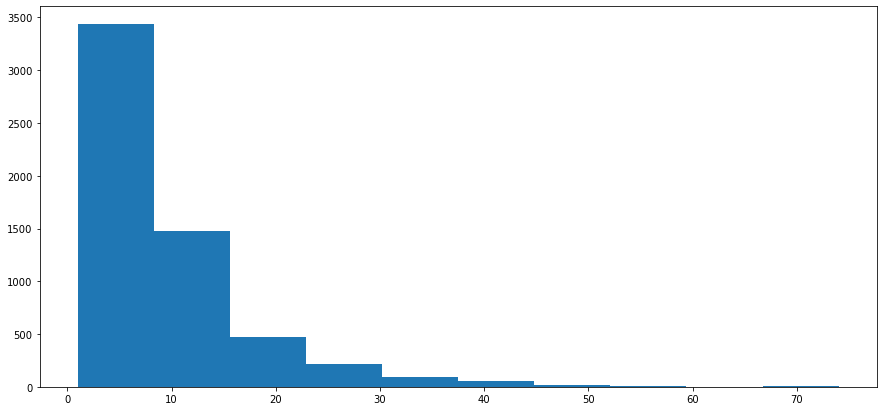

In [80]:
plt.hist([len(track) for track in tracks])

In [81]:
tracks_filt = [track for track in tracks if len(track) > 15]

(array([429., 203., 103.,  68.,  33.,  17.,   8.,   4.,   2.,   3.]),
 array([16. , 21.8, 27.6, 33.4, 39.2, 45. , 50.8, 56.6, 62.4, 68.2, 74. ]),
 <BarContainer object of 10 artists>)

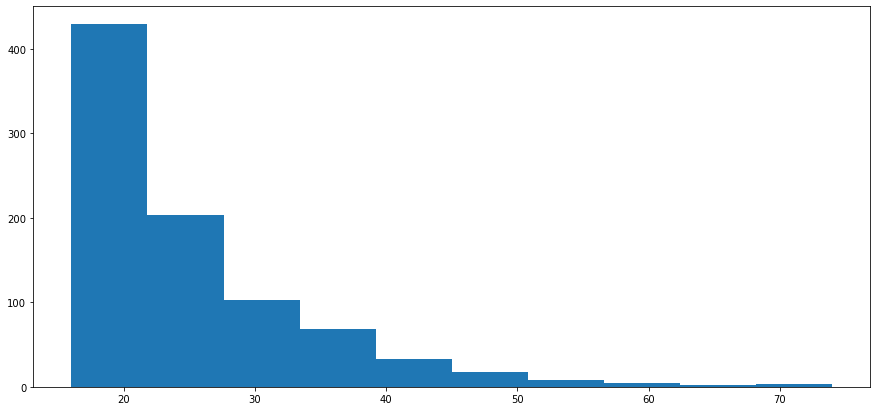

In [83]:
plt.hist([len(track) for track in tracks_filt])

In [84]:
view_tracks, properties, graph = btrack.utils.tracks_to_napari(tracks_filt, ndim = 2)

In [85]:
viewer = napari.Viewer()
viewer.add_image(gfp, name="gfp", 
                 #contrast_limits=[0,255],
                 blending = 'additive', colormap = 'green')
# viewer.add_image(rfp, name="rfp", 
#                 # contrast_limits=[0,55], 
#                  blending = 'additive', colormap = 'magenta')
viewer.add_labels(masks, name = 'masks')
viewer.add_tracks(view_tracks, name = 'tracks_filtered')

/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari_tools_menu/__init__.py:179: FutureWarning: Public access to Window.qt_viewer is deprecated and will be removed in
v0.5.0. It is considered an "implementation detail" of the napari
application, not part of the napari viewer model. If your use case
requires access to qt_viewer, please open an issue to discuss.
  self.tools_menu = ToolsMenu(self, self.qt_viewer.viewer)


<Tracks layer 'tracks_filtered' at 0x7f15801f1820>

In [ ]:
mask